# Implementación en numpy

In [13]:
import os
import numpy as np
import pickle
import itertools
import pandas as pd
# Perceptron con python: https://pyimagesearch.com/2021/05/06/implementing-the-perceptron-neural-network-with-python/#pyis-cta-modal
# Perceptron con PyTorch: https://www.geeksforgeeks.org/what-is-perceptron-the-simplest-artificial-neural-network/
# Perceptrones multicapa con PyTorch: https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb
# Implementación Forward Propagation: https://www.geeksforgeeks.org/what-is-forward-propagation-in-neural-networks/
# Implementación Back Propagation: https://www.geeksforgeeks.org/backpropagation-in-neural-network/

In [15]:
# Imagenes a color RGB
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir='cifar-10-batches-py'):
    # Cargar datos de entrenamiento
    data = []
    labels = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])

    data = np.concatenate(data)
    labels = np.concatenate(labels)

    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    labels = np.eye(10)[labels]  # One-hot encoding

    # Cargar datos de prueba
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    test_labels = np.eye(10)[test_batch[b'labels']]

    return data, labels, test_data, test_labels

def load_cifar100(data_dir='cifar-100-python'):
    data = unpickle(os.path.join(data_dir, 'train'))
    x_train = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_train = np.eye(100)[data[b'fine_labels']]

    data = unpickle(os.path.join(data_dir, 'test'))
    x_test = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_test = np.eye(100)[data[b'fine_labels']]

    return x_train, y_train, x_test, y_test

### Implementación

In [16]:
# --- FUNCIONES DE ACTIVACIÓN ---
def linear(x):
    return x
def linear_deriv(x):
    return np.ones_like(x)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x):
    return x * (1 - x)  # Derivada de la sigmoide, asumiendo que x ya es la salida de la sigmoide

class Perceptron:
    """
    Implementación de un perceptrón simple.
    Cada perceptrón tiene sus propios pesos y bias, y utiliza la función de activación sigmoide.
    """
    def __init__(self, input_size, learning_rate=0.1, activation='sigmoid'):
        # Inicialización de pesos y bias con valores pequeños aleatorios
        # Esto ayuda a romper la simetría y permite que cada neurona aprenda cosas distintas
        # self.weights = np.random.randn(input_size)
        # self.bias = np.random.randn()
        limit = np.sqrt(6 / (input_size + 1))
        self.weights = np.random.uniform(-limit, limit, input_size)
        self.bias = 0.0
        self.learning_rate = learning_rate
        self.activation_name = activation
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_deriv
        elif activation == 'linear':
            self.activation = linear
            self.activation_derivative = linear_deriv
        else:
            raise ValueError('Función de activación no soportada')

    def forward(self, x):
        # Propagación hacia adelante de una sola muestra
        # Calcula la suma ponderada y aplica la función de activación
        z = np.dot(x, self.weights) + self.bias
        return self.activation(z)

    def update(self, x, delta):
        # Actualiza los pesos y bias usando el gradiente calculado (delta)
        # delta ya incluye la derivada de la sigmoide (por la regla de la cadena)
        # La actualización sigue la dirección del gradiente descendente
        self.weights += self.learning_rate * delta * x
        self.bias += self.learning_rate * delta

class NeuralNetwork:
    """
    Red neuronal multicapa compuesta por capas de perceptrones.
    Permite definir cualquier cantidad de capas y neuronas por capa.
    """
    def __init__(self, layer_sizes, learning_rate=0.1, activation='sigmoid'):
        # layer_sizes: lista con el tamaño de cada capa, EJEMPLO: [784, 100, 10]
        self.layers: list[list[Perceptron]] = []
        self.learning_rate = learning_rate
        self.activation = activation
        for i in range(1, len(layer_sizes)):
            capa = [Perceptron(layer_sizes[i-1], learning_rate, activation) for _ in range(layer_sizes[i])]
            # EJEMPLO:
            # - Para la primera capa oculta generaria 100 neuronas que aceptan vectores inputs de 784 dimensiones (input layer).
            # - Para la capa de input no se crea un perceptrón, ya que es la entrada de la red.
            # - La capa de salida generaria 10 neuronas que aceptan vectores inputs de 100 dimensiones (capa oculta).
            self.layers.append(capa)
        
        # Mostrar la estructura de la red
        # print("Estructura de la red:")
        # for i, capa in enumerate(self.layers):
        #     print(f"Capa {i+1}: {len(capa)} neuronas, cada una con {capa[0].weights.shape[0]} pesos")
        # print("\nPesos de la capa intermedia:")
        # for idx, neuron in enumerate(self.layers[0]):
        #     print(f"Neurona {idx}: {neuron.weights}")
        # print("\nPesos de la capa de salida:")
        # for idx, neuron in enumerate(self.layers[-1]):
        #     print(f"Neurona {idx}: {neuron.weights}")

    def forward(self, x):
        # Propagación hacia adelante para una muestra
        activations = [x]   # Inicialmente arranca con el input (x, vector de entrada)
        for capa in self.layers:
            salida_capa = np.array([neuron.forward(activations[-1]) for neuron in capa])
            activations.append(salida_capa)
        return activations

    def predict(self, x):
        # Predicción para una muestra
        activations = self.forward(x)
        return activations[-1]

    def train(self, X, Y, epochs=10, X_val=None, Y_val=None) -> dict[str, list]:
        """
        Entrenamiento usando backpropagation.
        Ahora guarda el historial de loss y accuracy para graficar.
        Si se pasan X_val, Y_val, también calcula métricas de validación.
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Diccionario para guardar métricas
        # Entrenamiento usando backpropagation (solo para fines didácticos, no optimizado)
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for xi, yi in zip(X, Y):
                # Forward
                activations = self.forward(xi)  # activations es una lista de arrays, donde cada array es la salida de cada capa (función de activación sigmoidea aplicada)
                # Backward
                deltas = [None] * len(self.layers)
                # Capa de salida
                error = yi - activations[-1]    # Resta de vectores
                total_loss += np.sum((error) ** 2) / 2  # Suma de errores cuadráticos (MSE)
                if np.argmax(activations[-1]) == np.argmax(yi):
                    correct += 1
                deltas[-1] = error * np.array([
                    neuron.activation_derivative(activations[-1][j])
                    for j, neuron in enumerate(self.layers[-1])
                ])
                # Capas ocultas
                for l in reversed(range(len(self.layers)-1)):
                    delta_next = deltas[l+1]    # lista de deltas de la capa siguiente (son 10 deltas)
                    pesos_next = np.array([neuron.weights for neuron in self.layers[l+1]])  # En la primera iteracion para MNIST, es un array de arrays de pesos de la capa siguiente -> matriz de 10 filas y 100 columnas
                    # deprecated: deltas[l] = self.layers[l][0].activation_derivative(activations[l+1]) * np.dot(pesos_next.T, delta_next)
                    deltas[l] = np.array([
                        neuron.activation_derivative(activations[l+1][j])
                        for j, neuron in enumerate(self.layers[l])
                    ]) * np.dot(pesos_next.T, delta_next)   # el resultado del producto escalar (np.dot) es un vector de 100 dimensiones (deltas de la capa oculta)

                # Actualización de pesos
                for l, capa in enumerate(self.layers):
                    for j, neuron in enumerate(capa):
                        neuron.update(activations[l], deltas[l][j])
                        # para calcular el delta de cada neurona, se usa la derivada de la activación de esa neurona (activations[l+1][j])
                        # pero para actualizar los pesos, cada neurona necesita todas las salidas de la capa anterior, no solo una (activations[l]) -> entonces, actualiza cada peso de cada feature, sumando al vector de pesos el vector corrección

            acc = correct / len(X)
            history['loss'].append(total_loss / len(X))  # Promedio de loss por muestra
            history['accuracy'].append(acc)              # Accuracy de entrenamiento

            # Validación (si se pasa X_val, Y_val)
            if X_val is not None and Y_val is not None:
                val_loss = 0
                val_correct = 0
                for xi, yi in zip(X_val, Y_val):
                    out = self.predict(xi)
                    val_loss += np.sum((yi - out) ** 2) / 2
                    if np.argmax(out) == np.argmax(yi):
                        val_correct += 1
                history['val_loss'].append(val_loss / len(X_val))
                history['val_accuracy'].append(val_correct / len(X_val))
            if epoch % max(1, epochs//10) == 0:
                # Imprime métricas cada 10% de las épocas
                print(f"Epoch {epoch+1}/{epochs} - Loss: {history['loss'][-1]:.4f} - Acc: {acc:.4f}")
        return history  # Devuelve el historial para graficar


In [10]:
activaciones = ['sigmoid', 'linear']
capas = [[32], [64], [128], [64, 32], [32, 32, 32]]
learning_rates = [0.1, 0.01, 0.001]
epoch = 10

### Prueba de dataset MNIST

In [11]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_val = X[split:]
y_val = Y[split:]

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.1
Epoch 1/10 - Loss: 0.1737 - Acc: 0.8097
Epoch 2/10 - Loss: 0.0822 - Acc: 0.9141
Epoch 3/10 - Loss: 0.0659 - Acc: 0.9273
Epoch 4/10 - Loss: 0.0568 - Acc: 0.9370
Epoch 5/10 - Loss: 0.0505 - Acc: 0.9449
Epoch 6/10 - Loss: 0.0456 - Acc: 0.9504
Epoch 7/10 - Loss: 0.0416 - Acc: 0.9547
Epoch 8/10 - Loss: 0.0383 - Acc: 0.9593
Epoch 9/10 - Loss: 0.0355 - Acc: 0.9616
Epoch 10/10 - Loss: 0.0330 - Acc: 0.9655


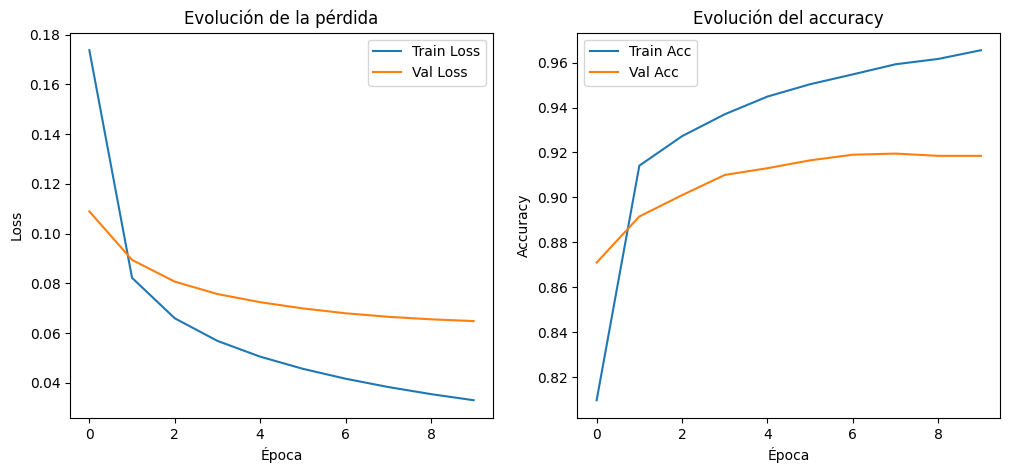

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.01
Epoch 1/10 - Loss: 0.3903 - Acc: 0.5114
Epoch 2/10 - Loss: 0.2564 - Acc: 0.7515
Epoch 3/10 - Loss: 0.1898 - Acc: 0.8379
Epoch 4/10 - Loss: 0.1536 - Acc: 0.8689
Epoch 5/10 - Loss: 0.1320 - Acc: 0.8828
Epoch 6/10 - Loss: 0.1179 - Acc: 0.8920
Epoch 7/10 - Loss: 0.1079 - Acc: 0.8984
Epoch 8/10 - Loss: 0.1004 - Acc: 0.9032
Epoch 9/10 - Loss: 0.0945 - Acc: 0.9083
Epoch 10/10 - Loss: 0.0896 - Acc: 0.9106


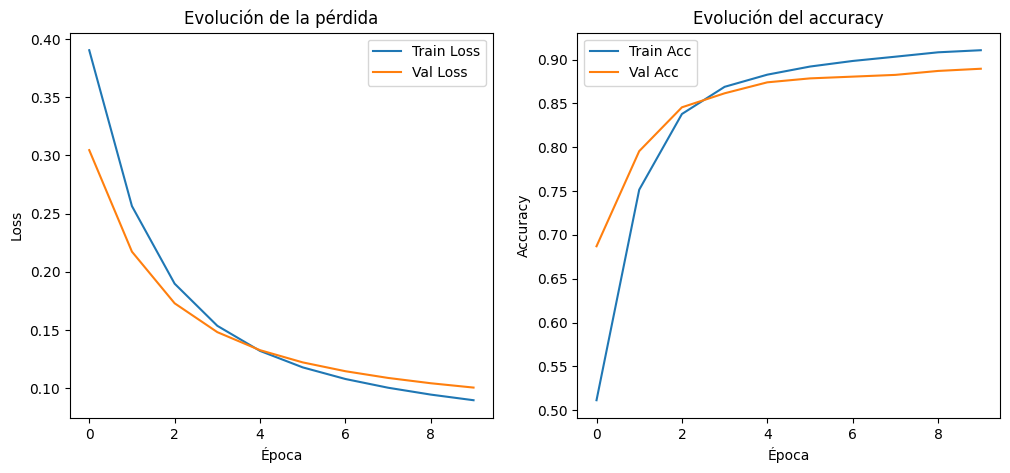

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.001
Epoch 1/10 - Loss: 0.5614 - Acc: 0.1694
Epoch 2/10 - Loss: 0.4414 - Acc: 0.3035
Epoch 3/10 - Loss: 0.4317 - Acc: 0.3624
Epoch 4/10 - Loss: 0.4208 - Acc: 0.3866
Epoch 5/10 - Loss: 0.4080 - Acc: 0.4032
Epoch 6/10 - Loss: 0.3943 - Acc: 0.4220
Epoch 7/10 - Loss: 0.3803 - Acc: 0.4477
Epoch 8/10 - Loss: 0.3668 - Acc: 0.4766
Epoch 9/10 - Loss: 0.3538 - Acc: 0.5040
Epoch 10/10 - Loss: 0.3415 - Acc: 0.5337


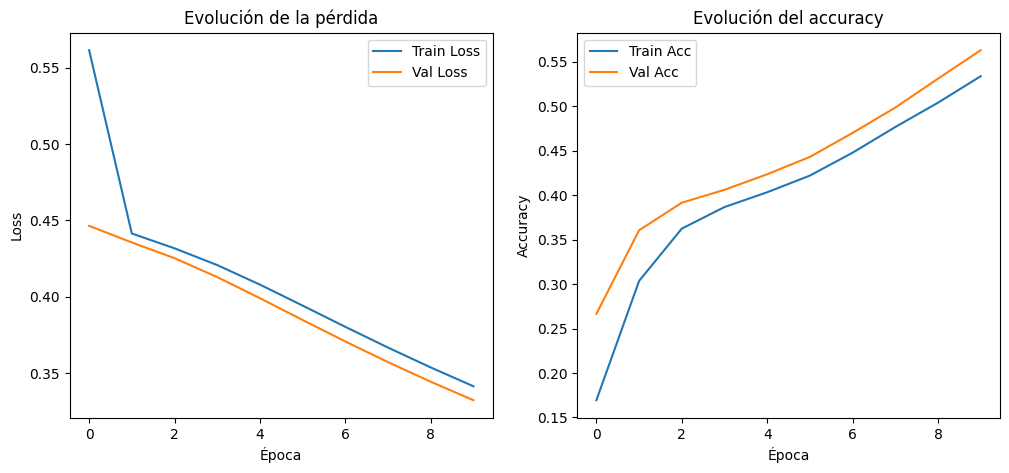

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.1
Epoch 1/10 - Loss: 0.1652 - Acc: 0.8137
Epoch 2/10 - Loss: 0.0809 - Acc: 0.9141
Epoch 3/10 - Loss: 0.0651 - Acc: 0.9297
Epoch 4/10 - Loss: 0.0559 - Acc: 0.9375
Epoch 5/10 - Loss: 0.0494 - Acc: 0.9451
Epoch 6/10 - Loss: 0.0443 - Acc: 0.9509
Epoch 7/10 - Loss: 0.0401 - Acc: 0.9565
Epoch 8/10 - Loss: 0.0366 - Acc: 0.9611
Epoch 9/10 - Loss: 0.0336 - Acc: 0.9630
Epoch 10/10 - Loss: 0.0310 - Acc: 0.9675


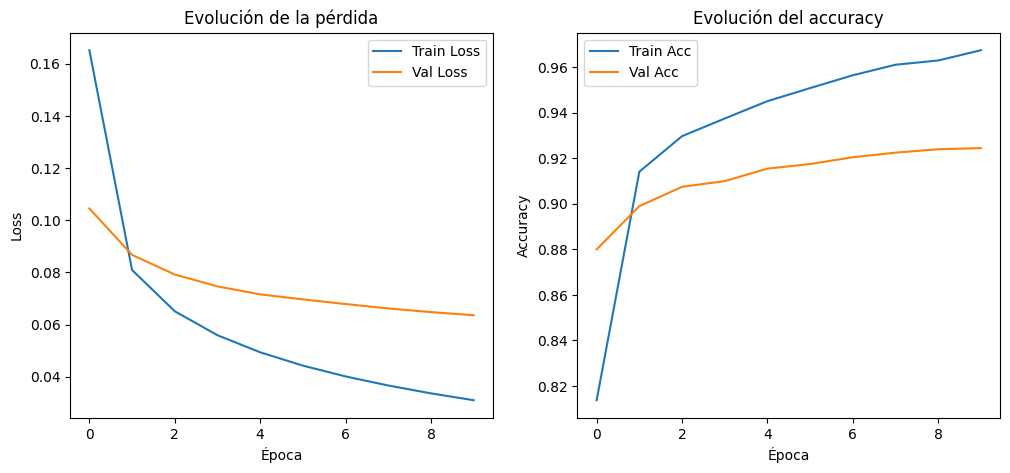

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.01
Epoch 1/10 - Loss: 0.3818 - Acc: 0.5259
Epoch 2/10 - Loss: 0.2408 - Acc: 0.7516
Epoch 3/10 - Loss: 0.1802 - Acc: 0.8375
Epoch 4/10 - Loss: 0.1468 - Acc: 0.8686
Epoch 5/10 - Loss: 0.1266 - Acc: 0.8835
Epoch 6/10 - Loss: 0.1136 - Acc: 0.8939
Epoch 7/10 - Loss: 0.1045 - Acc: 0.9004
Epoch 8/10 - Loss: 0.0978 - Acc: 0.9056
Epoch 9/10 - Loss: 0.0924 - Acc: 0.9106
Epoch 10/10 - Loss: 0.0881 - Acc: 0.9134


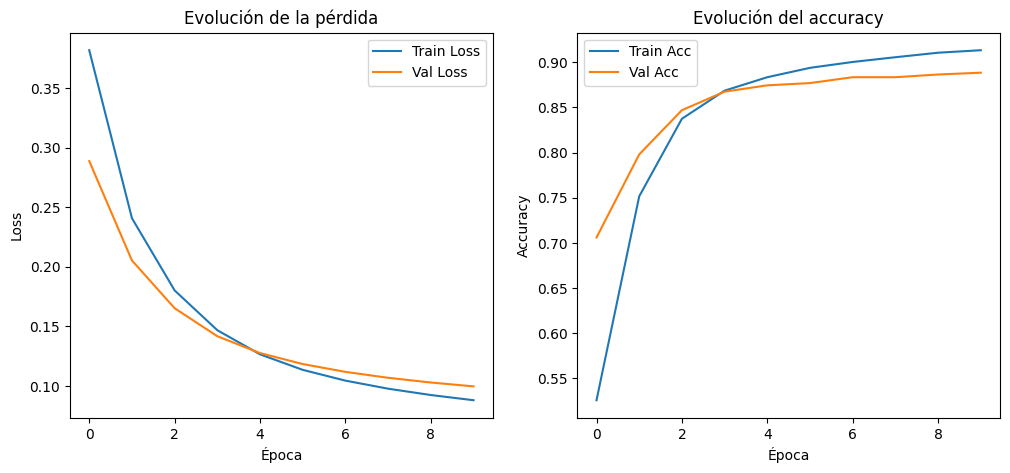

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.001
Epoch 1/10 - Loss: 0.5340 - Acc: 0.2620
Epoch 2/10 - Loss: 0.4286 - Acc: 0.3901
Epoch 3/10 - Loss: 0.4125 - Acc: 0.4479
Epoch 4/10 - Loss: 0.3938 - Acc: 0.5070
Epoch 5/10 - Loss: 0.3736 - Acc: 0.5543
Epoch 6/10 - Loss: 0.3535 - Acc: 0.5911
Epoch 7/10 - Loss: 0.3344 - Acc: 0.6259
Epoch 8/10 - Loss: 0.3167 - Acc: 0.6564
Epoch 9/10 - Loss: 0.3007 - Acc: 0.6826
Epoch 10/10 - Loss: 0.2862 - Acc: 0.7079


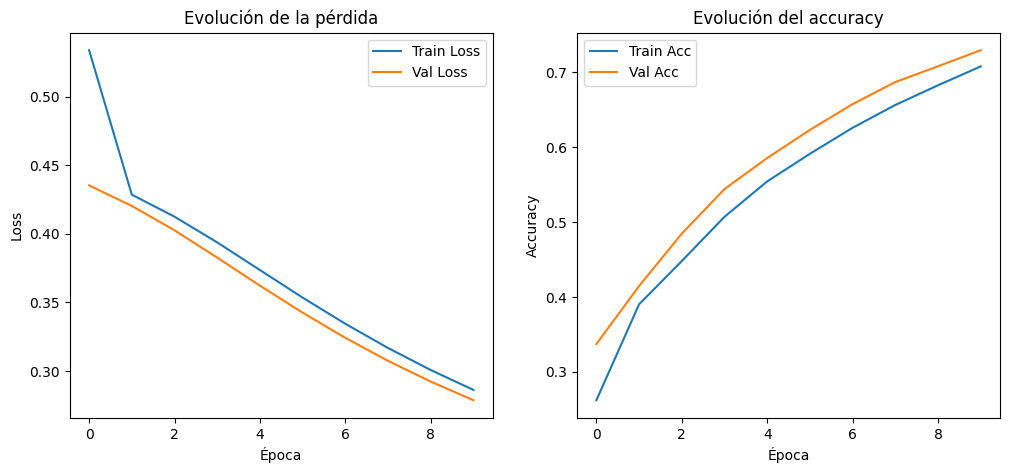

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.1
Epoch 1/10 - Loss: 0.1645 - Acc: 0.8056
Epoch 2/10 - Loss: 0.0854 - Acc: 0.9074
Epoch 3/10 - Loss: 0.0697 - Acc: 0.9243
Epoch 4/10 - Loss: 0.0599 - Acc: 0.9333
Epoch 5/10 - Loss: 0.0525 - Acc: 0.9401
Epoch 6/10 - Loss: 0.0468 - Acc: 0.9475
Epoch 7/10 - Loss: 0.0421 - Acc: 0.9523
Epoch 8/10 - Loss: 0.0383 - Acc: 0.9560
Epoch 9/10 - Loss: 0.0349 - Acc: 0.9600
Epoch 10/10 - Loss: 0.0320 - Acc: 0.9646


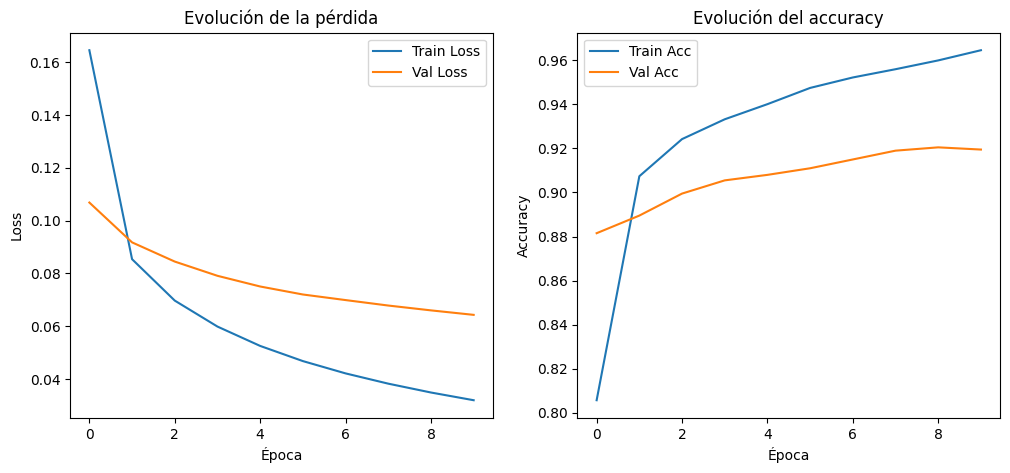

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.01
Epoch 1/10 - Loss: 0.3631 - Acc: 0.5621
Epoch 2/10 - Loss: 0.2160 - Acc: 0.8091
Epoch 3/10 - Loss: 0.1622 - Acc: 0.8585
Epoch 4/10 - Loss: 0.1360 - Acc: 0.8765
Epoch 5/10 - Loss: 0.1205 - Acc: 0.8871
Epoch 6/10 - Loss: 0.1103 - Acc: 0.8941
Epoch 7/10 - Loss: 0.1029 - Acc: 0.9000
Epoch 8/10 - Loss: 0.0973 - Acc: 0.9048
Epoch 9/10 - Loss: 0.0927 - Acc: 0.9086
Epoch 10/10 - Loss: 0.0889 - Acc: 0.9120


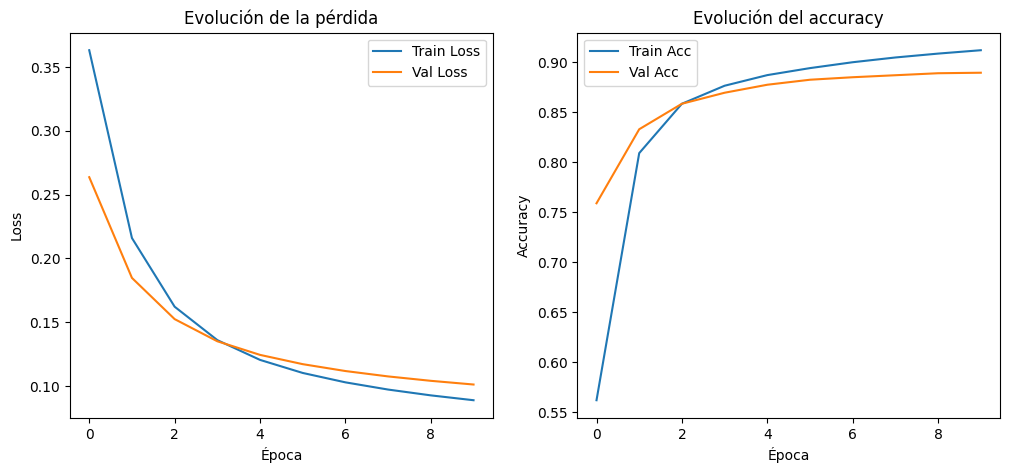

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.001
Epoch 1/10 - Loss: 0.4815 - Acc: 0.2497
Epoch 2/10 - Loss: 0.4299 - Acc: 0.4046
Epoch 3/10 - Loss: 0.4122 - Acc: 0.4474
Epoch 4/10 - Loss: 0.3906 - Acc: 0.4971
Epoch 5/10 - Loss: 0.3672 - Acc: 0.5580
Epoch 6/10 - Loss: 0.3439 - Acc: 0.6148
Epoch 7/10 - Loss: 0.3220 - Acc: 0.6644
Epoch 8/10 - Loss: 0.3021 - Acc: 0.7024
Epoch 9/10 - Loss: 0.2844 - Acc: 0.7324
Epoch 10/10 - Loss: 0.2689 - Acc: 0.7572


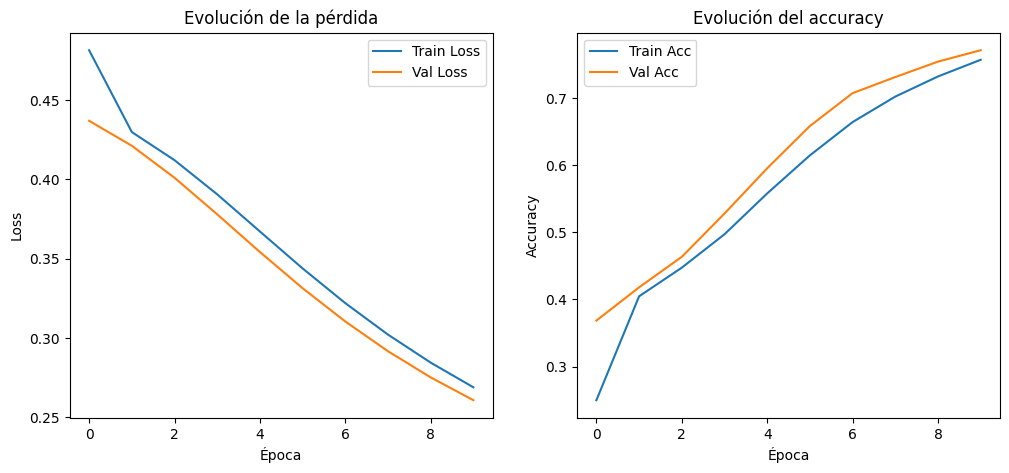

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.1
Epoch 1/10 - Loss: 0.2836 - Acc: 0.5936
Epoch 2/10 - Loss: 0.1103 - Acc: 0.8832
Epoch 3/10 - Loss: 0.0735 - Acc: 0.9184
Epoch 4/10 - Loss: 0.0593 - Acc: 0.9311
Epoch 5/10 - Loss: 0.0505 - Acc: 0.9406
Epoch 6/10 - Loss: 0.0440 - Acc: 0.9503
Epoch 7/10 - Loss: 0.0390 - Acc: 0.9559
Epoch 8/10 - Loss: 0.0348 - Acc: 0.9614
Epoch 9/10 - Loss: 0.0311 - Acc: 0.9663
Epoch 10/10 - Loss: 0.0280 - Acc: 0.9699


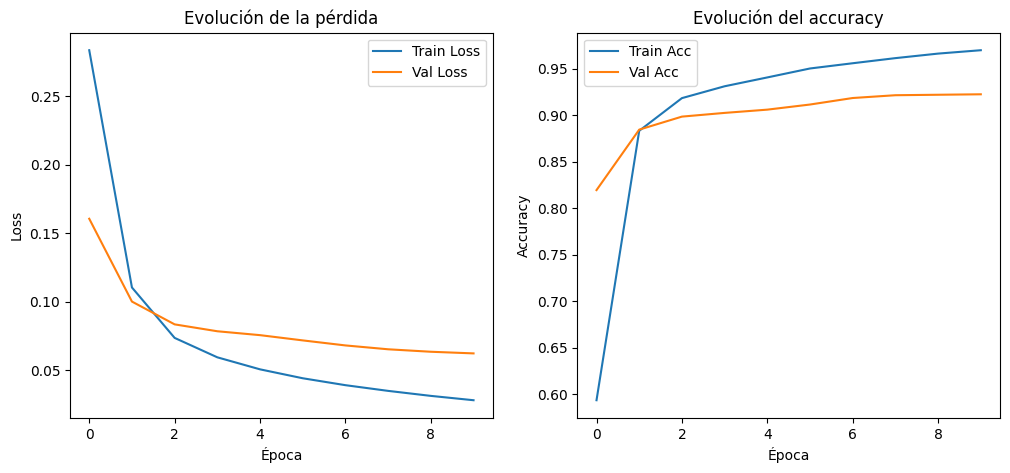

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.01
Epoch 1/10 - Loss: 0.4545 - Acc: 0.1852
Epoch 2/10 - Loss: 0.4268 - Acc: 0.3731
Epoch 3/10 - Loss: 0.3785 - Acc: 0.5366
Epoch 4/10 - Loss: 0.3079 - Acc: 0.6408
Epoch 5/10 - Loss: 0.2536 - Acc: 0.7099
Epoch 6/10 - Loss: 0.2184 - Acc: 0.7561
Epoch 7/10 - Loss: 0.1929 - Acc: 0.7960
Epoch 8/10 - Loss: 0.1710 - Acc: 0.8314
Epoch 9/10 - Loss: 0.1519 - Acc: 0.8560
Epoch 10/10 - Loss: 0.1359 - Acc: 0.8748


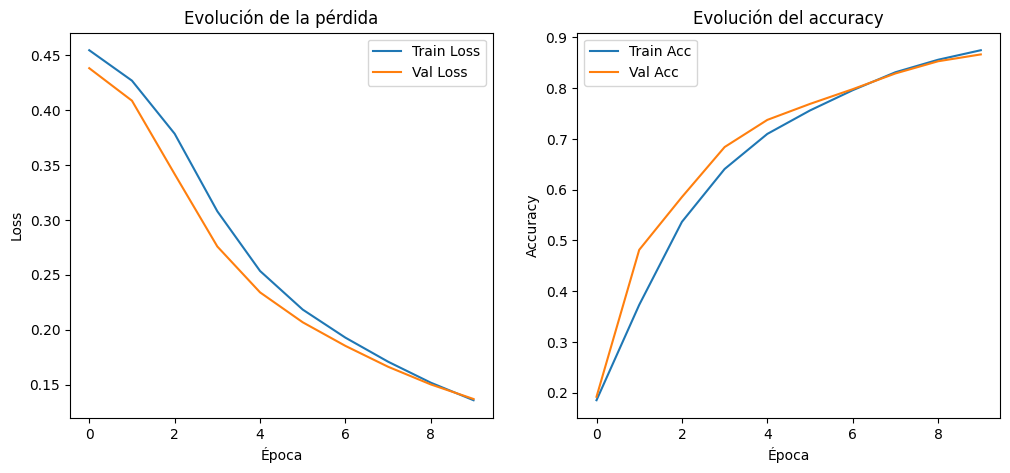

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.001
Epoch 1/10 - Loss: 0.5405 - Acc: 0.1031
Epoch 2/10 - Loss: 0.4500 - Acc: 0.1219
Epoch 3/10 - Loss: 0.4483 - Acc: 0.1199
Epoch 4/10 - Loss: 0.4476 - Acc: 0.1229
Epoch 5/10 - Loss: 0.4469 - Acc: 0.1301
Epoch 6/10 - Loss: 0.4462 - Acc: 0.1414
Epoch 7/10 - Loss: 0.4455 - Acc: 0.1575
Epoch 8/10 - Loss: 0.4448 - Acc: 0.1839
Epoch 9/10 - Loss: 0.4440 - Acc: 0.2157
Epoch 10/10 - Loss: 0.4431 - Acc: 0.2537


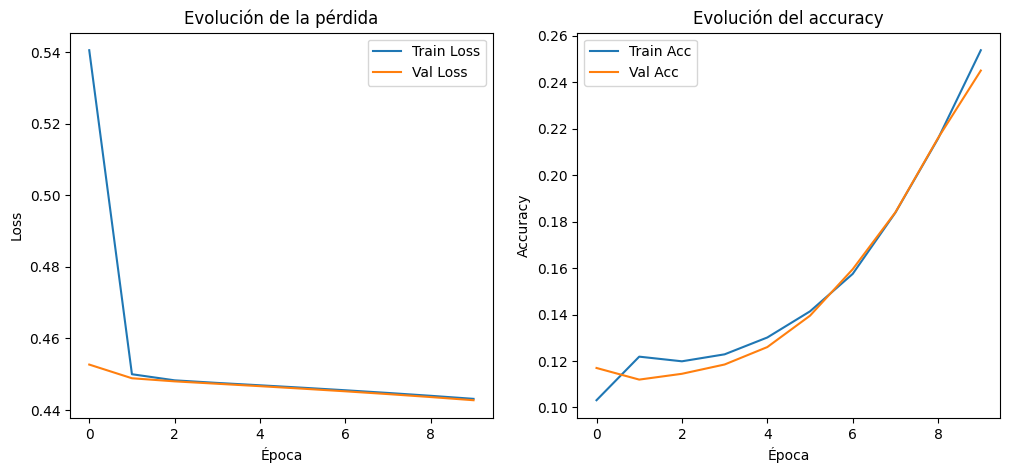

Entrenando con f(x) activación=sigmoid, capas=[32, 32, 32], lr=0.1
Epoch 1/10 - Loss: 0.4298 - Acc: 0.2135
Epoch 2/10 - Loss: 0.2417 - Acc: 0.6821
Epoch 3/10 - Loss: 0.1234 - Acc: 0.8555
Epoch 4/10 - Loss: 0.0849 - Acc: 0.9054
Epoch 5/10 - Loss: 0.0657 - Acc: 0.9240
Epoch 6/10 - Loss: 0.0557 - Acc: 0.9345
Epoch 7/10 - Loss: 0.0481 - Acc: 0.9416


In [ ]:
output_layer_size = 10  # MNIST tiene 10 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

### Prueba de dataset CIFAR-10

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar10(f"data/CIFAR-10")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

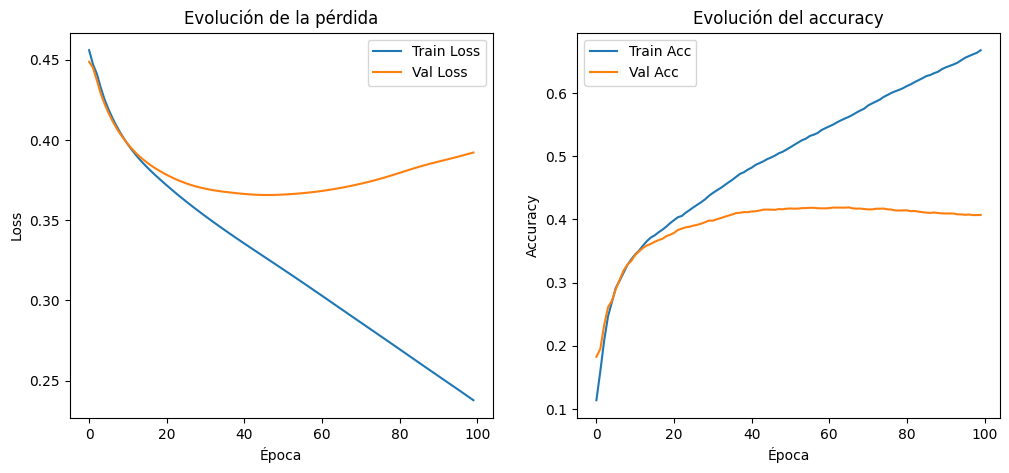

In [ ]:
output_layer_size = 10  # CIFAR-10 tiene 10 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

### Prueba de dataset CIFAR-100

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar100(f"data/CIFAR-100")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y


Pesos de la capa de salida:
Neurona 0: [-0.20724945  0.41571839 -0.14944219 -0.05757601  0.23028171  0.3499999
  0.2173457  -0.29496126  0.31837704 -0.14314703 -0.37406133  0.09828584
 -0.36073573 -0.03023553  0.37231128  0.41160858  0.20882544  0.16963291
  0.31628233 -0.08188984  0.1032163   0.20488514  0.27093572 -0.01134825
  0.04688016 -0.39794204  0.05163963 -0.2583686  -0.05009854  0.07747291
  0.30419156  0.08937501]
Neurona 1: [-0.17903534  0.01336629 -0.39445242  0.09661577  0.24712928  0.17731751
 -0.00119742 -0.27940745 -0.093417    0.24336327  0.10469396 -0.19112562
  0.20902821  0.17996798 -0.36907948 -0.38769876  0.1148671   0.11281279
  0.04804068  0.00226606  0.25564076 -0.32926692 -0.07769252 -0.21715777
 -0.0459294  -0.04021083 -0.07234684 -0.39593386  0.32228857 -0.2415774
 -0.12269152  0.31450491]
Neurona 2: [ 0.12077529 -0.14681541 -0.35699868 -0.15699562  0.0541082   0.26331047
 -0.42108065  0.24310047 -0.2784732   0.11839823 -0.01410105  0.27501351
 -0.27904218

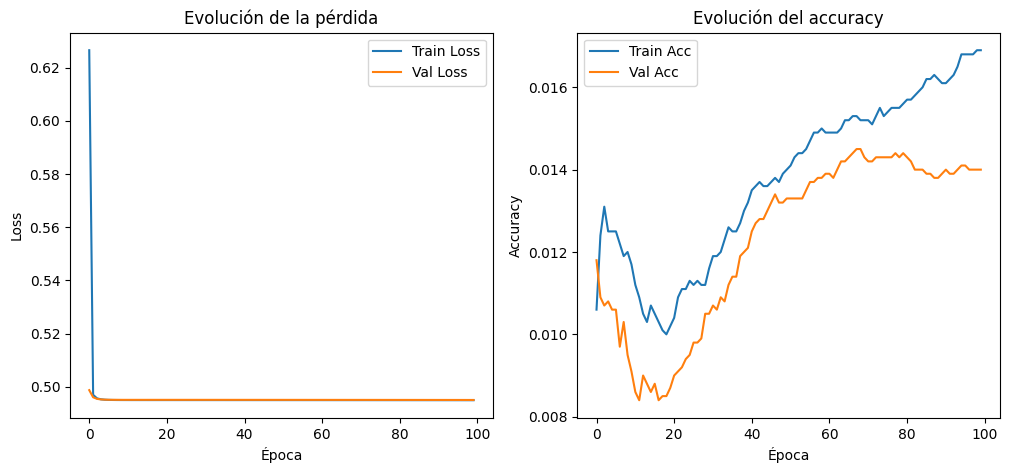

In [ ]:
output_layer_size = 100  # CIFAR-100 tiene 100 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

# Implementación con Pytorch

### Implementación

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

In [29]:
class NeuralNetworkPyTorch:
    def __init__(
        self,
        layer_sizes,
        learning_rate=0.01,
        activation="sigmoid",
        device=None,
        num_workers=1,
    ):
        """
        layer_sizes: lista con tamaño de capas, e.g., [3072, 64, 32, 100]
        activation: 'sigmoid' o 'linear'
        """
        self.device = device or torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.activation = activation
        self.model = self.build_model(layer_sizes, activation).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        self.num_workers = num_workers

    def build_model(self, sizes, activation):
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if activation == "sigmoid":
                layers.append(nn.Sigmoid())
            elif activation == "linear":
                # Linear es identidad, no se agrega capa de activación
                pass
            else:
                raise ValueError(
                    f"Función de activación '{activation}' no soportada en PyTorch"
                )
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        return nn.Sequential(*layers)

    def train(self, X, Y, epochs=10, batch_size=64, X_val=None, Y_val=None):
        """
        X: tensor (n_samples x input_dim)
        Y: tensor de etiquetas (n_samples,) tipo long (no one-hot)
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        dataset = torch.utils.data.TensorDataset(X, Y)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True, num_workers=self.num_workers
        )

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for batch_X, batch_Y in loader:
                batch_X = batch_X.to(self.device)
                batch_Y = batch_Y.to(self.device)

                outputs = self.model(batch_X)
                loss = self.loss_fn(outputs, batch_Y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_Y).sum().item()
                total += batch_Y.size(0)
            
            avg_loss = total_loss / len(loader)
            acc = correct / total
            history['loss'].append(avg_loss)
            history['accuracy'].append(acc)

            # Evaluación en validación si se pasa
            if X_val is not None and Y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    X_val = X_val.to(self.device)
                    Y_val = Y_val.to(self.device)
                    outputs = self.model(X_val)
                    val_loss = self.loss_fn(outputs, Y_val).item()
                    _, predicted = torch.max(outputs, 1)
                    val_acc = (predicted == Y_val).sum().item() / Y_val.size(0)
                    history['val_loss'].append(val_loss)
                    history['val_accuracy'].append(val_acc)

            # Mostrar progreso cada 10% del total
            if epoch % max(1, epochs // 10) == 0:
                log = f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Acc: {acc:.4f}"
                if X_val is not None and Y_val is not None:
                    log += f" - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}"
                print(log)

        return history

    def predict(self, X):
        """
        X: tensor (n_samples x input_dim)
        return: tensor con índices de clases predichas
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            outputs = self.model(X)
            predictions = torch.argmax(outputs, dim=1)
        return predictions

In [30]:
activaciones = ['sigmoid', 'linear']
capas = [[32], [64], [128], [64, 32], [32, 32, 32]]
learning_rates = [0.1, 0.01, 0.001]
epoch = 10

### Prueba con dataset MNIST

In [31]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

Epoch 1/10 - Loss: 2.2908 - Acc: 0.1393 - Val Loss: 2.2588 - Val Acc: 0.2200
Epoch 2/10 - Loss: 2.2398 - Acc: 0.3050 - Val Loss: 2.2178 - Val Acc: 0.3885
Epoch 3/10 - Loss: 2.1967 - Acc: 0.3789 - Val Loss: 2.1715 - Val Acc: 0.5530
Epoch 4/10 - Loss: 2.1471 - Acc: 0.5044 - Val Loss: 2.1178 - Val Acc: 0.5770
Epoch 5/10 - Loss: 2.0880 - Acc: 0.5556 - Val Loss: 2.0534 - Val Acc: 0.5925
Epoch 6/10 - Loss: 2.0187 - Acc: 0.5867 - Val Loss: 1.9795 - Val Acc: 0.6070
Epoch 7/10 - Loss: 1.9396 - Acc: 0.6070 - Val Loss: 1.8961 - Val Acc: 0.6145
Epoch 8/10 - Loss: 1.8534 - Acc: 0.6304 - Val Loss: 1.8066 - Val Acc: 0.6370
Epoch 9/10 - Loss: 1.7622 - Acc: 0.6501 - Val Loss: 1.7145 - Val Acc: 0.6670
Epoch 10/10 - Loss: 1.6692 - Acc: 0.6704 - Val Loss: 1.6224 - Val Acc: 0.6920


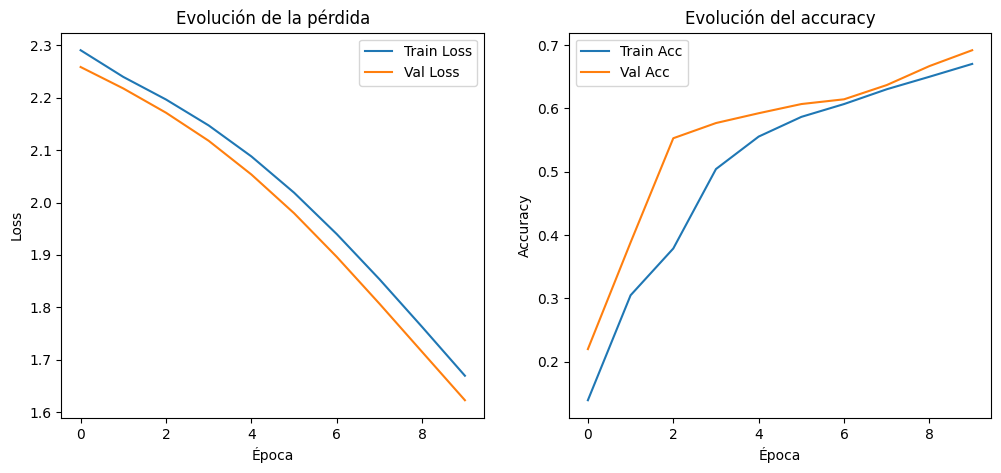

Epoch 1/10 - Loss: 2.0554 - Acc: 0.5319 - Val Loss: 1.7695 - Val Acc: 0.7070
Epoch 2/10 - Loss: 1.5198 - Acc: 0.7354 - Val Loss: 1.2419 - Val Acc: 0.7720
Epoch 3/10 - Loss: 1.0652 - Acc: 0.7909 - Val Loss: 0.9096 - Val Acc: 0.8080
Epoch 4/10 - Loss: 0.8056 - Acc: 0.8267 - Val Loss: 0.7410 - Val Acc: 0.8400
Epoch 5/10 - Loss: 0.6628 - Acc: 0.8494 - Val Loss: 0.6443 - Val Acc: 0.8535
Epoch 6/10 - Loss: 0.5763 - Acc: 0.8635 - Val Loss: 0.5834 - Val Acc: 0.8610
Epoch 7/10 - Loss: 0.5208 - Acc: 0.8711 - Val Loss: 0.5400 - Val Acc: 0.8620
Epoch 8/10 - Loss: 0.4792 - Acc: 0.8789 - Val Loss: 0.5117 - Val Acc: 0.8700
Epoch 9/10 - Loss: 0.4504 - Acc: 0.8840 - Val Loss: 0.4898 - Val Acc: 0.8720
Epoch 10/10 - Loss: 0.4262 - Acc: 0.8884 - Val Loss: 0.4709 - Val Acc: 0.8740


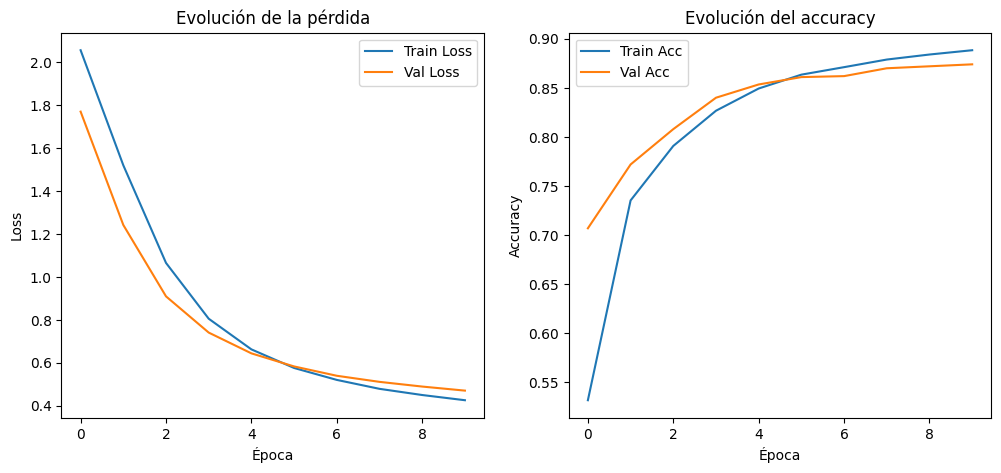

Epoch 1/10 - Loss: 2.3684 - Acc: 0.0985 - Val Loss: 2.3561 - Val Acc: 0.1015
Epoch 2/10 - Loss: 2.3478 - Acc: 0.0985 - Val Loss: 2.3371 - Val Acc: 0.1015
Epoch 3/10 - Loss: 2.3309 - Acc: 0.0979 - Val Loss: 2.3224 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3176 - Acc: 0.1080 - Val Loss: 2.3107 - Val Acc: 0.1285
Epoch 5/10 - Loss: 2.3073 - Acc: 0.1163 - Val Loss: 2.3012 - Val Acc: 0.1165
Epoch 6/10 - Loss: 2.2985 - Acc: 0.1121 - Val Loss: 2.2931 - Val Acc: 0.1210
Epoch 7/10 - Loss: 2.2911 - Acc: 0.1258 - Val Loss: 2.2862 - Val Acc: 0.1300
Epoch 8/10 - Loss: 2.2841 - Acc: 0.1294 - Val Loss: 2.2801 - Val Acc: 0.1255
Epoch 9/10 - Loss: 2.2785 - Acc: 0.1258 - Val Loss: 2.2746 - Val Acc: 0.1220
Epoch 10/10 - Loss: 2.2737 - Acc: 0.1230 - Val Loss: 2.2695 - Val Acc: 0.1215


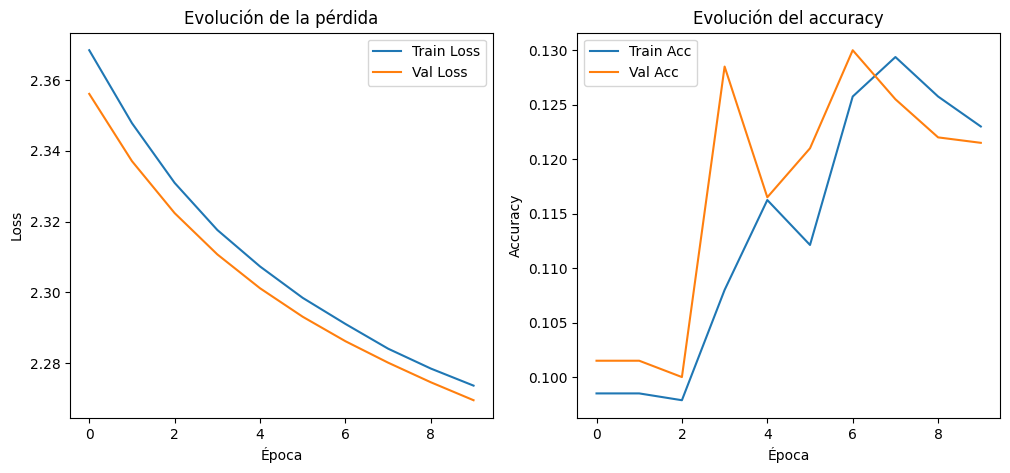

Epoch 1/10 - Loss: 2.2924 - Acc: 0.1170 - Val Loss: 2.2562 - Val Acc: 0.1490
Epoch 2/10 - Loss: 2.2289 - Acc: 0.1875 - Val Loss: 2.1938 - Val Acc: 0.2420
Epoch 3/10 - Loss: 2.1684 - Acc: 0.3317 - Val Loss: 2.1336 - Val Acc: 0.4210
Epoch 4/10 - Loss: 2.1087 - Acc: 0.4810 - Val Loss: 2.0743 - Val Acc: 0.5390
Epoch 5/10 - Loss: 2.0502 - Acc: 0.5660 - Val Loss: 2.0155 - Val Acc: 0.5960
Epoch 6/10 - Loss: 1.9917 - Acc: 0.6145 - Val Loss: 1.9567 - Val Acc: 0.6245
Epoch 7/10 - Loss: 1.9328 - Acc: 0.6450 - Val Loss: 1.8978 - Val Acc: 0.6525
Epoch 8/10 - Loss: 1.8738 - Acc: 0.6599 - Val Loss: 1.8388 - Val Acc: 0.6665
Epoch 9/10 - Loss: 1.8150 - Acc: 0.6750 - Val Loss: 1.7798 - Val Acc: 0.6720
Epoch 10/10 - Loss: 1.7552 - Acc: 0.6849 - Val Loss: 1.7210 - Val Acc: 0.6780


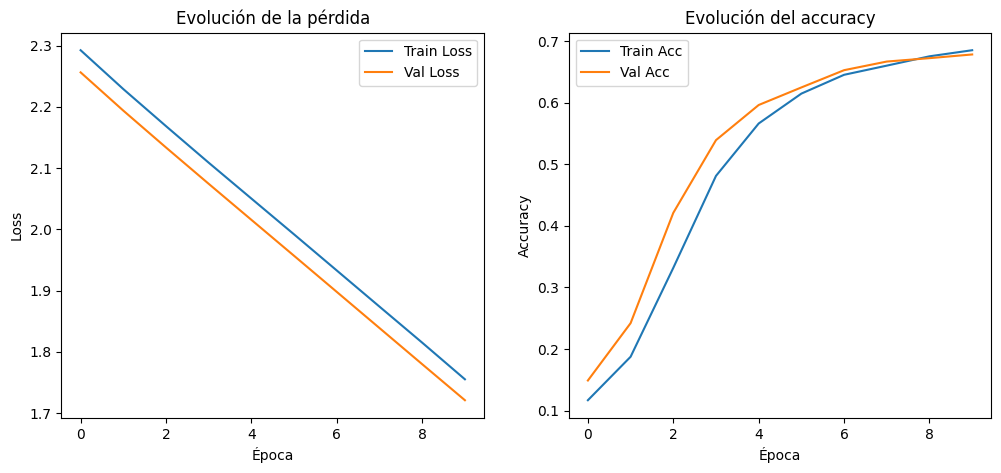

Epoch 1/10 - Loss: 2.3352 - Acc: 0.1133 - Val Loss: 2.3347 - Val Acc: 0.1105
Epoch 2/10 - Loss: 2.3336 - Acc: 0.1133 - Val Loss: 2.3331 - Val Acc: 0.1105
Epoch 3/10 - Loss: 2.3319 - Acc: 0.1133 - Val Loss: 2.3316 - Val Acc: 0.1105
Epoch 4/10 - Loss: 2.3304 - Acc: 0.1133 - Val Loss: 2.3301 - Val Acc: 0.1105
Epoch 5/10 - Loss: 2.3294 - Acc: 0.1133 - Val Loss: 2.3286 - Val Acc: 0.1105
Epoch 6/10 - Loss: 2.3276 - Acc: 0.1133 - Val Loss: 2.3272 - Val Acc: 0.1105
Epoch 7/10 - Loss: 2.3263 - Acc: 0.1133 - Val Loss: 2.3258 - Val Acc: 0.1105
Epoch 8/10 - Loss: 2.3249 - Acc: 0.1133 - Val Loss: 2.3245 - Val Acc: 0.1105
Epoch 9/10 - Loss: 2.3238 - Acc: 0.1133 - Val Loss: 2.3231 - Val Acc: 0.1105
Epoch 10/10 - Loss: 2.3223 - Acc: 0.1133 - Val Loss: 2.3218 - Val Acc: 0.1105


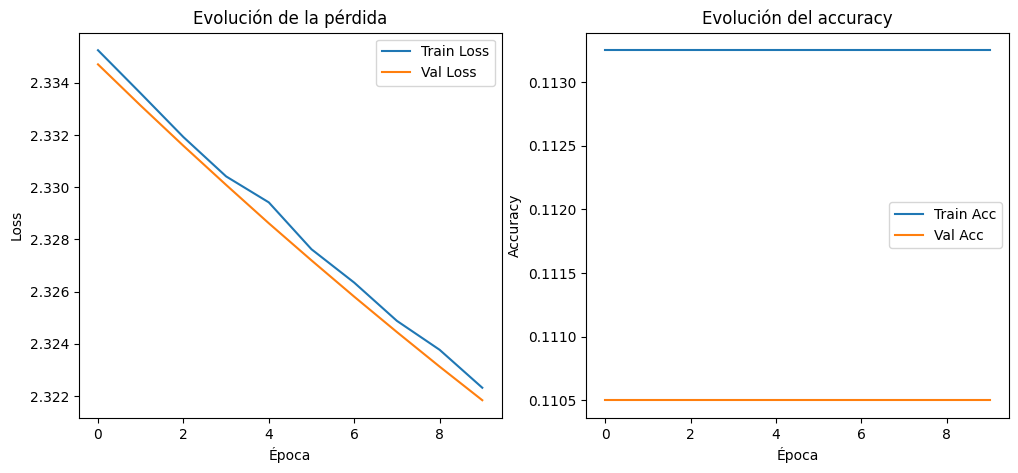

Epoch 1/10 - Loss: 2.3225 - Acc: 0.1207 - Val Loss: 2.3143 - Val Acc: 0.1310
Epoch 2/10 - Loss: 2.3162 - Acc: 0.1276 - Val Loss: 2.3080 - Val Acc: 0.1410
Epoch 3/10 - Loss: 2.3100 - Acc: 0.1368 - Val Loss: 2.3017 - Val Acc: 0.1490
Epoch 4/10 - Loss: 2.3038 - Acc: 0.1449 - Val Loss: 2.2955 - Val Acc: 0.1570
Epoch 5/10 - Loss: 2.2981 - Acc: 0.1537 - Val Loss: 2.2893 - Val Acc: 0.1640
Epoch 6/10 - Loss: 2.2915 - Acc: 0.1624 - Val Loss: 2.2832 - Val Acc: 0.1760
Epoch 7/10 - Loss: 2.2863 - Acc: 0.1710 - Val Loss: 2.2771 - Val Acc: 0.1830
Epoch 8/10 - Loss: 2.2801 - Acc: 0.1804 - Val Loss: 2.2711 - Val Acc: 0.1915
Epoch 9/10 - Loss: 2.2740 - Acc: 0.1884 - Val Loss: 2.2651 - Val Acc: 0.1975
Epoch 10/10 - Loss: 2.2686 - Acc: 0.1956 - Val Loss: 2.2592 - Val Acc: 0.2060


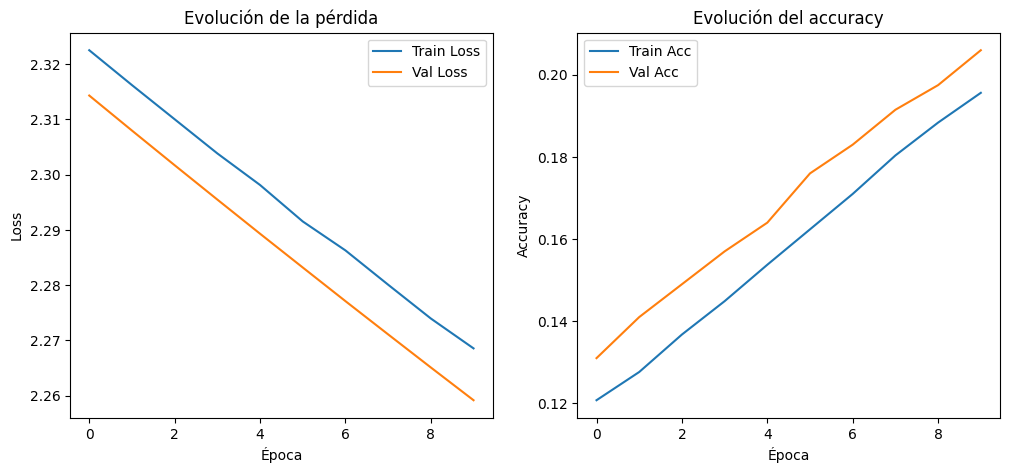

Epoch 1/10 - Loss: 2.3035 - Acc: 0.1353 - Val Loss: 2.2641 - Val Acc: 0.2105
Epoch 2/10 - Loss: 2.2446 - Acc: 0.2933 - Val Loss: 2.2178 - Val Acc: 0.3295
Epoch 3/10 - Loss: 2.1955 - Acc: 0.3852 - Val Loss: 2.1648 - Val Acc: 0.5795
Epoch 4/10 - Loss: 2.1378 - Acc: 0.5430 - Val Loss: 2.1013 - Val Acc: 0.5180
Epoch 5/10 - Loss: 2.0707 - Acc: 0.5416 - Val Loss: 2.0292 - Val Acc: 0.6595
Epoch 6/10 - Loss: 1.9917 - Acc: 0.6210 - Val Loss: 1.9424 - Val Acc: 0.6335
Epoch 7/10 - Loss: 1.9009 - Acc: 0.6452 - Val Loss: 1.8475 - Val Acc: 0.6305
Epoch 8/10 - Loss: 1.8018 - Acc: 0.6504 - Val Loss: 1.7456 - Val Acc: 0.6715
Epoch 9/10 - Loss: 1.6967 - Acc: 0.6740 - Val Loss: 1.6400 - Val Acc: 0.6805
Epoch 10/10 - Loss: 1.5913 - Acc: 0.6889 - Val Loss: 1.5365 - Val Acc: 0.6970


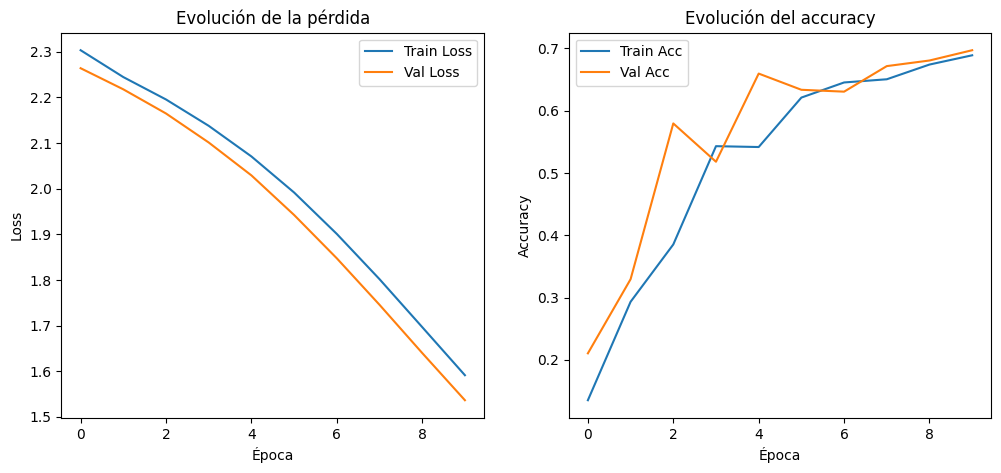

Epoch 1/10 - Loss: 2.0292 - Acc: 0.5294 - Val Loss: 1.6843 - Val Acc: 0.7165
Epoch 2/10 - Loss: 1.4243 - Acc: 0.7479 - Val Loss: 1.1557 - Val Acc: 0.7710
Epoch 3/10 - Loss: 1.0009 - Acc: 0.8034 - Val Loss: 0.8687 - Val Acc: 0.8185
Epoch 4/10 - Loss: 0.7709 - Acc: 0.8379 - Val Loss: 0.7156 - Val Acc: 0.8380
Epoch 5/10 - Loss: 0.6435 - Acc: 0.8569 - Val Loss: 0.6265 - Val Acc: 0.8515
Epoch 6/10 - Loss: 0.5639 - Acc: 0.8700 - Val Loss: 0.5700 - Val Acc: 0.8580
Epoch 7/10 - Loss: 0.5093 - Acc: 0.8760 - Val Loss: 0.5288 - Val Acc: 0.8690
Epoch 8/10 - Loss: 0.4719 - Acc: 0.8839 - Val Loss: 0.5013 - Val Acc: 0.8735
Epoch 9/10 - Loss: 0.4422 - Acc: 0.8882 - Val Loss: 0.4827 - Val Acc: 0.8760
Epoch 10/10 - Loss: 0.4207 - Acc: 0.8918 - Val Loss: 0.4634 - Val Acc: 0.8815


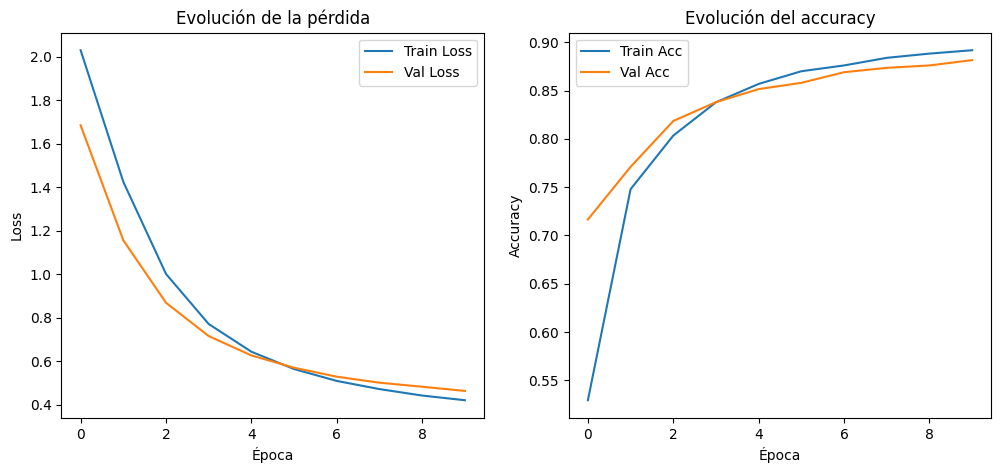

Epoch 1/10 - Loss: 2.3575 - Acc: 0.0910 - Val Loss: 2.3486 - Val Acc: 0.0830
Epoch 2/10 - Loss: 2.3265 - Acc: 0.1115 - Val Loss: 2.3233 - Val Acc: 0.1075
Epoch 3/10 - Loss: 2.3077 - Acc: 0.1185 - Val Loss: 2.3072 - Val Acc: 0.1030
Epoch 4/10 - Loss: 2.2965 - Acc: 0.1321 - Val Loss: 2.2957 - Val Acc: 0.1270
Epoch 5/10 - Loss: 2.2878 - Acc: 0.1669 - Val Loss: 2.2874 - Val Acc: 0.1790
Epoch 6/10 - Loss: 2.2816 - Acc: 0.2391 - Val Loss: 2.2809 - Val Acc: 0.2565
Epoch 7/10 - Loss: 2.2763 - Acc: 0.2619 - Val Loss: 2.2753 - Val Acc: 0.2460
Epoch 8/10 - Loss: 2.2715 - Acc: 0.2475 - Val Loss: 2.2705 - Val Acc: 0.2280
Epoch 9/10 - Loss: 2.2675 - Acc: 0.2254 - Val Loss: 2.2660 - Val Acc: 0.2265
Epoch 10/10 - Loss: 2.2634 - Acc: 0.2195 - Val Loss: 2.2617 - Val Acc: 0.2385


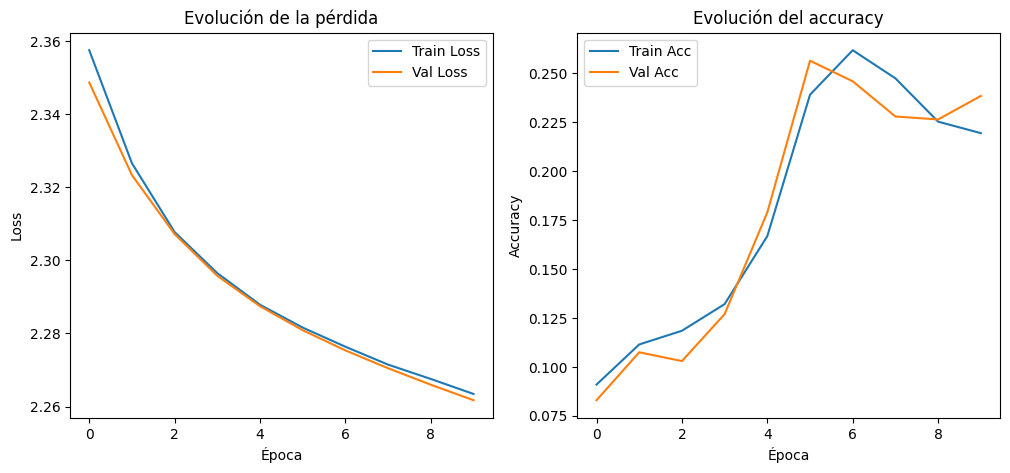

Epoch 1/10 - Loss: 2.2834 - Acc: 0.1399 - Val Loss: 2.2458 - Val Acc: 0.2225
Epoch 2/10 - Loss: 2.2196 - Acc: 0.2579 - Val Loss: 2.1827 - Val Acc: 0.3320
Epoch 3/10 - Loss: 2.1586 - Acc: 0.3484 - Val Loss: 2.1212 - Val Acc: 0.4120
Epoch 4/10 - Loss: 2.0988 - Acc: 0.4537 - Val Loss: 2.0605 - Val Acc: 0.5230
Epoch 5/10 - Loss: 2.0381 - Acc: 0.5489 - Val Loss: 1.9995 - Val Acc: 0.5890
Epoch 6/10 - Loss: 1.9782 - Acc: 0.6058 - Val Loss: 1.9382 - Val Acc: 0.6275
Epoch 7/10 - Loss: 1.9167 - Acc: 0.6444 - Val Loss: 1.8762 - Val Acc: 0.6575
Epoch 8/10 - Loss: 1.8557 - Acc: 0.6685 - Val Loss: 1.8138 - Val Acc: 0.6765
Epoch 9/10 - Loss: 1.7935 - Acc: 0.6884 - Val Loss: 1.7511 - Val Acc: 0.6885
Epoch 10/10 - Loss: 1.7309 - Acc: 0.7034 - Val Loss: 1.6886 - Val Acc: 0.6985


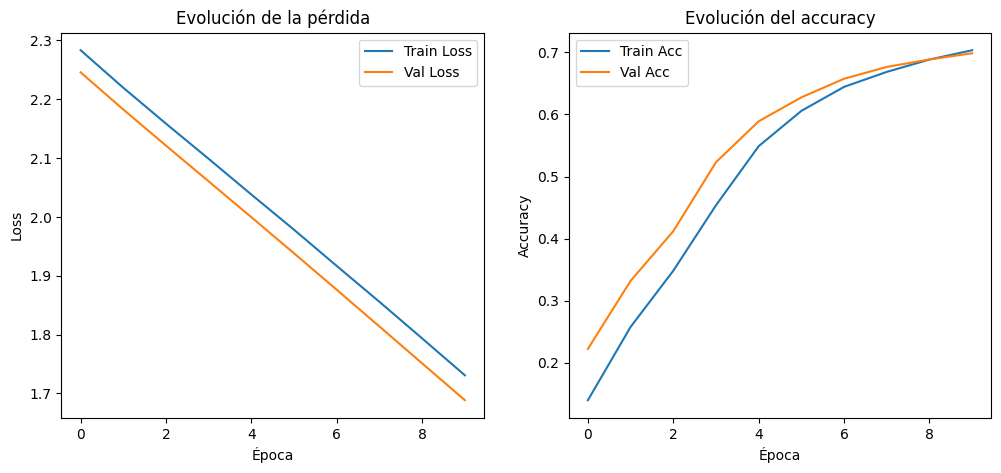

Epoch 1/10 - Loss: 2.3320 - Acc: 0.0788 - Val Loss: 2.3243 - Val Acc: 0.0835
Epoch 2/10 - Loss: 2.3296 - Acc: 0.0798 - Val Loss: 2.3222 - Val Acc: 0.0835
Epoch 3/10 - Loss: 2.3279 - Acc: 0.0809 - Val Loss: 2.3202 - Val Acc: 0.0850
Epoch 4/10 - Loss: 2.3261 - Acc: 0.0823 - Val Loss: 2.3183 - Val Acc: 0.0855
Epoch 5/10 - Loss: 2.3240 - Acc: 0.0835 - Val Loss: 2.3165 - Val Acc: 0.0865
Epoch 6/10 - Loss: 2.3221 - Acc: 0.0841 - Val Loss: 2.3148 - Val Acc: 0.0875
Epoch 7/10 - Loss: 2.3196 - Acc: 0.0861 - Val Loss: 2.3131 - Val Acc: 0.0885
Epoch 8/10 - Loss: 2.3183 - Acc: 0.0876 - Val Loss: 2.3116 - Val Acc: 0.0915
Epoch 9/10 - Loss: 2.3165 - Acc: 0.0895 - Val Loss: 2.3100 - Val Acc: 0.0930
Epoch 10/10 - Loss: 2.3148 - Acc: 0.0912 - Val Loss: 2.3086 - Val Acc: 0.0935


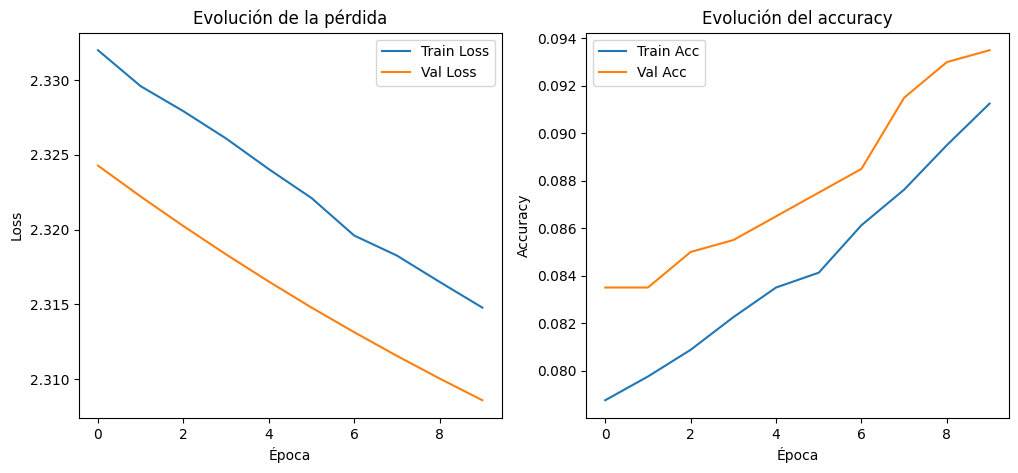

Epoch 1/10 - Loss: 2.3032 - Acc: 0.1250 - Val Loss: 2.3008 - Val Acc: 0.1375
Epoch 2/10 - Loss: 2.2957 - Acc: 0.1356 - Val Loss: 2.2934 - Val Acc: 0.1505
Epoch 3/10 - Loss: 2.2886 - Acc: 0.1462 - Val Loss: 2.2862 - Val Acc: 0.1590
Epoch 4/10 - Loss: 2.2814 - Acc: 0.1581 - Val Loss: 2.2790 - Val Acc: 0.1700
Epoch 5/10 - Loss: 2.2743 - Acc: 0.1703 - Val Loss: 2.2718 - Val Acc: 0.1780
Epoch 6/10 - Loss: 2.2671 - Acc: 0.1830 - Val Loss: 2.2647 - Val Acc: 0.1920
Epoch 7/10 - Loss: 2.2607 - Acc: 0.1928 - Val Loss: 2.2577 - Val Acc: 0.2015
Epoch 8/10 - Loss: 2.2535 - Acc: 0.2028 - Val Loss: 2.2506 - Val Acc: 0.2160
Epoch 9/10 - Loss: 2.2464 - Acc: 0.2154 - Val Loss: 2.2437 - Val Acc: 0.2285
Epoch 10/10 - Loss: 2.2397 - Acc: 0.2281 - Val Loss: 2.2367 - Val Acc: 0.2415


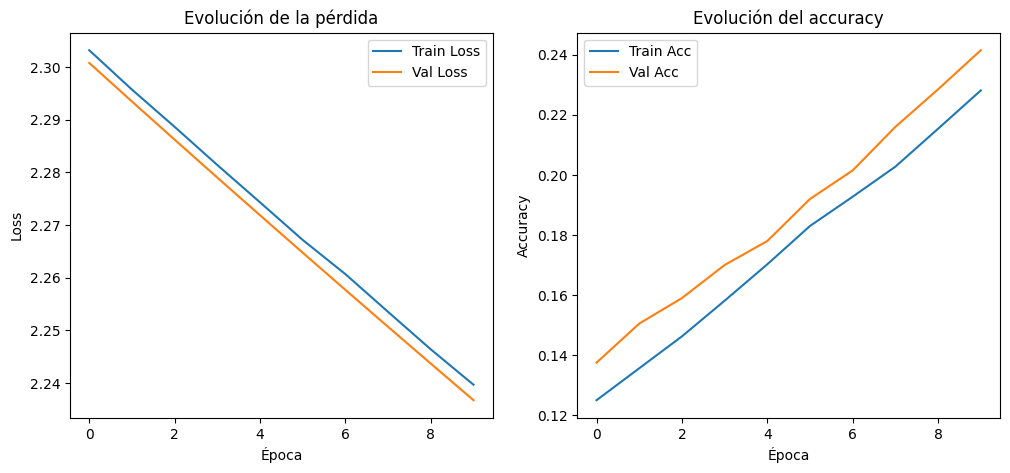

Epoch 1/10 - Loss: 2.2930 - Acc: 0.1689 - Val Loss: 2.2643 - Val Acc: 0.2025
Epoch 2/10 - Loss: 2.2453 - Acc: 0.2730 - Val Loss: 2.2164 - Val Acc: 0.3395
Epoch 3/10 - Loss: 2.1961 - Acc: 0.4105 - Val Loss: 2.1655 - Val Acc: 0.4935
Epoch 4/10 - Loss: 2.1375 - Acc: 0.5028 - Val Loss: 2.0997 - Val Acc: 0.5295
Epoch 5/10 - Loss: 2.0654 - Acc: 0.5621 - Val Loss: 2.0214 - Val Acc: 0.6175
Epoch 6/10 - Loss: 1.9801 - Acc: 0.5942 - Val Loss: 1.9285 - Val Acc: 0.6465
Epoch 7/10 - Loss: 1.8808 - Acc: 0.6241 - Val Loss: 1.8262 - Val Acc: 0.6120
Epoch 8/10 - Loss: 1.7725 - Acc: 0.6564 - Val Loss: 1.7119 - Val Acc: 0.6775
Epoch 9/10 - Loss: 1.6581 - Acc: 0.6816 - Val Loss: 1.5990 - Val Acc: 0.7015
Epoch 10/10 - Loss: 1.5445 - Acc: 0.6963 - Val Loss: 1.4889 - Val Acc: 0.7075


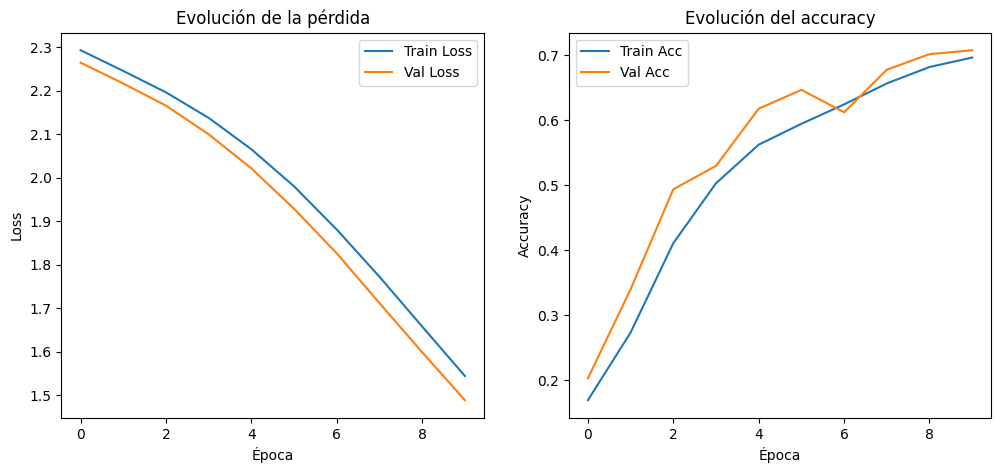

Epoch 1/10 - Loss: 2.0071 - Acc: 0.5553 - Val Loss: 1.6599 - Val Acc: 0.7465
Epoch 2/10 - Loss: 1.3894 - Acc: 0.7621 - Val Loss: 1.1192 - Val Acc: 0.7790
Epoch 3/10 - Loss: 0.9641 - Acc: 0.8075 - Val Loss: 0.8391 - Val Acc: 0.8120
Epoch 4/10 - Loss: 0.7451 - Acc: 0.8426 - Val Loss: 0.6954 - Val Acc: 0.8425
Epoch 5/10 - Loss: 0.6256 - Acc: 0.8562 - Val Loss: 0.6123 - Val Acc: 0.8585
Epoch 6/10 - Loss: 0.5510 - Acc: 0.8671 - Val Loss: 0.5597 - Val Acc: 0.8605
Epoch 7/10 - Loss: 0.5006 - Acc: 0.8735 - Val Loss: 0.5239 - Val Acc: 0.8635
Epoch 8/10 - Loss: 0.4652 - Acc: 0.8802 - Val Loss: 0.4959 - Val Acc: 0.8685
Epoch 9/10 - Loss: 0.4366 - Acc: 0.8859 - Val Loss: 0.4750 - Val Acc: 0.8745
Epoch 10/10 - Loss: 0.4153 - Acc: 0.8905 - Val Loss: 0.4598 - Val Acc: 0.8780


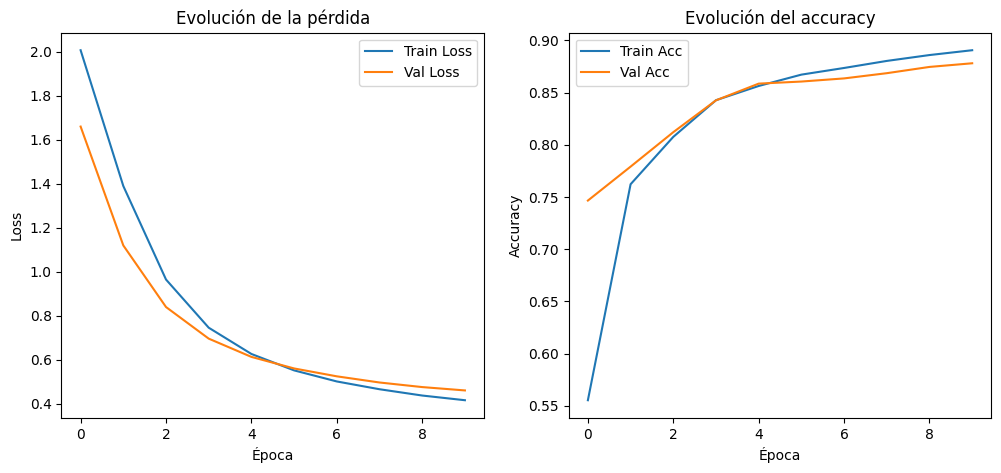

Epoch 1/10 - Loss: 2.3164 - Acc: 0.1066 - Val Loss: 2.3062 - Val Acc: 0.1085
Epoch 2/10 - Loss: 2.3021 - Acc: 0.1066 - Val Loss: 2.2967 - Val Acc: 0.1085
Epoch 3/10 - Loss: 2.2945 - Acc: 0.1089 - Val Loss: 2.2905 - Val Acc: 0.1570
Epoch 4/10 - Loss: 2.2892 - Acc: 0.1837 - Val Loss: 2.2857 - Val Acc: 0.1930
Epoch 5/10 - Loss: 2.2844 - Acc: 0.1856 - Val Loss: 2.2810 - Val Acc: 0.1605
Epoch 6/10 - Loss: 2.2799 - Acc: 0.1624 - Val Loss: 2.2765 - Val Acc: 0.1670
Epoch 7/10 - Loss: 2.2754 - Acc: 0.1666 - Val Loss: 2.2721 - Val Acc: 0.1880
Epoch 8/10 - Loss: 2.2709 - Acc: 0.1872 - Val Loss: 2.2676 - Val Acc: 0.2065
Epoch 9/10 - Loss: 2.2665 - Acc: 0.2140 - Val Loss: 2.2630 - Val Acc: 0.2305
Epoch 10/10 - Loss: 2.2619 - Acc: 0.2096 - Val Loss: 2.2584 - Val Acc: 0.2620


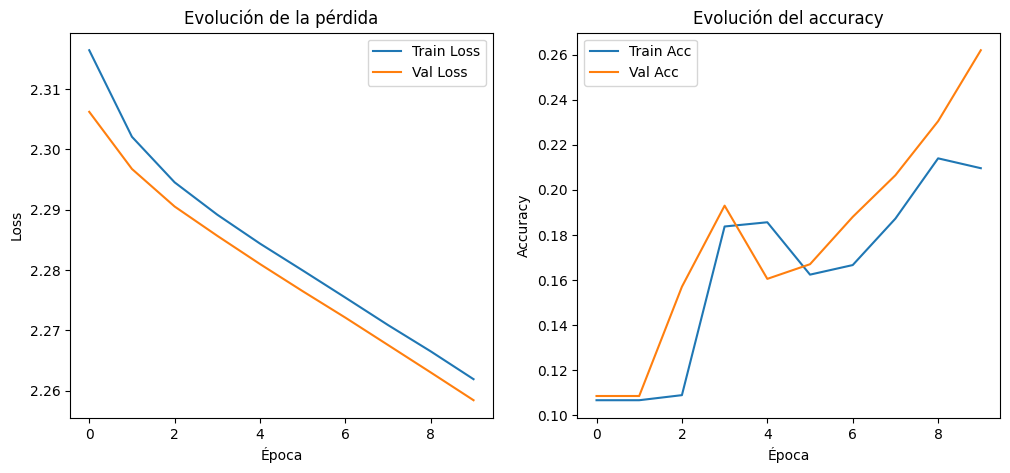

Epoch 1/10 - Loss: 2.2791 - Acc: 0.1689 - Val Loss: 2.2372 - Val Acc: 0.3060
Epoch 2/10 - Loss: 2.2113 - Acc: 0.3681 - Val Loss: 2.1706 - Val Acc: 0.4595
Epoch 3/10 - Loss: 2.1467 - Acc: 0.4734 - Val Loss: 2.1059 - Val Acc: 0.5415
Epoch 4/10 - Loss: 2.0825 - Acc: 0.5509 - Val Loss: 2.0419 - Val Acc: 0.6065
Epoch 5/10 - Loss: 2.0189 - Acc: 0.6096 - Val Loss: 1.9778 - Val Acc: 0.6505
Epoch 6/10 - Loss: 1.9546 - Acc: 0.6486 - Val Loss: 1.9131 - Val Acc: 0.6755
Epoch 7/10 - Loss: 1.8896 - Acc: 0.6780 - Val Loss: 1.8477 - Val Acc: 0.6920
Epoch 8/10 - Loss: 1.8242 - Acc: 0.6935 - Val Loss: 1.7821 - Val Acc: 0.7090
Epoch 9/10 - Loss: 1.7584 - Acc: 0.7084 - Val Loss: 1.7163 - Val Acc: 0.7220
Epoch 10/10 - Loss: 1.6926 - Acc: 0.7160 - Val Loss: 1.6510 - Val Acc: 0.7310


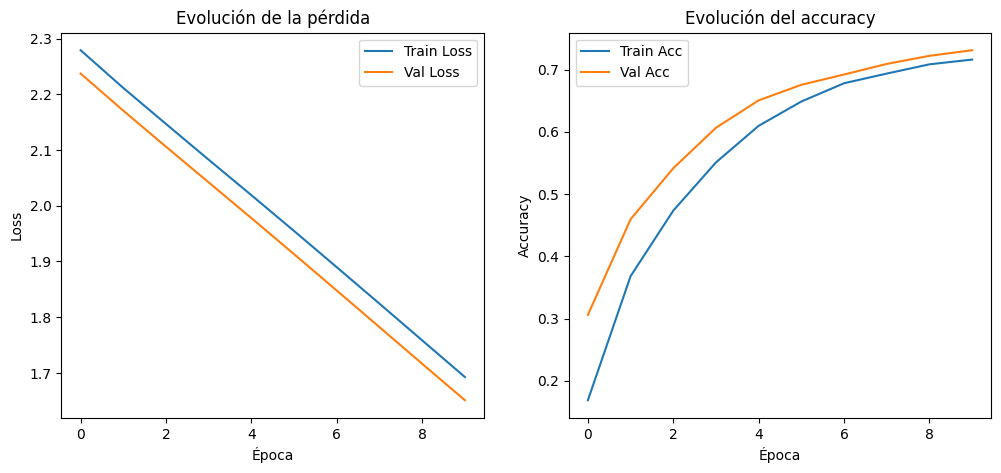

Epoch 1/10 - Loss: 2.3248 - Acc: 0.1041 - Val Loss: 2.3263 - Val Acc: 0.1025
Epoch 2/10 - Loss: 2.3217 - Acc: 0.1037 - Val Loss: 2.3228 - Val Acc: 0.1030
Epoch 3/10 - Loss: 2.3184 - Acc: 0.1032 - Val Loss: 2.3196 - Val Acc: 0.1030
Epoch 4/10 - Loss: 2.3151 - Acc: 0.1016 - Val Loss: 2.3167 - Val Acc: 0.1035
Epoch 5/10 - Loss: 2.3126 - Acc: 0.1010 - Val Loss: 2.3141 - Val Acc: 0.1030
Epoch 6/10 - Loss: 2.3102 - Acc: 0.1006 - Val Loss: 2.3117 - Val Acc: 0.1045
Epoch 7/10 - Loss: 2.3083 - Acc: 0.1001 - Val Loss: 2.3094 - Val Acc: 0.1050
Epoch 8/10 - Loss: 2.3060 - Acc: 0.0998 - Val Loss: 2.3075 - Val Acc: 0.1045
Epoch 9/10 - Loss: 2.3045 - Acc: 0.1000 - Val Loss: 2.3056 - Val Acc: 0.1045
Epoch 10/10 - Loss: 2.3029 - Acc: 0.0998 - Val Loss: 2.3038 - Val Acc: 0.1045


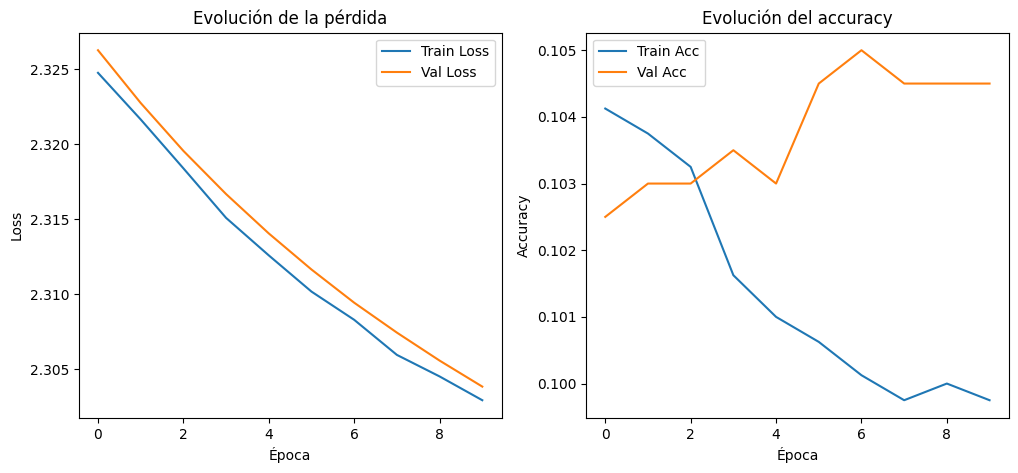

Epoch 1/10 - Loss: 2.3065 - Acc: 0.0916 - Val Loss: 2.3027 - Val Acc: 0.0910
Epoch 2/10 - Loss: 2.2990 - Acc: 0.1056 - Val Loss: 2.2950 - Val Acc: 0.1030
Epoch 3/10 - Loss: 2.2914 - Acc: 0.1195 - Val Loss: 2.2873 - Val Acc: 0.1195
Epoch 4/10 - Loss: 2.2842 - Acc: 0.1366 - Val Loss: 2.2798 - Val Acc: 0.1370
Epoch 5/10 - Loss: 2.2765 - Acc: 0.1542 - Val Loss: 2.2723 - Val Acc: 0.1565
Epoch 6/10 - Loss: 2.2695 - Acc: 0.1713 - Val Loss: 2.2648 - Val Acc: 0.1780
Epoch 7/10 - Loss: 2.2621 - Acc: 0.1915 - Val Loss: 2.2574 - Val Acc: 0.2010
Epoch 8/10 - Loss: 2.2548 - Acc: 0.2129 - Val Loss: 2.2501 - Val Acc: 0.2275
Epoch 9/10 - Loss: 2.2476 - Acc: 0.2360 - Val Loss: 2.2428 - Val Acc: 0.2480
Epoch 10/10 - Loss: 2.2408 - Acc: 0.2609 - Val Loss: 2.2355 - Val Acc: 0.2650


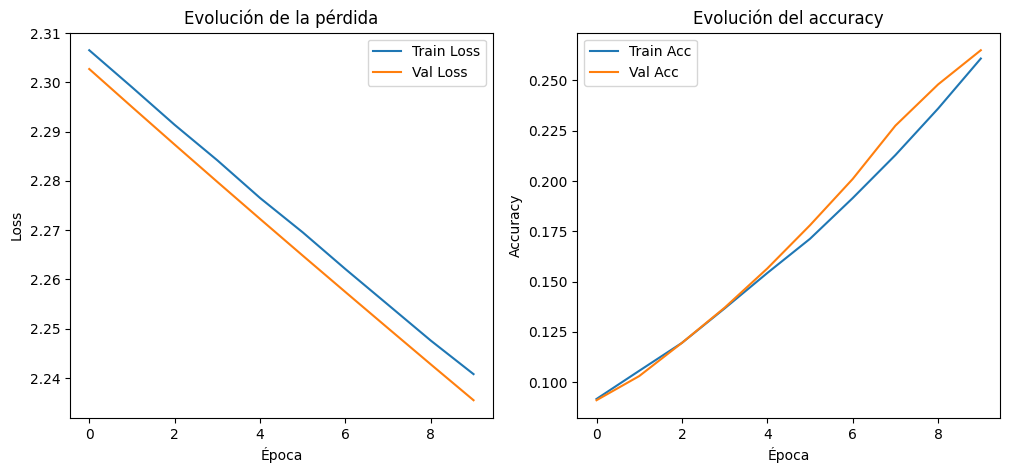

Epoch 1/10 - Loss: 2.3140 - Acc: 0.1066 - Val Loss: 2.3014 - Val Acc: 0.1085
Epoch 2/10 - Loss: 2.3007 - Acc: 0.1166 - Val Loss: 2.2979 - Val Acc: 0.1105
Epoch 3/10 - Loss: 2.2988 - Acc: 0.1133 - Val Loss: 2.2975 - Val Acc: 0.1105
Epoch 4/10 - Loss: 2.2976 - Acc: 0.1133 - Val Loss: 2.2960 - Val Acc: 0.1105
Epoch 5/10 - Loss: 2.2964 - Acc: 0.1133 - Val Loss: 2.2948 - Val Acc: 0.1105
Epoch 6/10 - Loss: 2.2959 - Acc: 0.1148 - Val Loss: 2.2932 - Val Acc: 0.1105
Epoch 7/10 - Loss: 2.2943 - Acc: 0.1133 - Val Loss: 2.2925 - Val Acc: 0.1105
Epoch 8/10 - Loss: 2.2934 - Acc: 0.1186 - Val Loss: 2.2911 - Val Acc: 0.1105
Epoch 9/10 - Loss: 2.2922 - Acc: 0.1140 - Val Loss: 2.2898 - Val Acc: 0.1105
Epoch 10/10 - Loss: 2.2906 - Acc: 0.1138 - Val Loss: 2.2884 - Val Acc: 0.1105


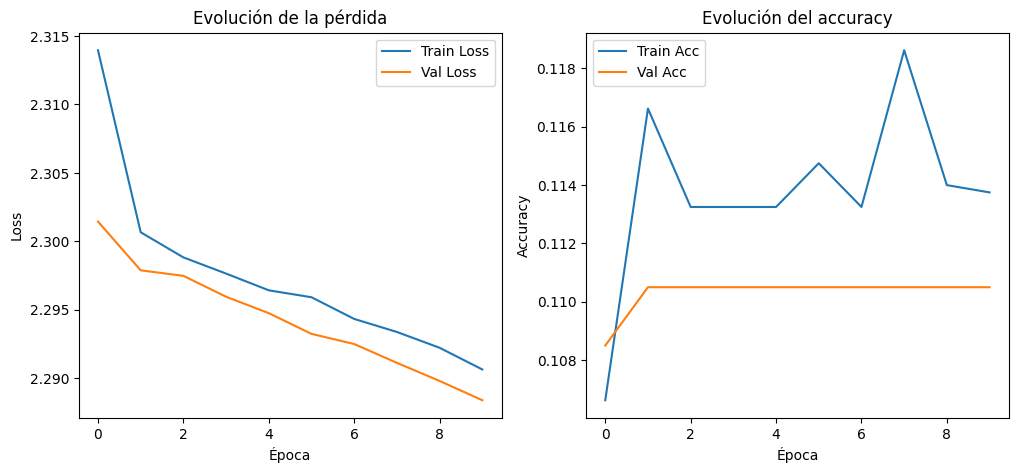

Epoch 1/10 - Loss: 2.2140 - Acc: 0.3016 - Val Loss: 2.0904 - Val Acc: 0.6005
Epoch 2/10 - Loss: 1.9169 - Acc: 0.6305 - Val Loss: 1.6713 - Val Acc: 0.6235
Epoch 3/10 - Loss: 1.4256 - Acc: 0.6562 - Val Loss: 1.1879 - Val Acc: 0.7075
Epoch 4/10 - Loss: 1.0223 - Acc: 0.7428 - Val Loss: 0.9072 - Val Acc: 0.7510
Epoch 5/10 - Loss: 0.8002 - Acc: 0.7891 - Val Loss: 0.7624 - Val Acc: 0.7970
Epoch 6/10 - Loss: 0.6737 - Acc: 0.8211 - Val Loss: 0.6689 - Val Acc: 0.8160
Epoch 7/10 - Loss: 0.5883 - Acc: 0.8431 - Val Loss: 0.6073 - Val Acc: 0.8385
Epoch 8/10 - Loss: 0.5285 - Acc: 0.8582 - Val Loss: 0.5589 - Val Acc: 0.8565
Epoch 9/10 - Loss: 0.4818 - Acc: 0.8708 - Val Loss: 0.5234 - Val Acc: 0.8595
Epoch 10/10 - Loss: 0.4476 - Acc: 0.8770 - Val Loss: 0.4943 - Val Acc: 0.8690


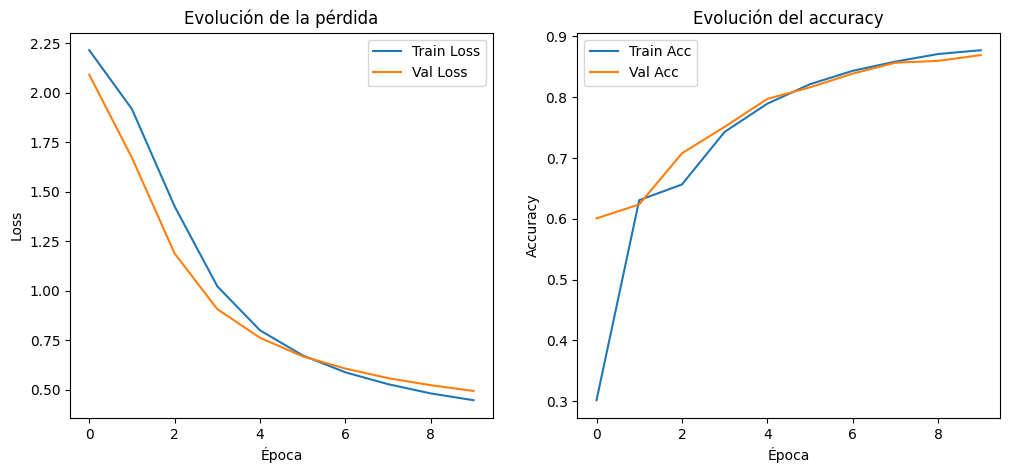

Epoch 1/10 - Loss: 2.3775 - Acc: 0.0999 - Val Loss: 2.3616 - Val Acc: 0.0905
Epoch 2/10 - Loss: 2.3612 - Acc: 0.0999 - Val Loss: 2.3474 - Val Acc: 0.0905
Epoch 3/10 - Loss: 2.3473 - Acc: 0.0999 - Val Loss: 2.3365 - Val Acc: 0.0905
Epoch 4/10 - Loss: 2.3374 - Acc: 0.0999 - Val Loss: 2.3278 - Val Acc: 0.0905
Epoch 5/10 - Loss: 2.3295 - Acc: 0.0999 - Val Loss: 2.3210 - Val Acc: 0.0905
Epoch 6/10 - Loss: 2.3224 - Acc: 0.0999 - Val Loss: 2.3158 - Val Acc: 0.0905
Epoch 7/10 - Loss: 2.3173 - Acc: 0.0999 - Val Loss: 2.3117 - Val Acc: 0.0905
Epoch 8/10 - Loss: 2.3136 - Acc: 0.1004 - Val Loss: 2.3086 - Val Acc: 0.0920
Epoch 9/10 - Loss: 2.3106 - Acc: 0.0990 - Val Loss: 2.3062 - Val Acc: 0.1040
Epoch 10/10 - Loss: 2.3082 - Acc: 0.1044 - Val Loss: 2.3043 - Val Acc: 0.1085


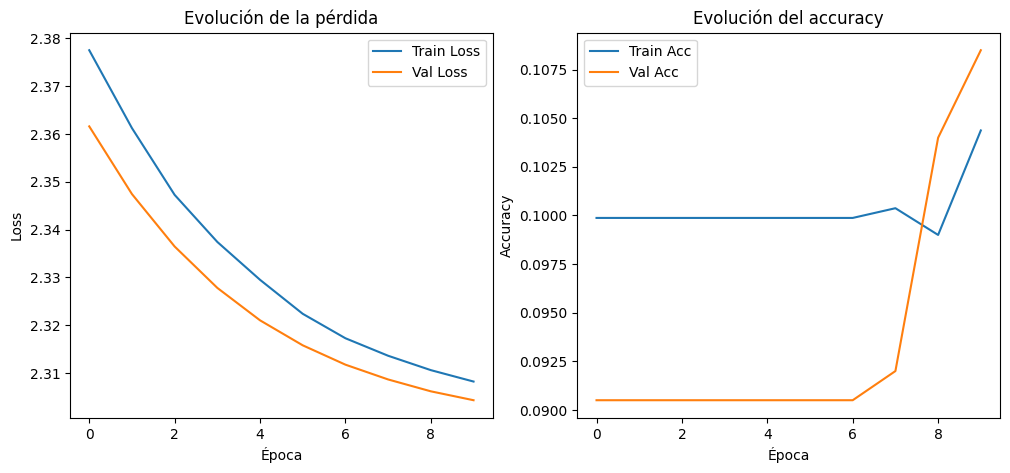

Epoch 1/10 - Loss: 2.2987 - Acc: 0.1409 - Val Loss: 2.2851 - Val Acc: 0.1755
Epoch 2/10 - Loss: 2.2743 - Acc: 0.1936 - Val Loss: 2.2602 - Val Acc: 0.2300
Epoch 3/10 - Loss: 2.2500 - Acc: 0.2661 - Val Loss: 2.2354 - Val Acc: 0.3070
Epoch 4/10 - Loss: 2.2258 - Acc: 0.3259 - Val Loss: 2.2100 - Val Acc: 0.3695
Epoch 5/10 - Loss: 2.2006 - Acc: 0.3800 - Val Loss: 2.1837 - Val Acc: 0.4170
Epoch 6/10 - Loss: 2.1740 - Acc: 0.4190 - Val Loss: 2.1560 - Val Acc: 0.4510
Epoch 7/10 - Loss: 2.1462 - Acc: 0.4521 - Val Loss: 2.1266 - Val Acc: 0.4760
Epoch 8/10 - Loss: 2.1161 - Acc: 0.4799 - Val Loss: 2.0951 - Val Acc: 0.5035
Epoch 9/10 - Loss: 2.0840 - Acc: 0.5070 - Val Loss: 2.0612 - Val Acc: 0.5260
Epoch 10/10 - Loss: 2.0498 - Acc: 0.5261 - Val Loss: 2.0249 - Val Acc: 0.5450


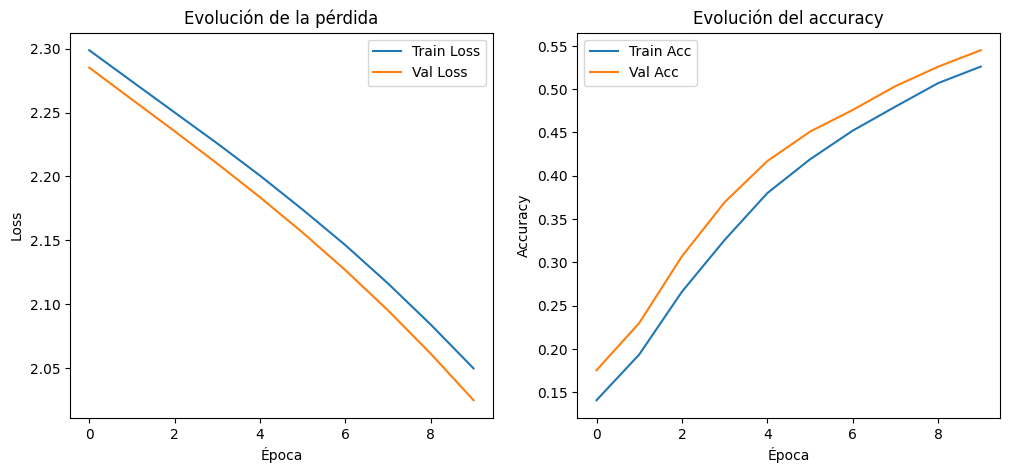

Epoch 1/10 - Loss: 2.3340 - Acc: 0.0877 - Val Loss: 2.3413 - Val Acc: 0.0805
Epoch 2/10 - Loss: 2.3329 - Acc: 0.0877 - Val Loss: 2.3402 - Val Acc: 0.0805
Epoch 3/10 - Loss: 2.3321 - Acc: 0.0877 - Val Loss: 2.3391 - Val Acc: 0.0805
Epoch 4/10 - Loss: 2.3307 - Acc: 0.0877 - Val Loss: 2.3380 - Val Acc: 0.0805
Epoch 5/10 - Loss: 2.3305 - Acc: 0.0877 - Val Loss: 2.3369 - Val Acc: 0.0805
Epoch 6/10 - Loss: 2.3288 - Acc: 0.0877 - Val Loss: 2.3359 - Val Acc: 0.0805
Epoch 7/10 - Loss: 2.3275 - Acc: 0.0877 - Val Loss: 2.3349 - Val Acc: 0.0805
Epoch 8/10 - Loss: 2.3270 - Acc: 0.0877 - Val Loss: 2.3340 - Val Acc: 0.0805
Epoch 9/10 - Loss: 2.3269 - Acc: 0.0877 - Val Loss: 2.3330 - Val Acc: 0.0805
Epoch 10/10 - Loss: 2.3260 - Acc: 0.0877 - Val Loss: 2.3321 - Val Acc: 0.0805


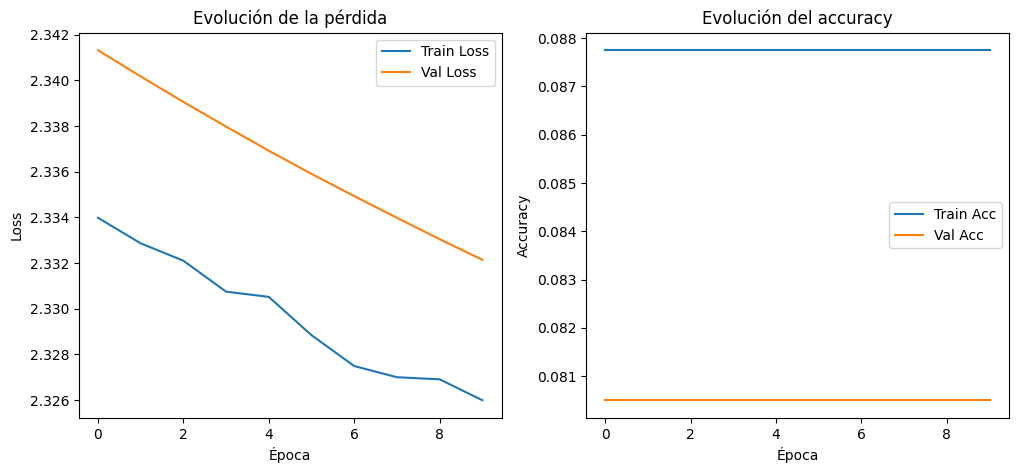

Epoch 1/10 - Loss: 2.3037 - Acc: 0.1265 - Val Loss: 2.2992 - Val Acc: 0.1330
Epoch 2/10 - Loss: 2.3013 - Acc: 0.1306 - Val Loss: 2.2968 - Val Acc: 0.1370
Epoch 3/10 - Loss: 2.2988 - Acc: 0.1344 - Val Loss: 2.2944 - Val Acc: 0.1410
Epoch 4/10 - Loss: 2.2965 - Acc: 0.1395 - Val Loss: 2.2920 - Val Acc: 0.1455
Epoch 5/10 - Loss: 2.2942 - Acc: 0.1439 - Val Loss: 2.2897 - Val Acc: 0.1490
Epoch 6/10 - Loss: 2.2916 - Acc: 0.1489 - Val Loss: 2.2873 - Val Acc: 0.1545
Epoch 7/10 - Loss: 2.2894 - Acc: 0.1534 - Val Loss: 2.2849 - Val Acc: 0.1590
Epoch 8/10 - Loss: 2.2867 - Acc: 0.1575 - Val Loss: 2.2826 - Val Acc: 0.1655
Epoch 9/10 - Loss: 2.2846 - Acc: 0.1621 - Val Loss: 2.2802 - Val Acc: 0.1720
Epoch 10/10 - Loss: 2.2826 - Acc: 0.1663 - Val Loss: 2.2779 - Val Acc: 0.1785


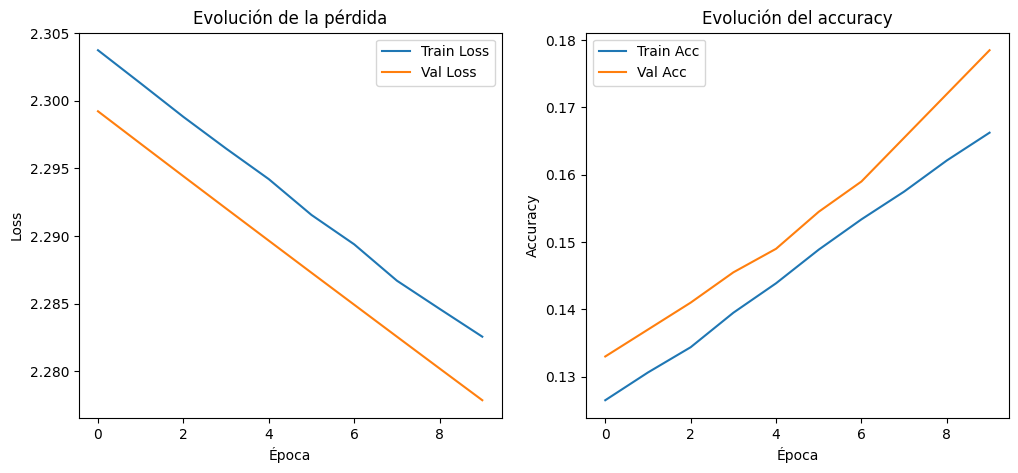

Epoch 1/10 - Loss: 2.3179 - Acc: 0.0980 - Val Loss: 2.3024 - Val Acc: 0.1085
Epoch 2/10 - Loss: 2.3022 - Acc: 0.1087 - Val Loss: 2.3007 - Val Acc: 0.1105
Epoch 3/10 - Loss: 2.3012 - Acc: 0.1133 - Val Loss: 2.2998 - Val Acc: 0.1105
Epoch 4/10 - Loss: 2.3012 - Acc: 0.1133 - Val Loss: 2.2996 - Val Acc: 0.1105
Epoch 5/10 - Loss: 2.3012 - Acc: 0.1135 - Val Loss: 2.2997 - Val Acc: 0.1105
Epoch 6/10 - Loss: 2.3015 - Acc: 0.1133 - Val Loss: 2.3000 - Val Acc: 0.1105
Epoch 7/10 - Loss: 2.3011 - Acc: 0.1133 - Val Loss: 2.3001 - Val Acc: 0.1105
Epoch 8/10 - Loss: 2.3012 - Acc: 0.1133 - Val Loss: 2.2999 - Val Acc: 0.1105
Epoch 9/10 - Loss: 2.3015 - Acc: 0.1133 - Val Loss: 2.3002 - Val Acc: 0.1105
Epoch 10/10 - Loss: 2.3013 - Acc: 0.1135 - Val Loss: 2.3003 - Val Acc: 0.1105


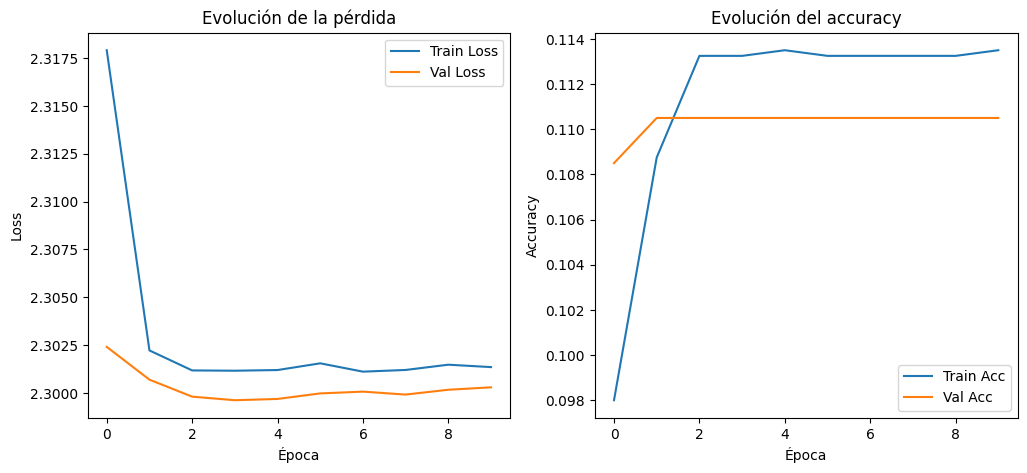

Epoch 1/10 - Loss: 2.2635 - Acc: 0.2346 - Val Loss: 2.2026 - Val Acc: 0.3155
Epoch 2/10 - Loss: 2.1046 - Acc: 0.3841 - Val Loss: 1.9434 - Val Acc: 0.4570
Epoch 3/10 - Loss: 1.7474 - Acc: 0.4875 - Val Loss: 1.5196 - Val Acc: 0.5300
Epoch 4/10 - Loss: 1.3407 - Acc: 0.5950 - Val Loss: 1.1761 - Val Acc: 0.6580
Epoch 5/10 - Loss: 1.0364 - Acc: 0.7171 - Val Loss: 0.9296 - Val Acc: 0.7545
Epoch 6/10 - Loss: 0.8089 - Acc: 0.7833 - Val Loss: 0.7743 - Val Acc: 0.7825
Epoch 7/10 - Loss: 0.6798 - Acc: 0.8093 - Val Loss: 0.6957 - Val Acc: 0.8005
Epoch 8/10 - Loss: 0.6026 - Acc: 0.8320 - Val Loss: 0.6388 - Val Acc: 0.8240
Epoch 9/10 - Loss: 0.5476 - Acc: 0.8475 - Val Loss: 0.6060 - Val Acc: 0.8320
Epoch 10/10 - Loss: 0.5047 - Acc: 0.8582 - Val Loss: 0.5620 - Val Acc: 0.8485


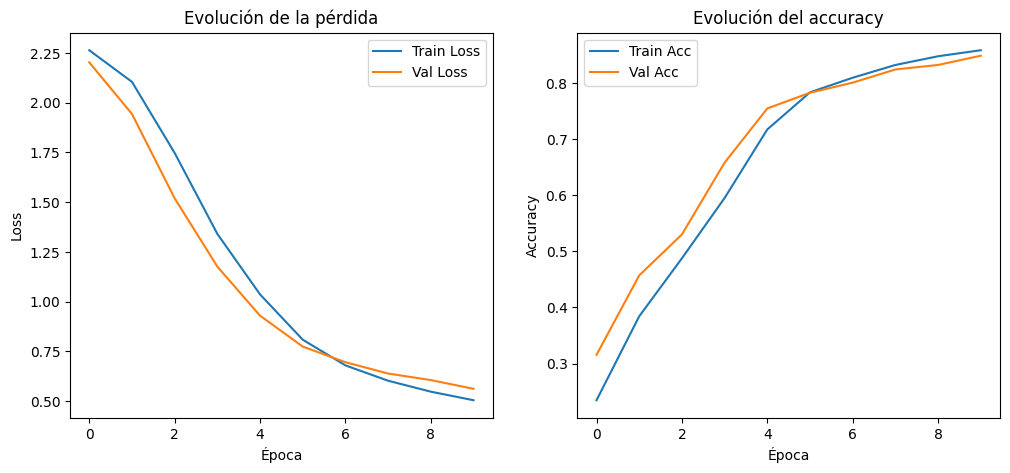

Epoch 1/10 - Loss: 2.3114 - Acc: 0.1047 - Val Loss: 2.3087 - Val Acc: 0.1105
Epoch 2/10 - Loss: 2.3089 - Acc: 0.1133 - Val Loss: 2.3066 - Val Acc: 0.1105
Epoch 3/10 - Loss: 2.3069 - Acc: 0.1133 - Val Loss: 2.3050 - Val Acc: 0.1105
Epoch 4/10 - Loss: 2.3054 - Acc: 0.1133 - Val Loss: 2.3038 - Val Acc: 0.1105
Epoch 5/10 - Loss: 2.3047 - Acc: 0.1133 - Val Loss: 2.3029 - Val Acc: 0.1105
Epoch 6/10 - Loss: 2.3037 - Acc: 0.1133 - Val Loss: 2.3022 - Val Acc: 0.1105
Epoch 7/10 - Loss: 2.3029 - Acc: 0.1133 - Val Loss: 2.3016 - Val Acc: 0.1105
Epoch 8/10 - Loss: 2.3026 - Acc: 0.1133 - Val Loss: 2.3012 - Val Acc: 0.1105
Epoch 9/10 - Loss: 2.3019 - Acc: 0.1133 - Val Loss: 2.3009 - Val Acc: 0.1105
Epoch 10/10 - Loss: 2.3016 - Acc: 0.1133 - Val Loss: 2.3006 - Val Acc: 0.1105


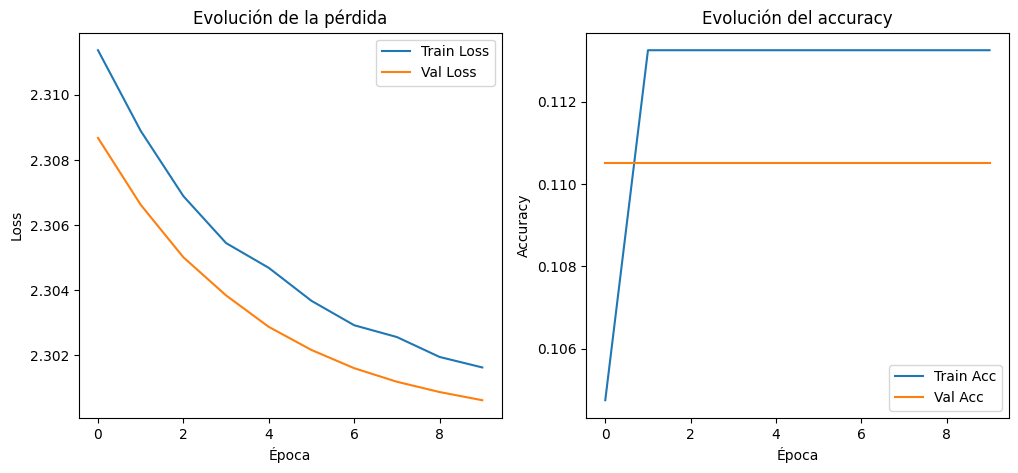

Epoch 1/10 - Loss: 2.3045 - Acc: 0.1251 - Val Loss: 2.3002 - Val Acc: 0.1595
Epoch 2/10 - Loss: 2.2963 - Acc: 0.1670 - Val Loss: 2.2921 - Val Acc: 0.1930
Epoch 3/10 - Loss: 2.2884 - Acc: 0.1946 - Val Loss: 2.2841 - Val Acc: 0.2195
Epoch 4/10 - Loss: 2.2806 - Acc: 0.2129 - Val Loss: 2.2759 - Val Acc: 0.2345
Epoch 5/10 - Loss: 2.2724 - Acc: 0.2275 - Val Loss: 2.2675 - Val Acc: 0.2460
Epoch 6/10 - Loss: 2.2636 - Acc: 0.2380 - Val Loss: 2.2587 - Val Acc: 0.2540
Epoch 7/10 - Loss: 2.2552 - Acc: 0.2466 - Val Loss: 2.2495 - Val Acc: 0.2625
Epoch 8/10 - Loss: 2.2459 - Acc: 0.2562 - Val Loss: 2.2397 - Val Acc: 0.2685
Epoch 9/10 - Loss: 2.2358 - Acc: 0.2631 - Val Loss: 2.2291 - Val Acc: 0.2755
Epoch 10/10 - Loss: 2.2248 - Acc: 0.2732 - Val Loss: 2.2176 - Val Acc: 0.2865


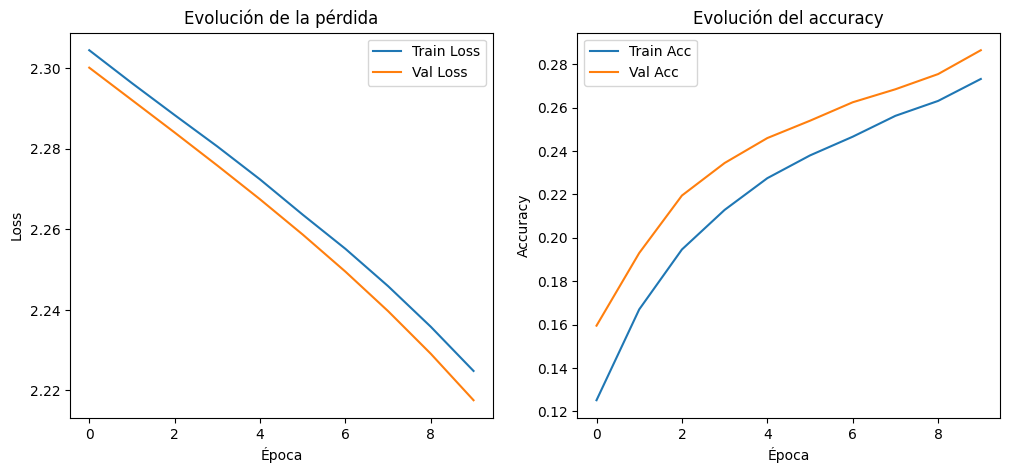

Epoch 1/10 - Loss: 2.3588 - Acc: 0.1066 - Val Loss: 2.3624 - Val Acc: 0.1085
Epoch 2/10 - Loss: 2.3566 - Acc: 0.1066 - Val Loss: 2.3609 - Val Acc: 0.1085
Epoch 3/10 - Loss: 2.3551 - Acc: 0.1066 - Val Loss: 2.3593 - Val Acc: 0.1085
Epoch 4/10 - Loss: 2.3541 - Acc: 0.1066 - Val Loss: 2.3578 - Val Acc: 0.1085
Epoch 5/10 - Loss: 2.3529 - Acc: 0.1066 - Val Loss: 2.3563 - Val Acc: 0.1085
Epoch 6/10 - Loss: 2.3514 - Acc: 0.1066 - Val Loss: 2.3549 - Val Acc: 0.1085
Epoch 7/10 - Loss: 2.3498 - Acc: 0.1066 - Val Loss: 2.3535 - Val Acc: 0.1085
Epoch 8/10 - Loss: 2.3489 - Acc: 0.1066 - Val Loss: 2.3521 - Val Acc: 0.1085
Epoch 9/10 - Loss: 2.3467 - Acc: 0.1066 - Val Loss: 2.3508 - Val Acc: 0.1085
Epoch 10/10 - Loss: 2.3460 - Acc: 0.1066 - Val Loss: 2.3495 - Val Acc: 0.1085


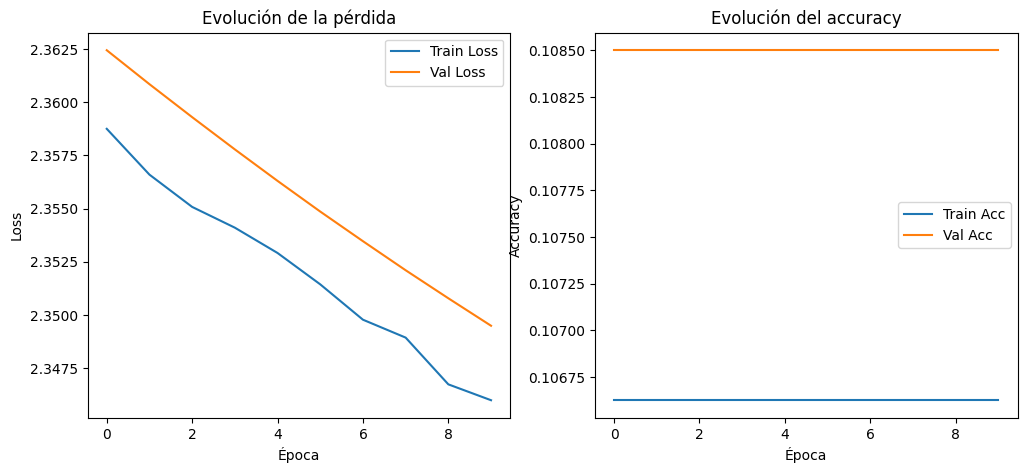

Epoch 1/10 - Loss: 2.3061 - Acc: 0.1029 - Val Loss: 2.3060 - Val Acc: 0.1040
Epoch 2/10 - Loss: 2.3057 - Acc: 0.1032 - Val Loss: 2.3053 - Val Acc: 0.1060
Epoch 3/10 - Loss: 2.3049 - Acc: 0.1041 - Val Loss: 2.3046 - Val Acc: 0.1065
Epoch 4/10 - Loss: 2.3043 - Acc: 0.1041 - Val Loss: 2.3038 - Val Acc: 0.1065
Epoch 5/10 - Loss: 2.3034 - Acc: 0.1047 - Val Loss: 2.3031 - Val Acc: 0.1070
Epoch 6/10 - Loss: 2.3029 - Acc: 0.1056 - Val Loss: 2.3024 - Val Acc: 0.1085
Epoch 7/10 - Loss: 2.3021 - Acc: 0.1059 - Val Loss: 2.3017 - Val Acc: 0.1100
Epoch 8/10 - Loss: 2.3012 - Acc: 0.1064 - Val Loss: 2.3009 - Val Acc: 0.1110
Epoch 9/10 - Loss: 2.3008 - Acc: 0.1074 - Val Loss: 2.3002 - Val Acc: 0.1125
Epoch 10/10 - Loss: 2.3001 - Acc: 0.1087 - Val Loss: 2.2995 - Val Acc: 0.1140


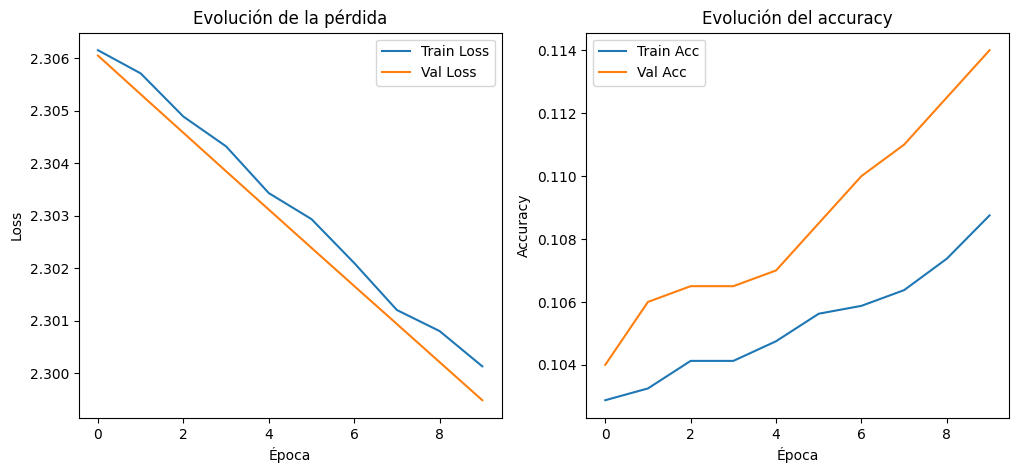

hidden  learning_rate      act  val_acc  val_loss
7           [64]          0.100   linear   0.8815  0.463388
13         [128]          0.100   linear   0.8780  0.459808
1           [32]          0.100   linear   0.8740  0.470901
19      [64, 32]          0.100   linear   0.8690  0.494272
25  [32, 32, 32]          0.100   linear   0.8485  0.561983
15         [128]          0.010   linear   0.7310  1.650996
12         [128]          0.100  sigmoid   0.7075  1.488894
9           [64]          0.010   linear   0.6985  1.688564
6           [64]          0.100  sigmoid   0.6970  1.536507
0           [32]          0.100  sigmoid   0.6920  1.622415
3           [32]          0.010   linear   0.6780  1.721035
21      [64, 32]          0.010   linear   0.5450  2.024883
27  [32, 32, 32]          0.010   linear   0.2865  2.217566
17         [128]          0.001   linear   0.2650  2.235492
14         [128]          0.010  sigmoid   0.2620  2.258425
8           [64]          0.010  sigmoid   0.2565  2.261719
11          [64]          0.001   linear   0.2415  2.236716
5           [32]          0.001   linear   0.2060  2.259197
23      [64, 32]          0.001   linear   0.1785  2.277867
2           [32]          0.010  sigmoid   0.1300  2.269536
29  [32, 32, 32]          0.001   linear   0.1140  2.299482
4           [32]          0.001  sigmoid   0.1105  2.321839
18      [64, 32]          0.100  sigmoid   0.1105  2.288395
26  [32, 32, 32]          0.010  sigmoid   0.1105  2.300618
24  [32, 32, 32]          0.100  sigmoid   0.1105  2.299618
28  [32, 32, 32]          0.001  sigmoid   0.1085  2.349495
20      [64, 32]          0.010  sigmoid   0.1085  2.304288
16         [128]          0.001  sigmoid   0.1050  2.303850
10          [64]          0.001  sigmoid   0.0935  2.308588
22      [64, 32]          0.001  sigmoid   0.0805  2.332141

In [ ]:
output_layer_size = 10
batch_size = 512  # Tamaño del batch para PyTorch
num_workers = 8  # Número de workers para DataLoader

pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size],
        learning_rate=lr,
        activation=act,
        num_workers=num_workers,
    )
    print(f"Entrenando con f(x) activación={act}, capas={hs}, lr={lr}")
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        batch_size=batch_size,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)

### Prueba con dataset CIFAR-10

In [33]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar10(f"data/CIFAR-10")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)  # epochs puede ajustarse

Epoch 1/10 - Loss: 2.2816 - Acc: 0.1507 - Val Loss: 2.2576 - Val Acc: 0.2229
Epoch 2/10 - Loss: 2.2407 - Acc: 0.2275 - Val Loss: 2.2233 - Val Acc: 0.2298
Epoch 3/10 - Loss: 2.2042 - Acc: 0.2415 - Val Loss: 2.1889 - Val Acc: 0.2273
Epoch 4/10 - Loss: 2.1696 - Acc: 0.2539 - Val Loss: 2.1571 - Val Acc: 0.2589
Epoch 5/10 - Loss: 2.1360 - Acc: 0.2738 - Val Loss: 2.1260 - Val Acc: 0.2710
Epoch 6/10 - Loss: 2.1061 - Acc: 0.2815 - Val Loss: 2.1003 - Val Acc: 0.2914
Epoch 7/10 - Loss: 2.0798 - Acc: 0.2906 - Val Loss: 2.0799 - Val Acc: 0.2661
Epoch 8/10 - Loss: 2.0572 - Acc: 0.2964 - Val Loss: 2.0593 - Val Acc: 0.2919
Epoch 9/10 - Loss: 2.0367 - Acc: 0.3017 - Val Loss: 2.0374 - Val Acc: 0.3004
Epoch 10/10 - Loss: 2.0170 - Acc: 0.3084 - Val Loss: 2.0230 - Val Acc: 0.2937


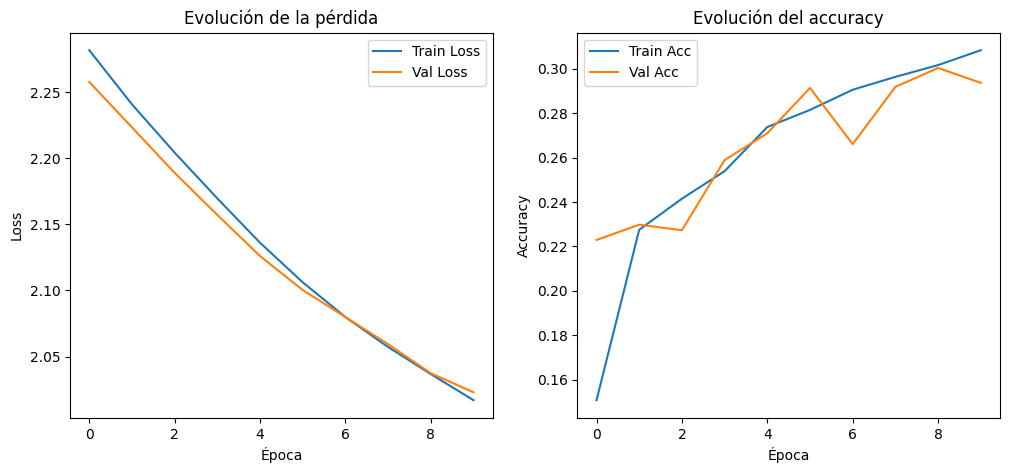

Epoch 1/10 - Loss: 64.8026 - Acc: 0.1094 - Val Loss: 1407.7094 - Val Acc: 0.1000
Epoch 2/10 - Loss: 62394385507.5946 - Acc: 0.1000 - Val Loss: 2613958672384.0000 - Val Acc: 0.1000
Epoch 3/10 - Loss: 255652055944645640192.0000 - Acc: 0.0989 - Val Loss: 7836606751096250040320.0000 - Val Acc: 0.1000
Epoch 4/10 - Loss: 993273623398562134667196104704.0000 - Acc: 0.1004 - Val Loss: 33275472831800055088311095525376.0000 - Val Acc: 0.1000
Epoch 5/10 - Loss: nan - Acc: 0.0949 - Val Loss: nan - Val Acc: 0.1000
Epoch 6/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 7/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 8/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 9/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 10/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000


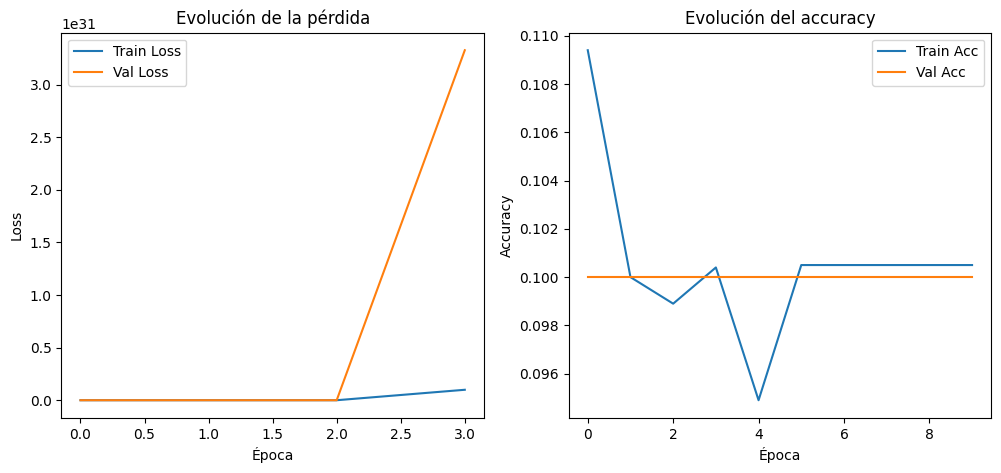

Epoch 1/10 - Loss: 2.3394 - Acc: 0.1025 - Val Loss: 2.3193 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3136 - Acc: 0.1031 - Val Loss: 2.3059 - Val Acc: 0.0999
Epoch 3/10 - Loss: 2.3038 - Acc: 0.1024 - Val Loss: 2.2994 - Val Acc: 0.1074
Epoch 4/10 - Loss: 2.2982 - Acc: 0.1183 - Val Loss: 2.2950 - Val Acc: 0.1248
Epoch 5/10 - Loss: 2.2940 - Acc: 0.1313 - Val Loss: 2.2916 - Val Acc: 0.1342
Epoch 6/10 - Loss: 2.2903 - Acc: 0.1408 - Val Loss: 2.2884 - Val Acc: 0.1361
Epoch 7/10 - Loss: 2.2868 - Acc: 0.1378 - Val Loss: 2.2853 - Val Acc: 0.1406
Epoch 8/10 - Loss: 2.2837 - Acc: 0.1454 - Val Loss: 2.2823 - Val Acc: 0.1414
Epoch 9/10 - Loss: 2.2804 - Acc: 0.1448 - Val Loss: 2.2792 - Val Acc: 0.1459
Epoch 10/10 - Loss: 2.2770 - Acc: 0.1536 - Val Loss: 2.2761 - Val Acc: 0.1491


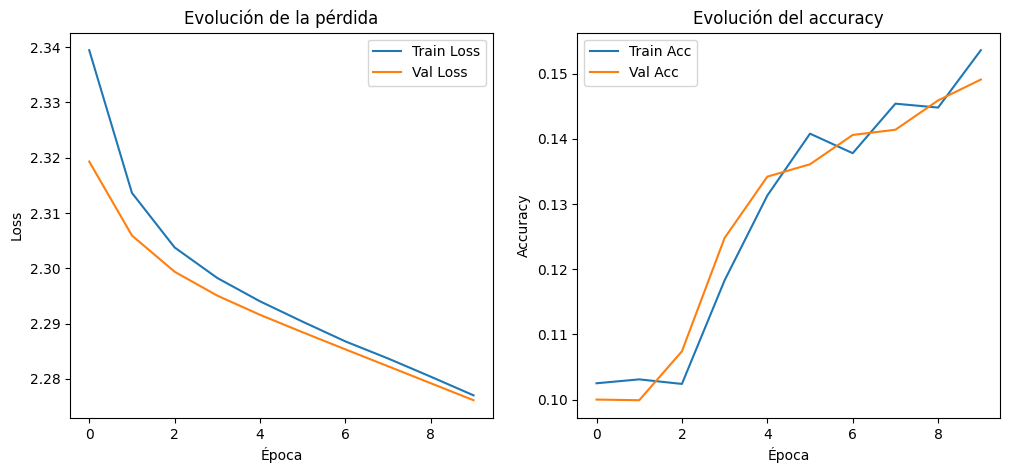

Epoch 1/10 - Loss: 2.2873 - Acc: 0.1127 - Val Loss: 2.2630 - Val Acc: 0.1418
Epoch 2/10 - Loss: 2.2445 - Acc: 0.1530 - Val Loss: 2.2289 - Val Acc: 0.1952
Epoch 3/10 - Loss: 2.2086 - Acc: 0.1938 - Val Loss: 2.1947 - Val Acc: 0.2052
Epoch 4/10 - Loss: 2.1773 - Acc: 0.2190 - Val Loss: 2.1658 - Val Acc: 0.2196
Epoch 5/10 - Loss: 2.1490 - Acc: 0.2391 - Val Loss: 2.1399 - Val Acc: 0.2511
Epoch 6/10 - Loss: 2.1231 - Acc: 0.2541 - Val Loss: 2.1165 - Val Acc: 0.2577
Epoch 7/10 - Loss: 2.0997 - Acc: 0.2677 - Val Loss: 2.0950 - Val Acc: 0.2758
Epoch 8/10 - Loss: 2.0790 - Acc: 0.2796 - Val Loss: 2.0759 - Val Acc: 0.2889
Epoch 9/10 - Loss: 2.0609 - Acc: 0.2893 - Val Loss: 2.0621 - Val Acc: 0.2860
Epoch 10/10 - Loss: 2.0445 - Acc: 0.2948 - Val Loss: 2.0446 - Val Acc: 0.2979


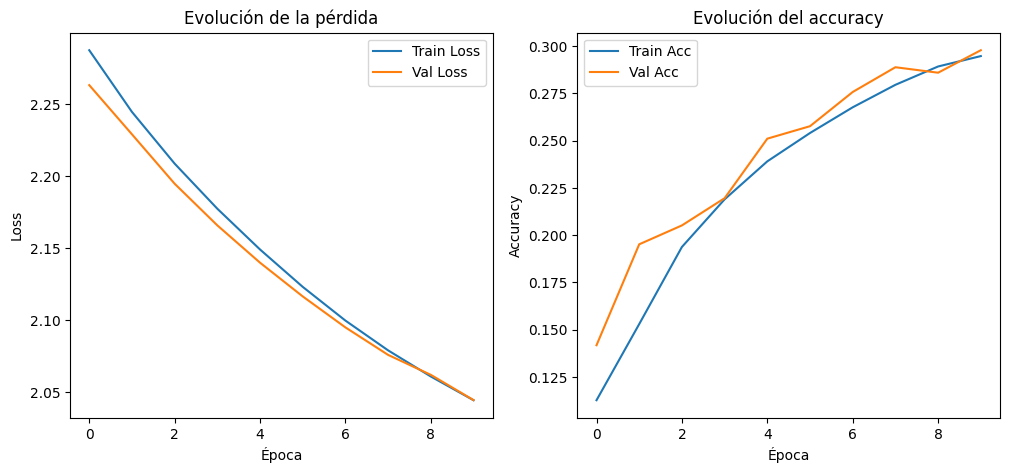

Epoch 1/10 - Loss: 2.3232 - Acc: 0.0937 - Val Loss: 2.3197 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3204 - Acc: 0.0937 - Val Loss: 2.3169 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3170 - Acc: 0.0937 - Val Loss: 2.3145 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3150 - Acc: 0.0937 - Val Loss: 2.3123 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3126 - Acc: 0.0937 - Val Loss: 2.3103 - Val Acc: 0.1000
Epoch 6/10 - Loss: 2.3104 - Acc: 0.0937 - Val Loss: 2.3085 - Val Acc: 0.1000
Epoch 7/10 - Loss: 2.3089 - Acc: 0.0937 - Val Loss: 2.3068 - Val Acc: 0.1000
Epoch 8/10 - Loss: 2.3069 - Acc: 0.0937 - Val Loss: 2.3053 - Val Acc: 0.1000
Epoch 9/10 - Loss: 2.3055 - Acc: 0.0937 - Val Loss: 2.3040 - Val Acc: 0.1001
Epoch 10/10 - Loss: 2.3040 - Acc: 0.0936 - Val Loss: 2.3027 - Val Acc: 0.1005


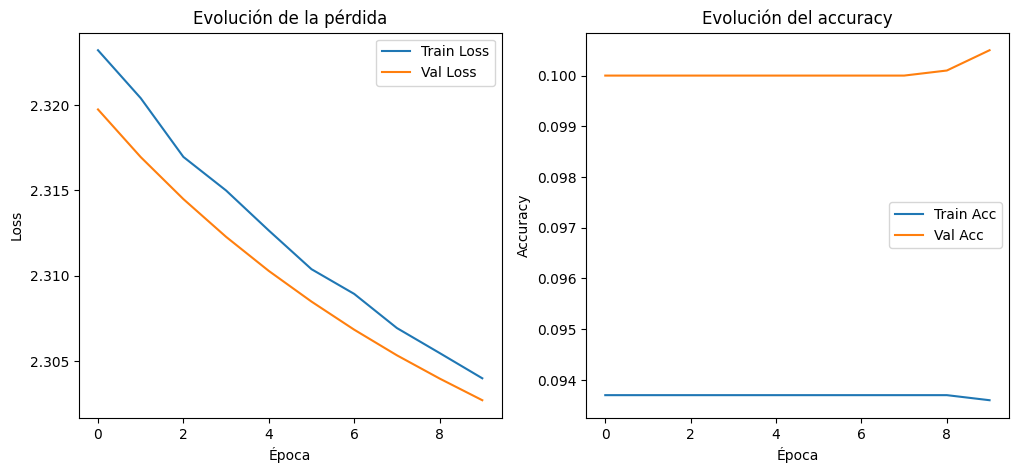

Epoch 1/10 - Loss: 2.3092 - Acc: 0.1006 - Val Loss: 2.3023 - Val Acc: 0.1018
Epoch 2/10 - Loss: 2.2975 - Acc: 0.1060 - Val Loss: 2.2948 - Val Acc: 0.1082
Epoch 3/10 - Loss: 2.2907 - Acc: 0.1098 - Val Loss: 2.2890 - Val Acc: 0.1167
Epoch 4/10 - Loss: 2.2852 - Acc: 0.1170 - Val Loss: 2.2841 - Val Acc: 0.1236
Epoch 5/10 - Loss: 2.2801 - Acc: 0.1231 - Val Loss: 2.2794 - Val Acc: 0.1277
Epoch 6/10 - Loss: 2.2753 - Acc: 0.1300 - Val Loss: 2.2751 - Val Acc: 0.1302
Epoch 7/10 - Loss: 2.2707 - Acc: 0.1319 - Val Loss: 2.2708 - Val Acc: 0.1337
Epoch 8/10 - Loss: 2.2663 - Acc: 0.1361 - Val Loss: 2.2665 - Val Acc: 0.1427
Epoch 9/10 - Loss: 2.2620 - Acc: 0.1444 - Val Loss: 2.2623 - Val Acc: 0.1473
Epoch 10/10 - Loss: 2.2578 - Acc: 0.1477 - Val Loss: 2.2582 - Val Acc: 0.1524


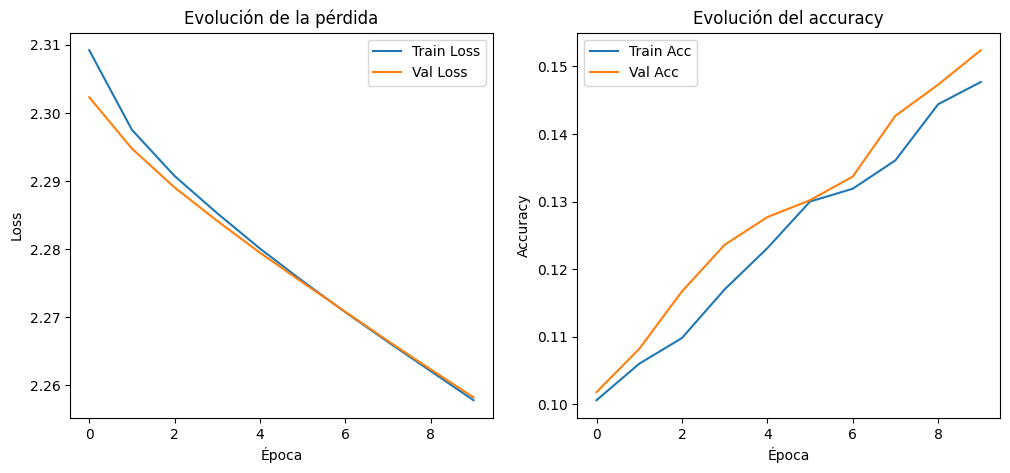

Epoch 1/10 - Loss: 2.2874 - Acc: 0.1338 - Val Loss: 2.2681 - Val Acc: 0.1704
Epoch 2/10 - Loss: 2.2510 - Acc: 0.2064 - Val Loss: 2.2348 - Val Acc: 0.2140
Epoch 3/10 - Loss: 2.2143 - Acc: 0.2430 - Val Loss: 2.1982 - Val Acc: 0.2584
Epoch 4/10 - Loss: 2.1757 - Acc: 0.2506 - Val Loss: 2.1595 - Val Acc: 0.2752
Epoch 5/10 - Loss: 2.1383 - Acc: 0.2701 - Val Loss: 2.1241 - Val Acc: 0.2772
Epoch 6/10 - Loss: 2.1047 - Acc: 0.2762 - Val Loss: 2.0942 - Val Acc: 0.2822
Epoch 7/10 - Loss: 2.0735 - Acc: 0.2904 - Val Loss: 2.0671 - Val Acc: 0.2836
Epoch 8/10 - Loss: 2.0478 - Acc: 0.2902 - Val Loss: 2.0466 - Val Acc: 0.2975
Epoch 9/10 - Loss: 2.0276 - Acc: 0.3002 - Val Loss: 2.0270 - Val Acc: 0.2933
Epoch 10/10 - Loss: 2.0076 - Acc: 0.3000 - Val Loss: 2.0092 - Val Acc: 0.2906


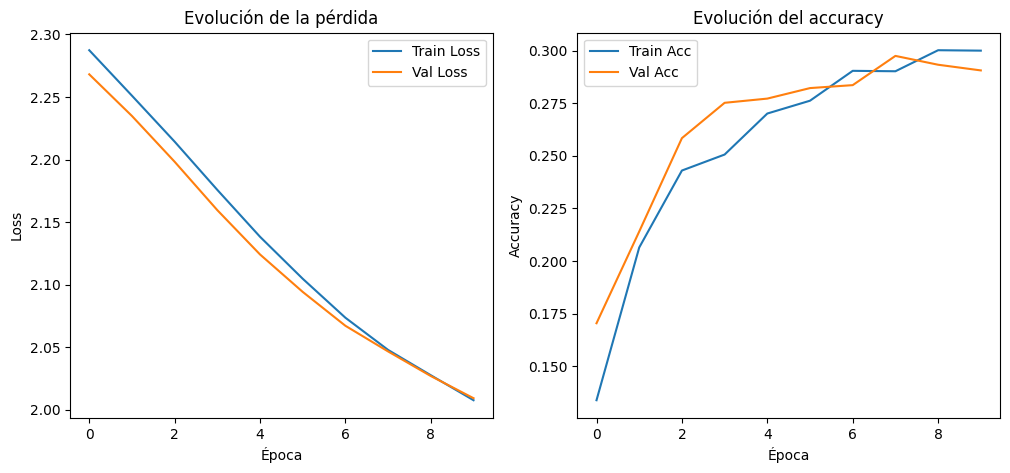

Epoch 1/10 - Loss: 90.0765 - Acc: 0.1158 - Val Loss: 3966.6179 - Val Acc: 0.1000
Epoch 2/10 - Loss: 105517181295.5725 - Acc: 0.1023 - Val Loss: 4315317796864.0000 - Val Acc: 0.1000
Epoch 3/10 - Loss: 243411033008309862400.0000 - Acc: 0.0956 - Val Loss: 7052350474935905288192.0000 - Val Acc: 0.1000
Epoch 4/10 - Loss: 713443551714765085499117797376.0000 - Acc: 0.0995 - Val Loss: 29700826672149589603464247246848.0000 - Val Acc: 0.1000
Epoch 5/10 - Loss: nan - Acc: 0.0970 - Val Loss: nan - Val Acc: 0.1000
Epoch 6/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 7/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 8/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 9/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000
Epoch 10/10 - Loss: nan - Acc: 0.1005 - Val Loss: nan - Val Acc: 0.1000


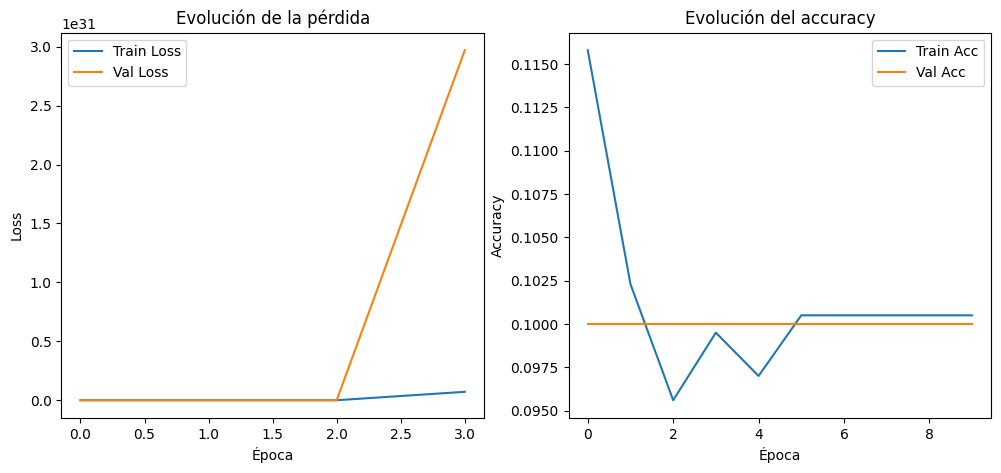

Epoch 1/10 - Loss: 2.3468 - Acc: 0.0981 - Val Loss: 2.3157 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3087 - Acc: 0.1028 - Val Loss: 2.2991 - Val Acc: 0.1158
Epoch 3/10 - Loss: 2.2961 - Acc: 0.1307 - Val Loss: 2.2922 - Val Acc: 0.1436
Epoch 4/10 - Loss: 2.2898 - Acc: 0.1463 - Val Loss: 2.2876 - Val Acc: 0.1577
Epoch 5/10 - Loss: 2.2852 - Acc: 0.1489 - Val Loss: 2.2836 - Val Acc: 0.1640
Epoch 6/10 - Loss: 2.2811 - Acc: 0.1586 - Val Loss: 2.2799 - Val Acc: 0.1714
Epoch 7/10 - Loss: 2.2773 - Acc: 0.1690 - Val Loss: 2.2763 - Val Acc: 0.1804
Epoch 8/10 - Loss: 2.2734 - Acc: 0.1808 - Val Loss: 2.2727 - Val Acc: 0.1850
Epoch 9/10 - Loss: 2.2694 - Acc: 0.1845 - Val Loss: 2.2691 - Val Acc: 0.1952
Epoch 10/10 - Loss: 2.2658 - Acc: 0.1987 - Val Loss: 2.2655 - Val Acc: 0.2000


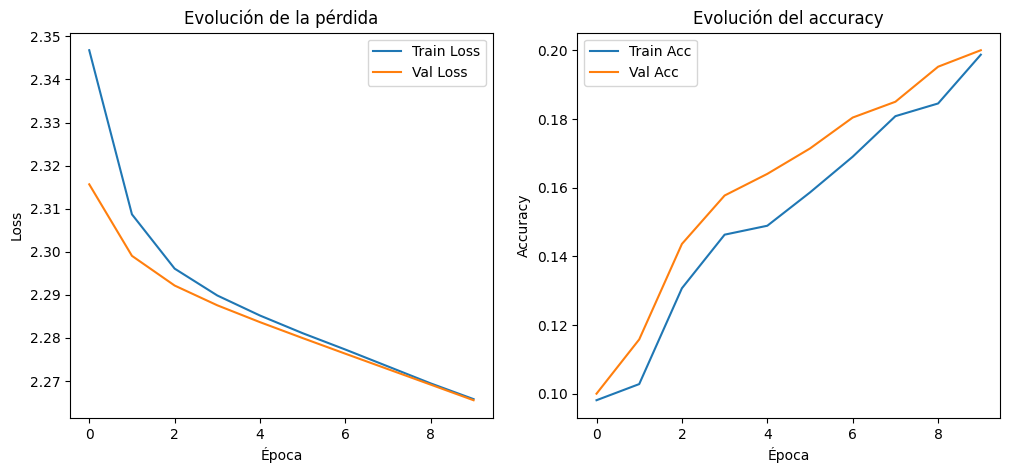

Epoch 1/10 - Loss: 2.2764 - Acc: 0.1507 - Val Loss: 2.2475 - Val Acc: 0.1918
Epoch 2/10 - Loss: 2.2229 - Acc: 0.2035 - Val Loss: 2.2051 - Val Acc: 0.2080
Epoch 3/10 - Loss: 2.1826 - Acc: 0.2368 - Val Loss: 2.1687 - Val Acc: 0.2527
Epoch 4/10 - Loss: 2.1487 - Acc: 0.2586 - Val Loss: 2.1391 - Val Acc: 0.2585
Epoch 5/10 - Loss: 2.1211 - Acc: 0.2735 - Val Loss: 2.1131 - Val Acc: 0.2889
Epoch 6/10 - Loss: 2.0958 - Acc: 0.2862 - Val Loss: 2.0915 - Val Acc: 0.2938
Epoch 7/10 - Loss: 2.0744 - Acc: 0.2981 - Val Loss: 2.0717 - Val Acc: 0.2953
Epoch 8/10 - Loss: 2.0545 - Acc: 0.3080 - Val Loss: 2.0542 - Val Acc: 0.3054
Epoch 9/10 - Loss: 2.0365 - Acc: 0.3121 - Val Loss: 2.0365 - Val Acc: 0.3082
Epoch 10/10 - Loss: 2.0187 - Acc: 0.3160 - Val Loss: 2.0238 - Val Acc: 0.3056


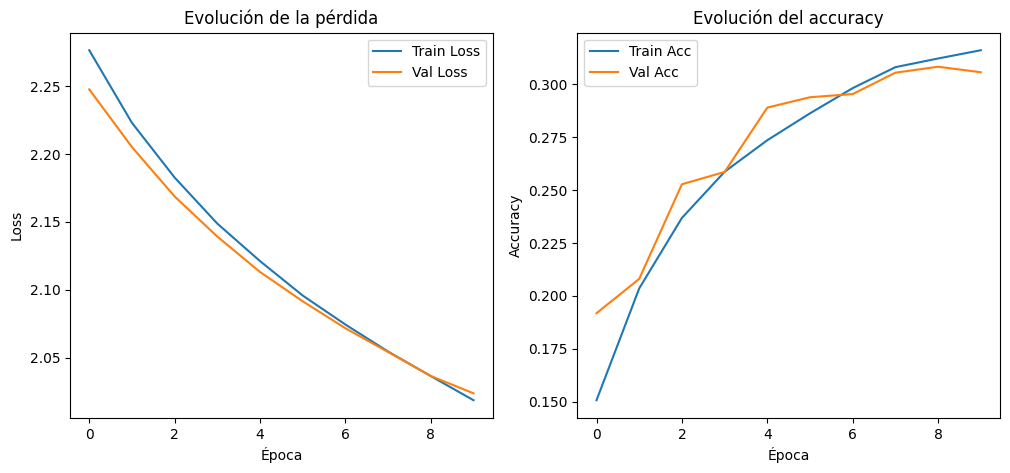

Epoch 1/10 - Loss: 2.3363 - Acc: 0.0969 - Val Loss: 2.3358 - Val Acc: 0.0995
Epoch 2/10 - Loss: 2.3319 - Acc: 0.0969 - Val Loss: 2.3317 - Val Acc: 0.0994
Epoch 3/10 - Loss: 2.3279 - Acc: 0.0968 - Val Loss: 2.3280 - Val Acc: 0.0994
Epoch 4/10 - Loss: 2.3242 - Acc: 0.0969 - Val Loss: 2.3247 - Val Acc: 0.0991
Epoch 5/10 - Loss: 2.3214 - Acc: 0.0966 - Val Loss: 2.3216 - Val Acc: 0.0992
Epoch 6/10 - Loss: 2.3188 - Acc: 0.0968 - Val Loss: 2.3188 - Val Acc: 0.0997
Epoch 7/10 - Loss: 2.3160 - Acc: 0.0967 - Val Loss: 2.3163 - Val Acc: 0.0994
Epoch 8/10 - Loss: 2.3136 - Acc: 0.0969 - Val Loss: 2.3140 - Val Acc: 0.0997
Epoch 9/10 - Loss: 2.3115 - Acc: 0.0975 - Val Loss: 2.3118 - Val Acc: 0.0999
Epoch 10/10 - Loss: 2.3097 - Acc: 0.0974 - Val Loss: 2.3099 - Val Acc: 0.0987


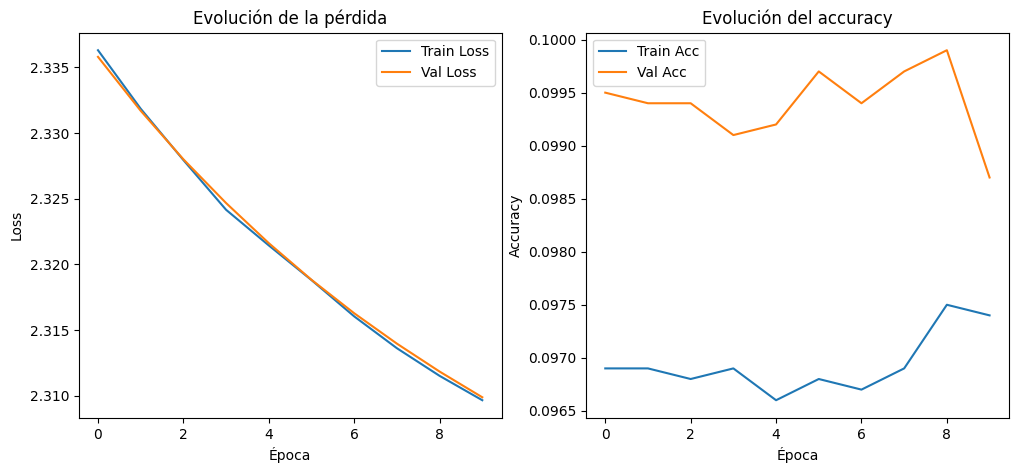

Epoch 1/10 - Loss: 2.3086 - Acc: 0.1182 - Val Loss: 2.3005 - Val Acc: 0.1293
Epoch 2/10 - Loss: 2.2965 - Acc: 0.1273 - Val Loss: 2.2916 - Val Acc: 0.1356
Epoch 3/10 - Loss: 2.2881 - Acc: 0.1310 - Val Loss: 2.2849 - Val Acc: 0.1378
Epoch 4/10 - Loss: 2.2819 - Acc: 0.1332 - Val Loss: 2.2793 - Val Acc: 0.1407
Epoch 5/10 - Loss: 2.2762 - Acc: 0.1375 - Val Loss: 2.2742 - Val Acc: 0.1445
Epoch 6/10 - Loss: 2.2706 - Acc: 0.1431 - Val Loss: 2.2693 - Val Acc: 0.1508
Epoch 7/10 - Loss: 2.2655 - Acc: 0.1518 - Val Loss: 2.2644 - Val Acc: 0.1575
Epoch 8/10 - Loss: 2.2603 - Acc: 0.1547 - Val Loss: 2.2598 - Val Acc: 0.1615
Epoch 9/10 - Loss: 2.2557 - Acc: 0.1582 - Val Loss: 2.2552 - Val Acc: 0.1667
Epoch 10/10 - Loss: 2.2511 - Acc: 0.1639 - Val Loss: 2.2509 - Val Acc: 0.1753


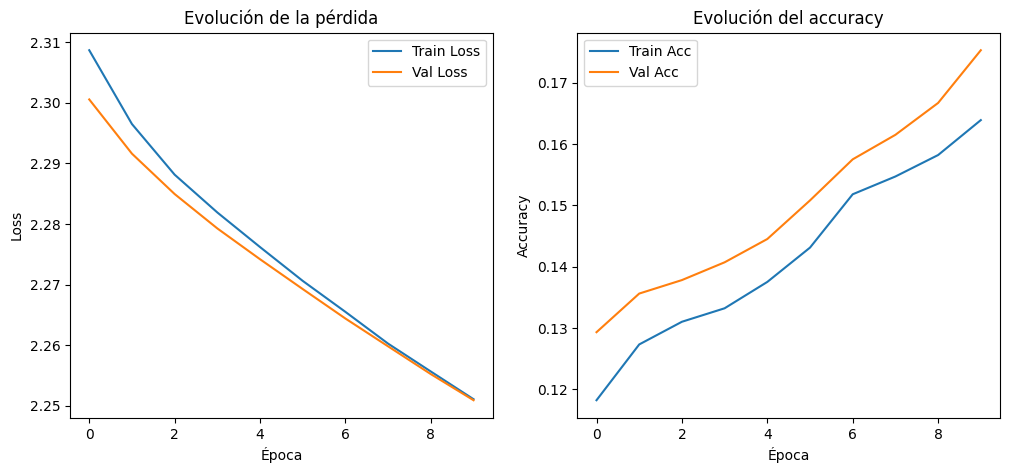

Epoch 1/10 - Loss: 2.2847 - Acc: 0.1354 - Val Loss: 2.2655 - Val Acc: 0.1569
Epoch 2/10 - Loss: 2.2436 - Acc: 0.2048 - Val Loss: 2.2251 - Val Acc: 0.1985
Epoch 3/10 - Loss: 2.2033 - Acc: 0.2383 - Val Loss: 2.1837 - Val Acc: 0.2329
Epoch 4/10 - Loss: 2.1615 - Acc: 0.2556 - Val Loss: 2.1420 - Val Acc: 0.2795
Epoch 5/10 - Loss: 2.1216 - Acc: 0.2775 - Val Loss: 2.1091 - Val Acc: 0.2581
Epoch 6/10 - Loss: 2.0868 - Acc: 0.2776 - Val Loss: 2.0748 - Val Acc: 0.2946
Epoch 7/10 - Loss: 2.0561 - Acc: 0.2880 - Val Loss: 2.0487 - Val Acc: 0.2892
Epoch 8/10 - Loss: 2.0324 - Acc: 0.2942 - Val Loss: 2.0285 - Val Acc: 0.2894
Epoch 9/10 - Loss: 2.0083 - Acc: 0.3041 - Val Loss: 2.0091 - Val Acc: 0.2974
Epoch 10/10 - Loss: 1.9915 - Acc: 0.3040 - Val Loss: 1.9925 - Val Acc: 0.2930


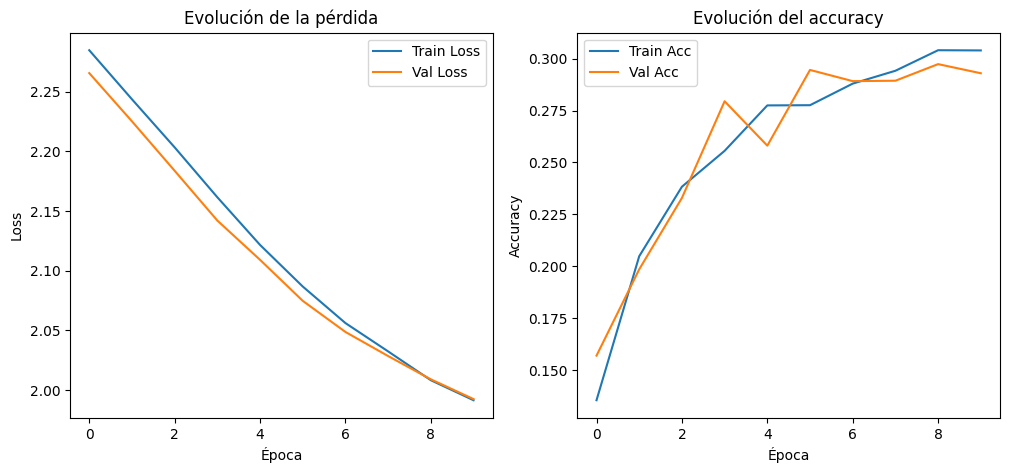

Epoch 1/10 - Loss: 2.6755 - Acc: 0.1208 - Val Loss: 2.1969 - Val Acc: 0.2037
Epoch 2/10 - Loss: 2.1026 - Acc: 0.2428 - Val Loss: 2.1548 - Val Acc: 0.1800
Epoch 3/10 - Loss: 2.0508 - Acc: 0.2630 - Val Loss: 2.0056 - Val Acc: 0.2847
Epoch 4/10 - Loss: 2.0013 - Acc: 0.2768 - Val Loss: 1.9995 - Val Acc: 0.2744
Epoch 5/10 - Loss: 1.9992 - Acc: 0.2909 - Val Loss: 2.0242 - Val Acc: 0.2774
Epoch 6/10 - Loss: 1.9545 - Acc: 0.3020 - Val Loss: 1.9472 - Val Acc: 0.2913
Epoch 7/10 - Loss: 1.9334 - Acc: 0.3181 - Val Loss: 2.1148 - Val Acc: 0.2680
Epoch 8/10 - Loss: 1.9235 - Acc: 0.3219 - Val Loss: 2.0072 - Val Acc: 0.2656
Epoch 9/10 - Loss: 1.9192 - Acc: 0.3306 - Val Loss: 1.9270 - Val Acc: 0.2876
Epoch 10/10 - Loss: 1.8919 - Acc: 0.3340 - Val Loss: 1.9306 - Val Acc: 0.3108


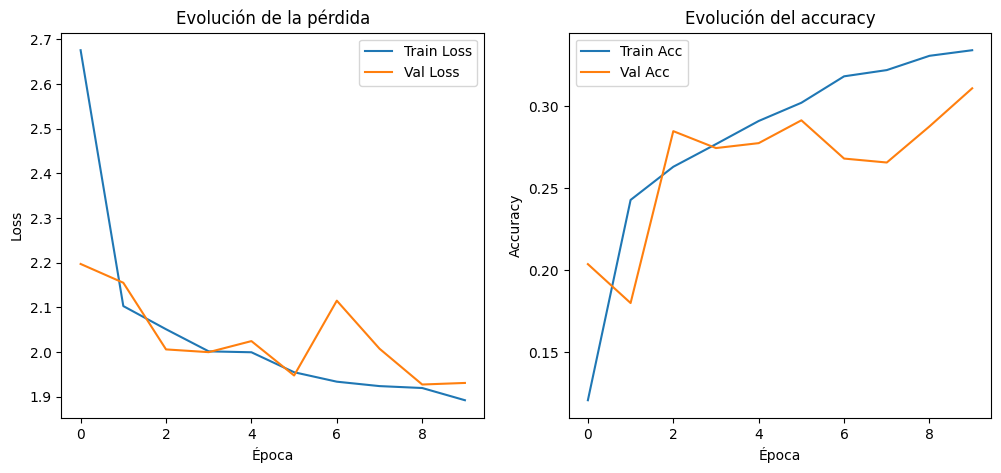

Epoch 1/10 - Loss: 2.3189 - Acc: 0.0935 - Val Loss: 2.3045 - Val Acc: 0.1030
Epoch 2/10 - Loss: 2.2999 - Acc: 0.1237 - Val Loss: 2.2960 - Val Acc: 0.1427
Epoch 3/10 - Loss: 2.2932 - Acc: 0.1384 - Val Loss: 2.2910 - Val Acc: 0.1435
Epoch 4/10 - Loss: 2.2882 - Acc: 0.1502 - Val Loss: 2.2865 - Val Acc: 0.1399
Epoch 5/10 - Loss: 2.2837 - Acc: 0.1512 - Val Loss: 2.2821 - Val Acc: 0.1632
Epoch 6/10 - Loss: 2.2791 - Acc: 0.1802 - Val Loss: 2.2780 - Val Acc: 0.1653
Epoch 7/10 - Loss: 2.2747 - Acc: 0.1761 - Val Loss: 2.2737 - Val Acc: 0.1765
Epoch 8/10 - Loss: 2.2705 - Acc: 0.1838 - Val Loss: 2.2696 - Val Acc: 0.1848
Epoch 9/10 - Loss: 2.2663 - Acc: 0.1922 - Val Loss: 2.2653 - Val Acc: 0.2137
Epoch 10/10 - Loss: 2.2620 - Acc: 0.2166 - Val Loss: 2.2612 - Val Acc: 0.2133


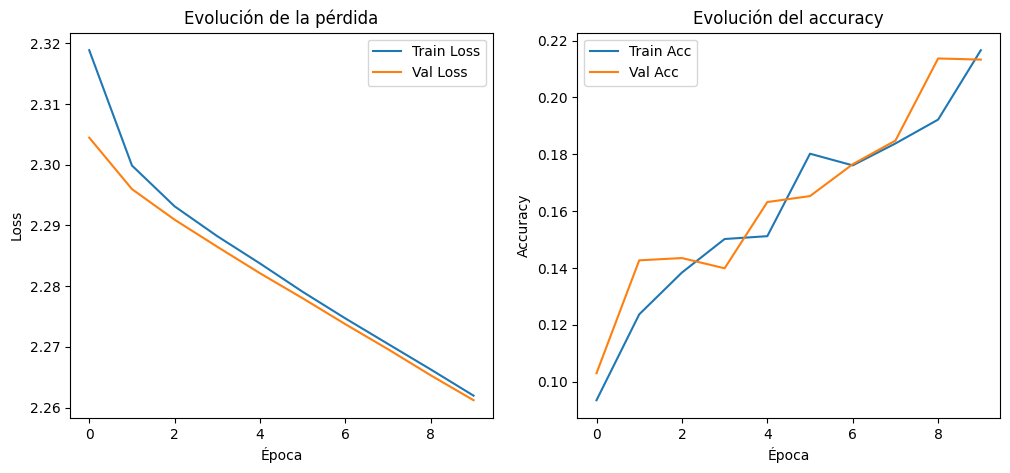

Epoch 1/10 - Loss: 2.2743 - Acc: 0.1346 - Val Loss: 2.2484 - Val Acc: 0.1629
Epoch 2/10 - Loss: 2.2264 - Acc: 0.2013 - Val Loss: 2.2112 - Val Acc: 0.1652
Epoch 3/10 - Loss: 2.1885 - Acc: 0.2298 - Val Loss: 2.1737 - Val Acc: 0.2481
Epoch 4/10 - Loss: 2.1541 - Acc: 0.2584 - Val Loss: 2.1425 - Val Acc: 0.2548
Epoch 5/10 - Loss: 2.1247 - Acc: 0.2608 - Val Loss: 2.1149 - Val Acc: 0.2850
Epoch 6/10 - Loss: 2.0972 - Acc: 0.2803 - Val Loss: 2.0913 - Val Acc: 0.2905
Epoch 7/10 - Loss: 2.0736 - Acc: 0.2904 - Val Loss: 2.0719 - Val Acc: 0.2797
Epoch 8/10 - Loss: 2.0525 - Acc: 0.2919 - Val Loss: 2.0521 - Val Acc: 0.3025
Epoch 9/10 - Loss: 2.0356 - Acc: 0.2960 - Val Loss: 2.0344 - Val Acc: 0.3094
Epoch 10/10 - Loss: 2.0194 - Acc: 0.3084 - Val Loss: 2.0202 - Val Acc: 0.3067


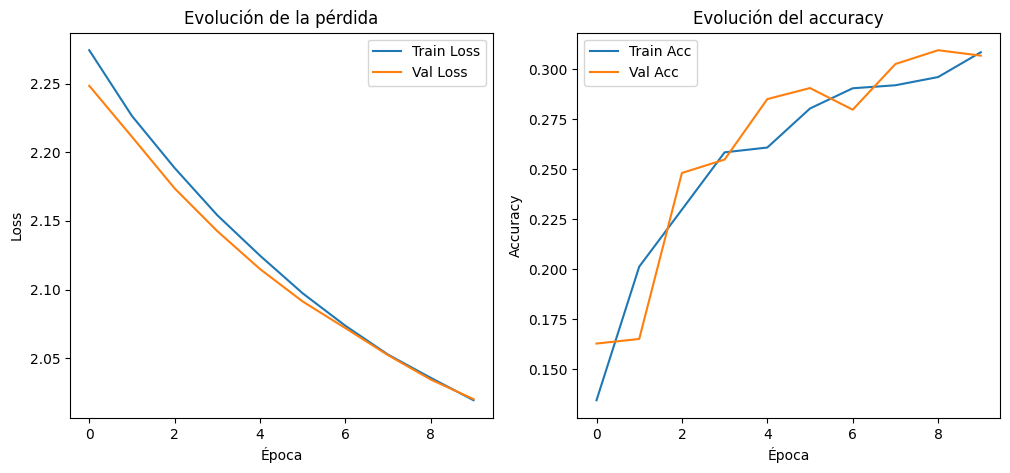

Epoch 1/10 - Loss: 2.3197 - Acc: 0.1069 - Val Loss: 2.3196 - Val Acc: 0.1095
Epoch 2/10 - Loss: 2.3156 - Acc: 0.1141 - Val Loss: 2.3161 - Val Acc: 0.1172
Epoch 3/10 - Loss: 2.3128 - Acc: 0.1219 - Val Loss: 2.3132 - Val Acc: 0.1223
Epoch 4/10 - Loss: 2.3103 - Acc: 0.1274 - Val Loss: 2.3107 - Val Acc: 0.1269
Epoch 5/10 - Loss: 2.3076 - Acc: 0.1313 - Val Loss: 2.3085 - Val Acc: 0.1304
Epoch 6/10 - Loss: 2.3060 - Acc: 0.1341 - Val Loss: 2.3066 - Val Acc: 0.1309
Epoch 7/10 - Loss: 2.3041 - Acc: 0.1330 - Val Loss: 2.3049 - Val Acc: 0.1318
Epoch 8/10 - Loss: 2.3026 - Acc: 0.1310 - Val Loss: 2.3035 - Val Acc: 0.1319
Epoch 9/10 - Loss: 2.3010 - Acc: 0.1297 - Val Loss: 2.3022 - Val Acc: 0.1315
Epoch 10/10 - Loss: 2.3003 - Acc: 0.1290 - Val Loss: 2.3010 - Val Acc: 0.1306


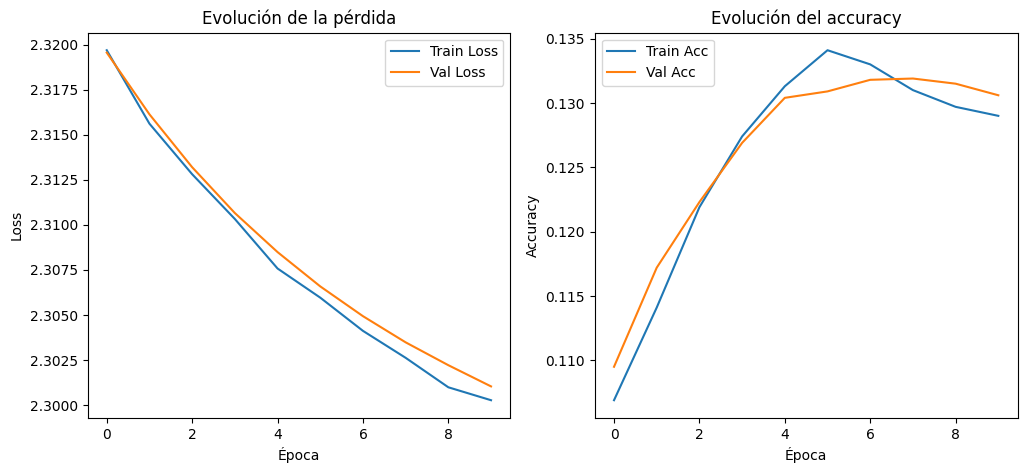

Epoch 1/10 - Loss: 2.3093 - Acc: 0.1254 - Val Loss: 2.3013 - Val Acc: 0.1352
Epoch 2/10 - Loss: 2.2967 - Acc: 0.1278 - Val Loss: 2.2914 - Val Acc: 0.1329
Epoch 3/10 - Loss: 2.2882 - Acc: 0.1351 - Val Loss: 2.2844 - Val Acc: 0.1440
Epoch 4/10 - Loss: 2.2813 - Acc: 0.1406 - Val Loss: 2.2783 - Val Acc: 0.1528
Epoch 5/10 - Loss: 2.2752 - Acc: 0.1496 - Val Loss: 2.2727 - Val Acc: 0.1559
Epoch 6/10 - Loss: 2.2699 - Acc: 0.1512 - Val Loss: 2.2674 - Val Acc: 0.1621
Epoch 7/10 - Loss: 2.2643 - Acc: 0.1597 - Val Loss: 2.2622 - Val Acc: 0.1702
Epoch 8/10 - Loss: 2.2592 - Acc: 0.1669 - Val Loss: 2.2572 - Val Acc: 0.1761
Epoch 9/10 - Loss: 2.2539 - Acc: 0.1738 - Val Loss: 2.2523 - Val Acc: 0.1841
Epoch 10/10 - Loss: 2.2487 - Acc: 0.1830 - Val Loss: 2.2476 - Val Acc: 0.1910


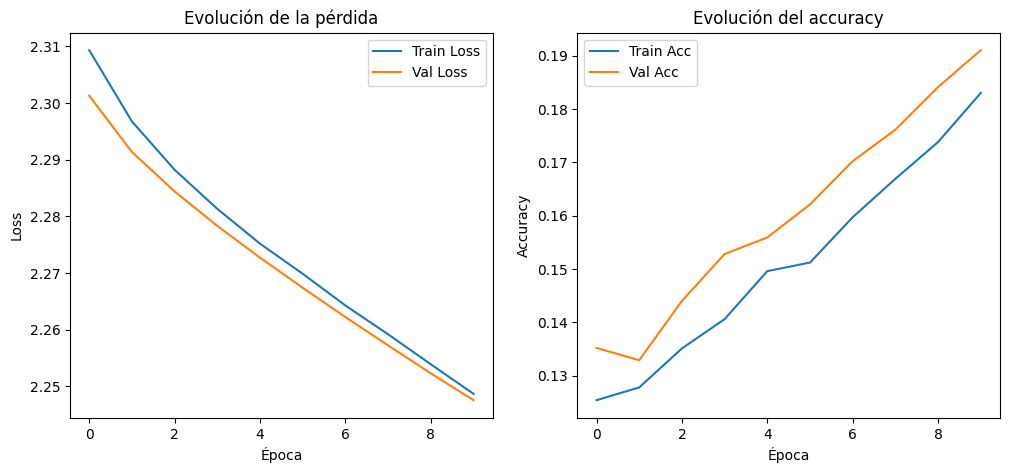

Epoch 1/10 - Loss: 2.3092 - Acc: 0.0985 - Val Loss: 2.3029 - Val Acc: 0.1026
Epoch 2/10 - Loss: 2.3017 - Acc: 0.1084 - Val Loss: 2.3015 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3006 - Acc: 0.1104 - Val Loss: 2.3009 - Val Acc: 0.1108
Epoch 4/10 - Loss: 2.3000 - Acc: 0.1102 - Val Loss: 2.2996 - Val Acc: 0.1203
Epoch 5/10 - Loss: 2.2992 - Acc: 0.1193 - Val Loss: 2.2989 - Val Acc: 0.1531
Epoch 6/10 - Loss: 2.2983 - Acc: 0.1407 - Val Loss: 2.2982 - Val Acc: 0.1357
Epoch 7/10 - Loss: 2.2979 - Acc: 0.1332 - Val Loss: 2.2975 - Val Acc: 0.1512
Epoch 8/10 - Loss: 2.2968 - Acc: 0.1405 - Val Loss: 2.2968 - Val Acc: 0.1078
Epoch 9/10 - Loss: 2.2963 - Acc: 0.1258 - Val Loss: 2.2958 - Val Acc: 0.1366
Epoch 10/10 - Loss: 2.2947 - Acc: 0.1644 - Val Loss: 2.2953 - Val Acc: 0.1185


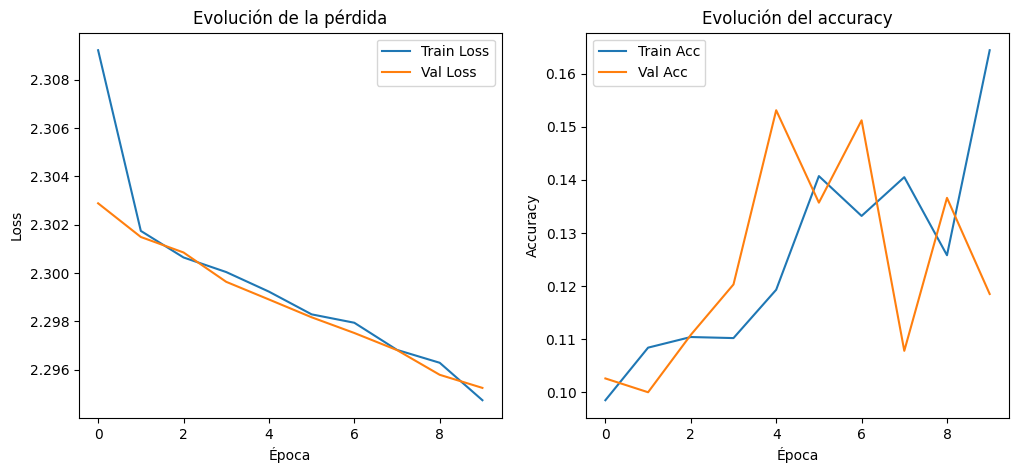

Epoch 1/10 - Loss: 2.2361 - Acc: 0.1629 - Val Loss: 2.1466 - Val Acc: 0.2151
Epoch 2/10 - Loss: 2.1259 - Acc: 0.2155 - Val Loss: 2.0506 - Val Acc: 0.2741
Epoch 3/10 - Loss: 2.1029 - Acc: 0.2376 - Val Loss: 2.0059 - Val Acc: 0.2873
Epoch 4/10 - Loss: 2.0405 - Acc: 0.2620 - Val Loss: 2.0044 - Val Acc: 0.2659
Epoch 5/10 - Loss: 2.0001 - Acc: 0.2837 - Val Loss: 1.9861 - Val Acc: 0.2744
Epoch 6/10 - Loss: 1.9722 - Acc: 0.2940 - Val Loss: 2.0126 - Val Acc: 0.2673
Epoch 7/10 - Loss: 1.9504 - Acc: 0.3060 - Val Loss: 2.0801 - Val Acc: 0.2557
Epoch 8/10 - Loss: 1.9365 - Acc: 0.3176 - Val Loss: 1.9038 - Val Acc: 0.3252
Epoch 9/10 - Loss: 1.9048 - Acc: 0.3226 - Val Loss: 1.9209 - Val Acc: 0.3059
Epoch 10/10 - Loss: 1.8981 - Acc: 0.3235 - Val Loss: 1.9818 - Val Acc: 0.2873


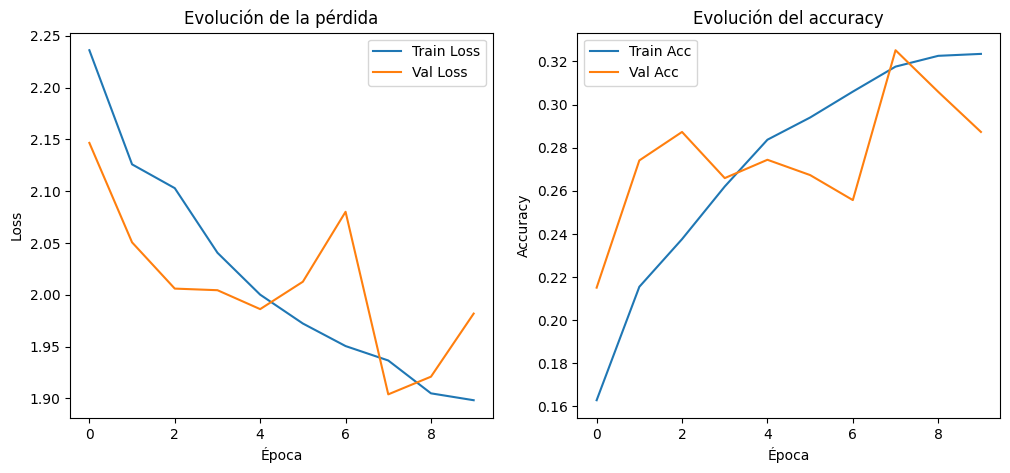

Epoch 1/10 - Loss: 2.3362 - Acc: 0.0999 - Val Loss: 2.3324 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3249 - Acc: 0.0999 - Val Loss: 2.3227 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3169 - Acc: 0.0999 - Val Loss: 2.3164 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3120 - Acc: 0.0999 - Val Loss: 2.3121 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3089 - Acc: 0.0999 - Val Loss: 2.3091 - Val Acc: 0.1000
Epoch 6/10 - Loss: 2.3062 - Acc: 0.1022 - Val Loss: 2.3071 - Val Acc: 0.1049
Epoch 7/10 - Loss: 2.3048 - Acc: 0.1171 - Val Loss: 2.3057 - Val Acc: 0.1357
Epoch 8/10 - Loss: 2.3036 - Acc: 0.1284 - Val Loss: 2.3047 - Val Acc: 0.1351
Epoch 9/10 - Loss: 2.3030 - Acc: 0.1250 - Val Loss: 2.3039 - Val Acc: 0.1315
Epoch 10/10 - Loss: 2.3025 - Acc: 0.1211 - Val Loss: 2.3033 - Val Acc: 0.1341


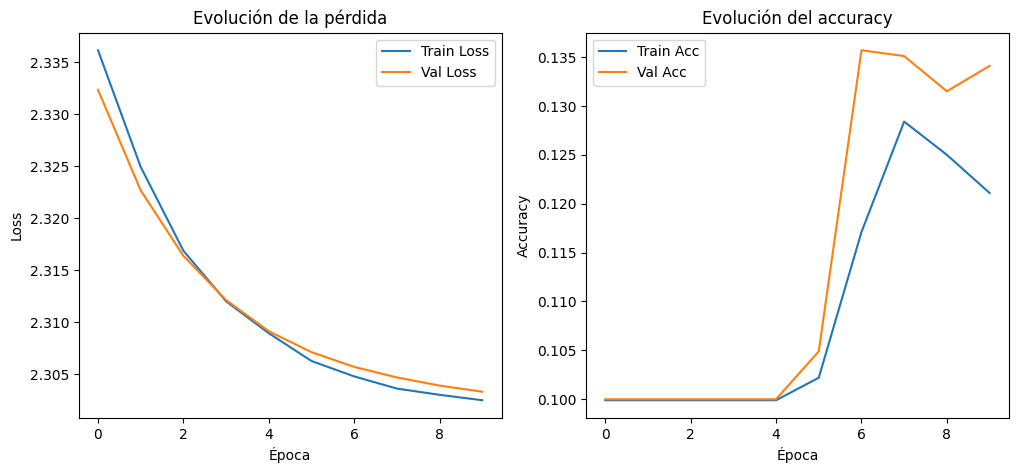

Epoch 1/10 - Loss: 2.2984 - Acc: 0.1146 - Val Loss: 2.2884 - Val Acc: 0.1160
Epoch 2/10 - Loss: 2.2797 - Acc: 0.1276 - Val Loss: 2.2737 - Val Acc: 0.1257
Epoch 3/10 - Loss: 2.2645 - Acc: 0.1385 - Val Loss: 2.2586 - Val Acc: 0.1608
Epoch 4/10 - Loss: 2.2495 - Acc: 0.1726 - Val Loss: 2.2438 - Val Acc: 0.1687
Epoch 5/10 - Loss: 2.2341 - Acc: 0.1866 - Val Loss: 2.2288 - Val Acc: 0.1914
Epoch 6/10 - Loss: 2.2178 - Acc: 0.2069 - Val Loss: 2.2135 - Val Acc: 0.2110
Epoch 7/10 - Loss: 2.2023 - Acc: 0.2205 - Val Loss: 2.1973 - Val Acc: 0.2189
Epoch 8/10 - Loss: 2.1847 - Acc: 0.2283 - Val Loss: 2.1810 - Val Acc: 0.2251
Epoch 9/10 - Loss: 2.1682 - Acc: 0.2347 - Val Loss: 2.1644 - Val Acc: 0.2335
Epoch 10/10 - Loss: 2.1511 - Acc: 0.2418 - Val Loss: 2.1482 - Val Acc: 0.2320


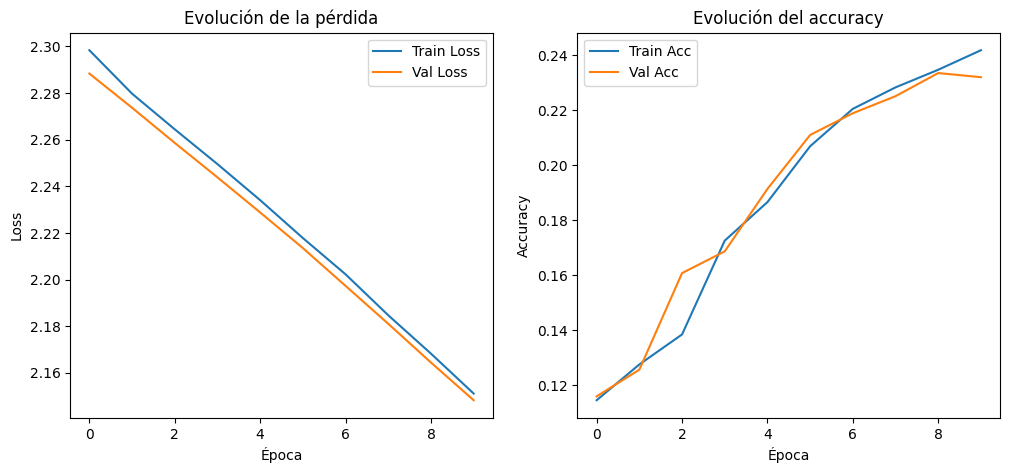

Epoch 1/10 - Loss: 2.3309 - Acc: 0.1005 - Val Loss: 2.3298 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3298 - Acc: 0.1005 - Val Loss: 2.3288 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3289 - Acc: 0.1005 - Val Loss: 2.3278 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3271 - Acc: 0.1005 - Val Loss: 2.3269 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3264 - Acc: 0.1005 - Val Loss: 2.3260 - Val Acc: 0.1000
Epoch 6/10 - Loss: 2.3263 - Acc: 0.1005 - Val Loss: 2.3251 - Val Acc: 0.1000
Epoch 7/10 - Loss: 2.3250 - Acc: 0.1005 - Val Loss: 2.3242 - Val Acc: 0.1000
Epoch 8/10 - Loss: 2.3241 - Acc: 0.1005 - Val Loss: 2.3234 - Val Acc: 0.1000
Epoch 9/10 - Loss: 2.3231 - Acc: 0.1005 - Val Loss: 2.3226 - Val Acc: 0.1000
Epoch 10/10 - Loss: 2.3224 - Acc: 0.1005 - Val Loss: 2.3218 - Val Acc: 0.1000


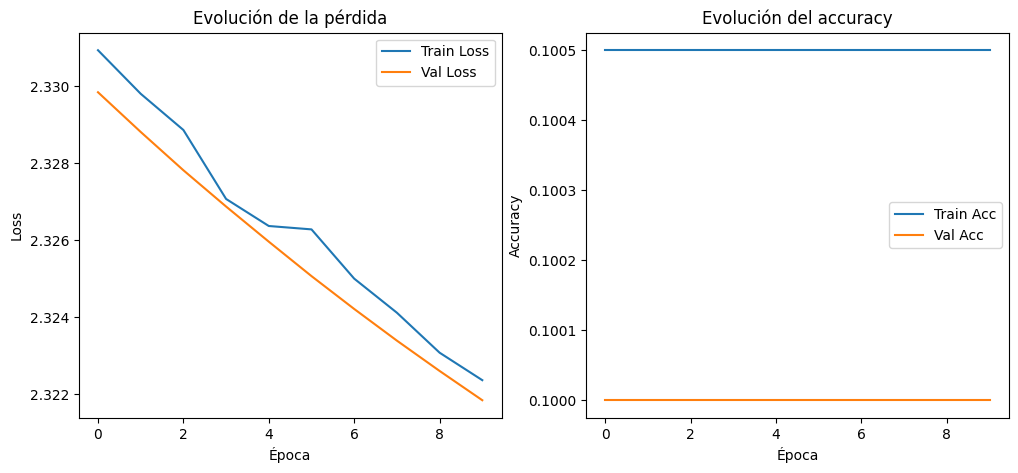

Epoch 1/10 - Loss: 2.3123 - Acc: 0.1016 - Val Loss: 2.3083 - Val Acc: 0.1019
Epoch 2/10 - Loss: 2.3065 - Acc: 0.1021 - Val Loss: 2.3037 - Val Acc: 0.1035
Epoch 3/10 - Loss: 2.3022 - Acc: 0.1060 - Val Loss: 2.2999 - Val Acc: 0.1096
Epoch 4/10 - Loss: 2.2984 - Acc: 0.1182 - Val Loss: 2.2965 - Val Acc: 0.1257
Epoch 5/10 - Loss: 2.2949 - Acc: 0.1299 - Val Loss: 2.2934 - Val Acc: 0.1308
Epoch 6/10 - Loss: 2.2916 - Acc: 0.1311 - Val Loss: 2.2905 - Val Acc: 0.1292
Epoch 7/10 - Loss: 2.2889 - Acc: 0.1283 - Val Loss: 2.2879 - Val Acc: 0.1279
Epoch 8/10 - Loss: 2.2861 - Acc: 0.1285 - Val Loss: 2.2853 - Val Acc: 0.1240
Epoch 9/10 - Loss: 2.2833 - Acc: 0.1278 - Val Loss: 2.2829 - Val Acc: 0.1259
Epoch 10/10 - Loss: 2.2811 - Acc: 0.1290 - Val Loss: 2.2805 - Val Acc: 0.1257


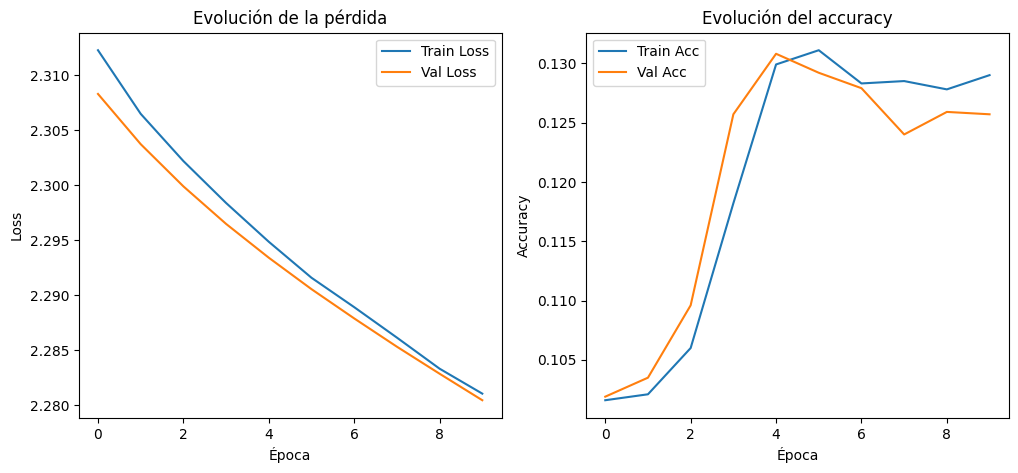

Epoch 1/10 - Loss: 2.3262 - Acc: 0.0996 - Val Loss: 2.3041 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3033 - Acc: 0.0973 - Val Loss: 2.3029 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3028 - Acc: 0.0947 - Val Loss: 2.3030 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3030 - Acc: 0.0996 - Val Loss: 2.3029 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3028 - Acc: 0.1013 - Val Loss: 2.3030 - Val Acc: 0.1001
Epoch 6/10 - Loss: 2.3027 - Acc: 0.0986 - Val Loss: 2.3031 - Val Acc: 0.1000
Epoch 7/10 - Loss: 2.3029 - Acc: 0.0974 - Val Loss: 2.3029 - Val Acc: 0.1000
Epoch 8/10 - Loss: 2.3027 - Acc: 0.1044 - Val Loss: 2.3029 - Val Acc: 0.1000
Epoch 9/10 - Loss: 2.3027 - Acc: 0.1032 - Val Loss: 2.3031 - Val Acc: 0.1000
Epoch 10/10 - Loss: 2.3027 - Acc: 0.1046 - Val Loss: 2.3031 - Val Acc: 0.1000


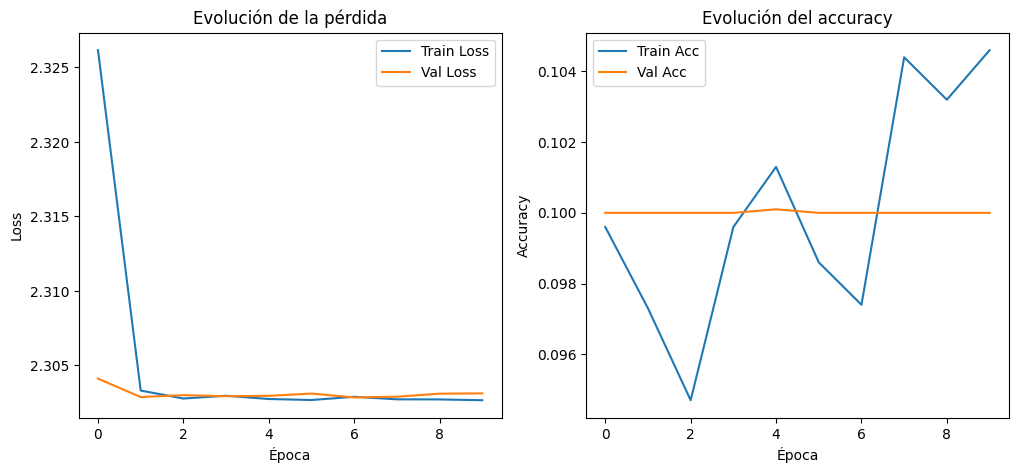

Epoch 1/10 - Loss: 2.2555 - Acc: 0.1522 - Val Loss: 2.1997 - Val Acc: 0.1887
Epoch 2/10 - Loss: 2.1797 - Acc: 0.1942 - Val Loss: 2.1146 - Val Acc: 0.2332
Epoch 3/10 - Loss: 2.1019 - Acc: 0.2290 - Val Loss: 2.0491 - Val Acc: 0.2409
Epoch 4/10 - Loss: 2.0744 - Acc: 0.2432 - Val Loss: 2.0226 - Val Acc: 0.2751
Epoch 5/10 - Loss: 2.0128 - Acc: 0.2724 - Val Loss: 1.9880 - Val Acc: 0.2760
Epoch 6/10 - Loss: 2.0332 - Acc: 0.2650 - Val Loss: 1.9828 - Val Acc: 0.2715
Epoch 7/10 - Loss: 1.9924 - Acc: 0.2795 - Val Loss: 1.9910 - Val Acc: 0.2619
Epoch 8/10 - Loss: 1.9308 - Acc: 0.3130 - Val Loss: 1.9914 - Val Acc: 0.2949
Epoch 9/10 - Loss: 1.9432 - Acc: 0.3045 - Val Loss: 2.0225 - Val Acc: 0.2715
Epoch 10/10 - Loss: 1.9394 - Acc: 0.3110 - Val Loss: 1.9128 - Val Acc: 0.3086


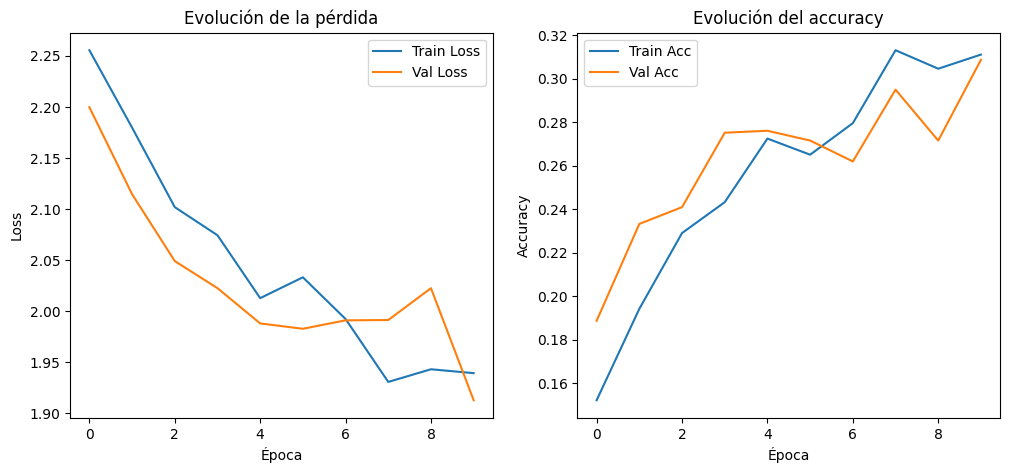

Epoch 1/10 - Loss: 2.3380 - Acc: 0.0937 - Val Loss: 2.3301 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3275 - Acc: 0.0937 - Val Loss: 2.3215 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3201 - Acc: 0.0937 - Val Loss: 2.3156 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3146 - Acc: 0.0937 - Val Loss: 2.3115 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3107 - Acc: 0.0963 - Val Loss: 2.3088 - Val Acc: 0.1000
Epoch 6/10 - Loss: 2.3084 - Acc: 0.1028 - Val Loss: 2.3069 - Val Acc: 0.1000
Epoch 7/10 - Loss: 2.3065 - Acc: 0.1017 - Val Loss: 2.3056 - Val Acc: 0.1000
Epoch 8/10 - Loss: 2.3054 - Acc: 0.1030 - Val Loss: 2.3046 - Val Acc: 0.1000
Epoch 9/10 - Loss: 2.3044 - Acc: 0.1031 - Val Loss: 2.3040 - Val Acc: 0.1000
Epoch 10/10 - Loss: 2.3037 - Acc: 0.1030 - Val Loss: 2.3036 - Val Acc: 0.1000


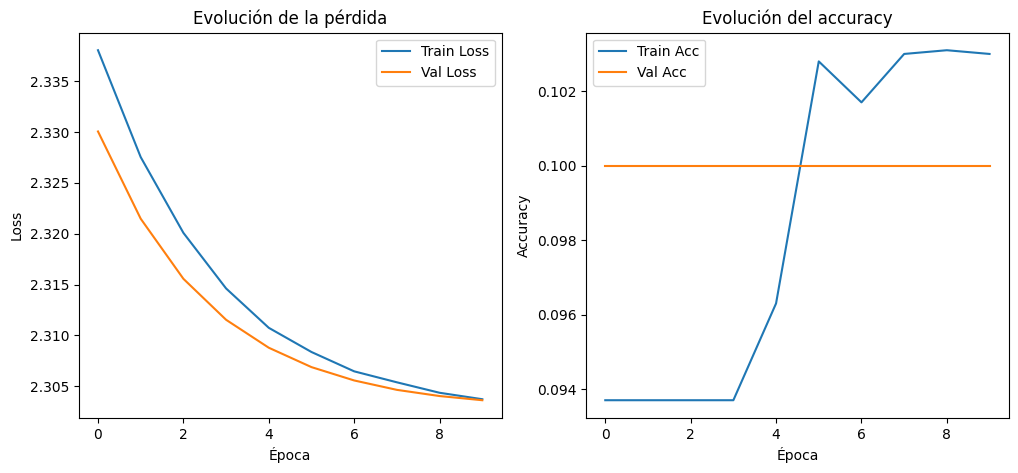

Epoch 1/10 - Loss: 2.3015 - Acc: 0.1184 - Val Loss: 2.2938 - Val Acc: 0.1542
Epoch 2/10 - Loss: 2.2882 - Acc: 0.1610 - Val Loss: 2.2831 - Val Acc: 0.1520
Epoch 3/10 - Loss: 2.2781 - Acc: 0.1632 - Val Loss: 2.2730 - Val Acc: 0.1771
Epoch 4/10 - Loss: 2.2674 - Acc: 0.1733 - Val Loss: 2.2627 - Val Acc: 0.1751
Epoch 5/10 - Loss: 2.2566 - Acc: 0.1739 - Val Loss: 2.2518 - Val Acc: 0.1753
Epoch 6/10 - Loss: 2.2446 - Acc: 0.1794 - Val Loss: 2.2398 - Val Acc: 0.1777
Epoch 7/10 - Loss: 2.2318 - Acc: 0.1828 - Val Loss: 2.2268 - Val Acc: 0.1868
Epoch 8/10 - Loss: 2.2173 - Acc: 0.1869 - Val Loss: 2.2124 - Val Acc: 0.1902
Epoch 9/10 - Loss: 2.2022 - Acc: 0.1970 - Val Loss: 2.1972 - Val Acc: 0.1931
Epoch 10/10 - Loss: 2.1858 - Acc: 0.2019 - Val Loss: 2.1813 - Val Acc: 0.2026


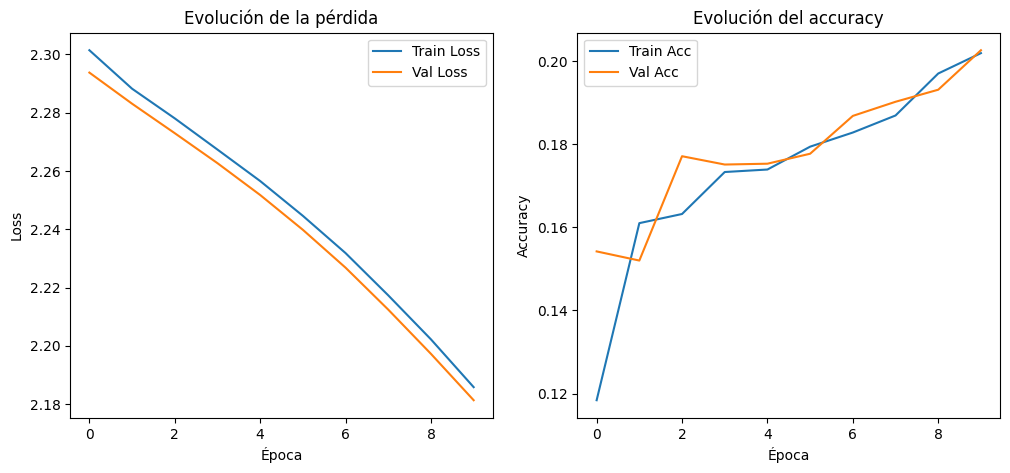

Epoch 1/10 - Loss: 2.3654 - Acc: 0.0974 - Val Loss: 2.3611 - Val Acc: 0.1000
Epoch 2/10 - Loss: 2.3635 - Acc: 0.0974 - Val Loss: 2.3592 - Val Acc: 0.1000
Epoch 3/10 - Loss: 2.3619 - Acc: 0.0974 - Val Loss: 2.3573 - Val Acc: 0.1000
Epoch 4/10 - Loss: 2.3593 - Acc: 0.0974 - Val Loss: 2.3555 - Val Acc: 0.1000
Epoch 5/10 - Loss: 2.3580 - Acc: 0.0974 - Val Loss: 2.3538 - Val Acc: 0.1000
Epoch 6/10 - Loss: 2.3553 - Acc: 0.0974 - Val Loss: 2.3521 - Val Acc: 0.1000
Epoch 7/10 - Loss: 2.3533 - Acc: 0.0974 - Val Loss: 2.3505 - Val Acc: 0.1000
Epoch 8/10 - Loss: 2.3523 - Acc: 0.0974 - Val Loss: 2.3489 - Val Acc: 0.1000
Epoch 9/10 - Loss: 2.3509 - Acc: 0.0974 - Val Loss: 2.3474 - Val Acc: 0.1000
Epoch 10/10 - Loss: 2.3499 - Acc: 0.0974 - Val Loss: 2.3460 - Val Acc: 0.1000


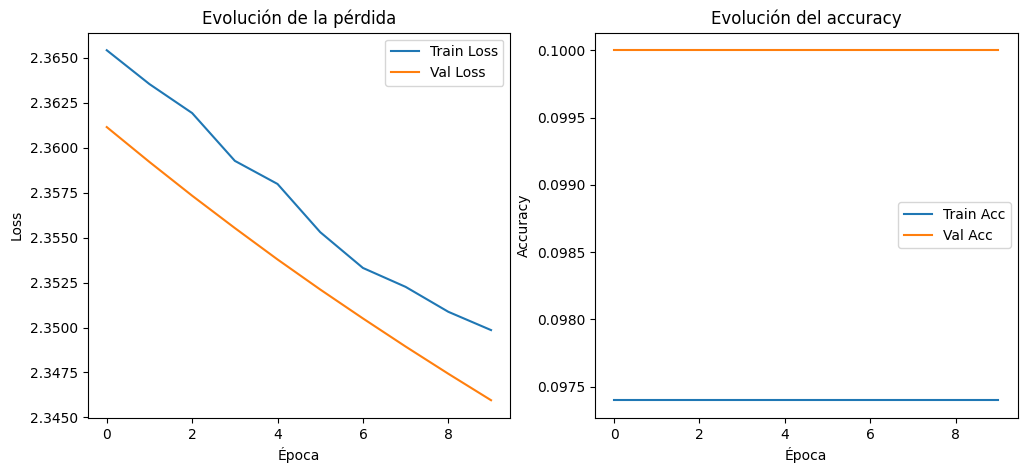

Epoch 1/10 - Loss: 2.3070 - Acc: 0.1013 - Val Loss: 2.3066 - Val Acc: 0.0982
Epoch 2/10 - Loss: 2.3052 - Acc: 0.1017 - Val Loss: 2.3049 - Val Acc: 0.0980
Epoch 3/10 - Loss: 2.3035 - Acc: 0.1013 - Val Loss: 2.3033 - Val Acc: 0.0975
Epoch 4/10 - Loss: 2.3025 - Acc: 0.1018 - Val Loss: 2.3018 - Val Acc: 0.0966
Epoch 5/10 - Loss: 2.3008 - Acc: 0.1014 - Val Loss: 2.3005 - Val Acc: 0.0989
Epoch 6/10 - Loss: 2.2996 - Acc: 0.1028 - Val Loss: 2.2993 - Val Acc: 0.1023
Epoch 7/10 - Loss: 2.2985 - Acc: 0.1057 - Val Loss: 2.2981 - Val Acc: 0.1082
Epoch 8/10 - Loss: 2.2969 - Acc: 0.1098 - Val Loss: 2.2969 - Val Acc: 0.1145
Epoch 9/10 - Loss: 2.2960 - Acc: 0.1167 - Val Loss: 2.2959 - Val Acc: 0.1207
Epoch 10/10 - Loss: 2.2949 - Acc: 0.1243 - Val Loss: 2.2949 - Val Acc: 0.1291


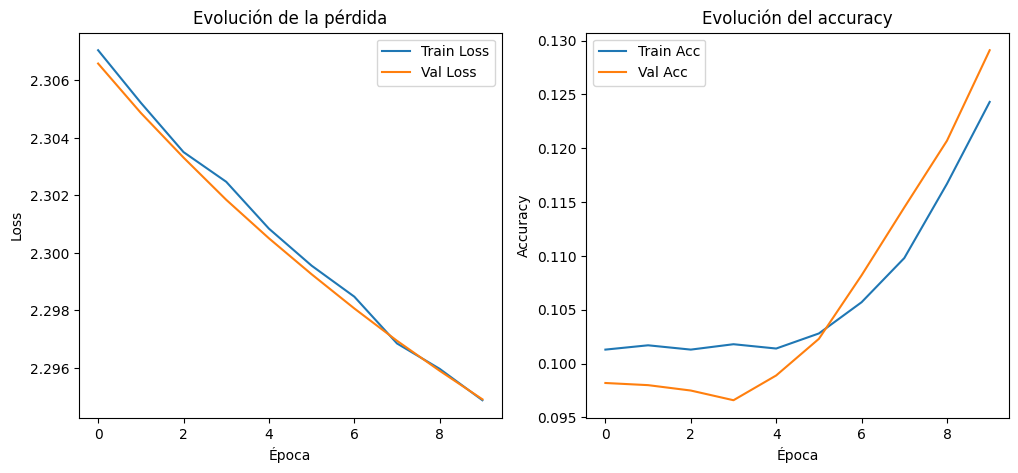

hidden  learning_rate      act  val_acc     val_loss
19      [64, 32]          0.100   linear   0.3252     1.903781
13         [128]          0.100   linear   0.3108     1.927037
15         [128]          0.010   linear   0.3094     2.020195
25  [32, 32, 32]          0.100   linear   0.3086     1.912850
9           [64]          0.010   linear   0.3082     2.023782
0           [32]          0.100  sigmoid   0.3004     2.022965
3           [32]          0.010   linear   0.2979     2.044566
6           [64]          0.100  sigmoid   0.2975     2.009238
12         [128]          0.100  sigmoid   0.2974     1.992499
21      [64, 32]          0.010   linear   0.2335     2.148228
14         [128]          0.010  sigmoid   0.2137     2.261213
27  [32, 32, 32]          0.010   linear   0.2026     2.181325
8           [64]          0.010  sigmoid   0.2000     2.265524
17         [128]          0.001   linear   0.1910     2.247565
11          [64]          0.001   linear   0.1753     2.250934
18      [64, 32]          0.100  sigmoid   0.1531     2.295250
5           [32]          0.001   linear   0.1524     2.258194
2           [32]          0.010  sigmoid   0.1491     2.276127
20      [64, 32]          0.010  sigmoid   0.1357     2.303287
16         [128]          0.001  sigmoid   0.1319     2.301032
23      [64, 32]          0.001   linear   0.1308     2.280458
29  [32, 32, 32]          0.001   linear   0.1291     2.294908
4           [32]          0.001  sigmoid   0.1005     2.302695
24  [32, 32, 32]          0.100  sigmoid   0.1001     2.302856
1           [32]          0.100   linear   0.1000  1407.709351
7           [64]          0.100   linear   0.1000  3966.617920
26  [32, 32, 32]          0.010  sigmoid   0.1000     2.303627
22      [64, 32]          0.001  sigmoid   0.1000     2.321842
28  [32, 32, 32]          0.001  sigmoid   0.1000     2.345958
10          [64]          0.001  sigmoid   0.0999     2.309875

In [ ]:
output_layer_size = 10
pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size], learning_rate=lr, activation=act, num_workers=num_workers
    )
    print(f"Entrenando con f(x) activación={act}, capas={hs}, lr={lr}")
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        batch_size=batch_size,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)

In [35]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar100(f"data/CIFAR-100")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)  # epochs puede ajustarse

Epoch 1/10 - Loss: 4.6264 - Acc: 0.0103 - Val Loss: 4.6157 - Val Acc: 0.0102
Epoch 2/10 - Loss: 4.6090 - Acc: 0.0119 - Val Loss: 4.6091 - Val Acc: 0.0109
Epoch 3/10 - Loss: 4.6033 - Acc: 0.0140 - Val Loss: 4.6050 - Val Acc: 0.0130
Epoch 4/10 - Loss: 4.5984 - Acc: 0.0133 - Val Loss: 4.6016 - Val Acc: 0.0142
Epoch 5/10 - Loss: 4.5938 - Acc: 0.0155 - Val Loss: 4.5978 - Val Acc: 0.0146
Epoch 6/10 - Loss: 4.5887 - Acc: 0.0149 - Val Loss: 4.5940 - Val Acc: 0.0148
Epoch 7/10 - Loss: 4.5839 - Acc: 0.0154 - Val Loss: 4.5897 - Val Acc: 0.0148
Epoch 8/10 - Loss: 4.5783 - Acc: 0.0153 - Val Loss: 4.5851 - Val Acc: 0.0149
Epoch 9/10 - Loss: 4.5725 - Acc: 0.0176 - Val Loss: 4.5800 - Val Acc: 0.0159
Epoch 10/10 - Loss: 4.5668 - Acc: 0.0163 - Val Loss: 4.5745 - Val Acc: 0.0162


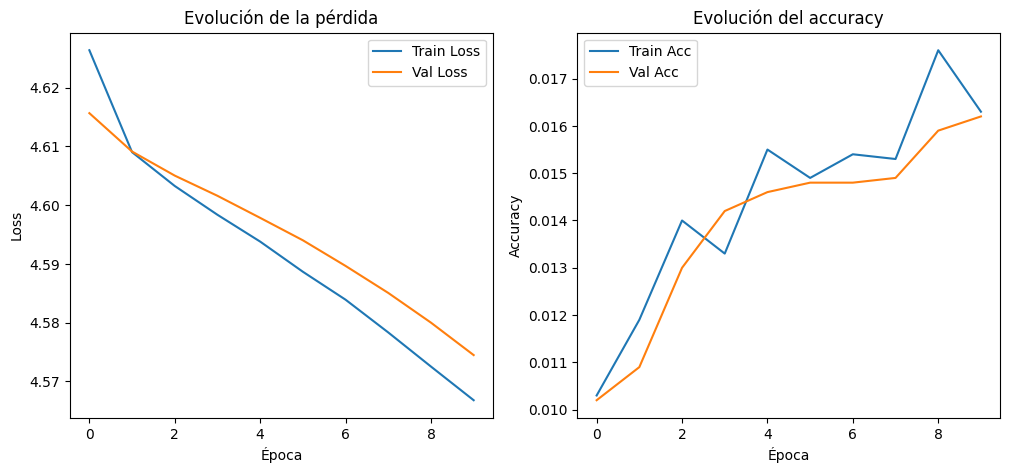

Epoch 1/10 - Loss: 4.5986 - Acc: 0.0152 - Val Loss: 4.5568 - Val Acc: 0.0236
Epoch 2/10 - Loss: 4.5406 - Acc: 0.0261 - Val Loss: 4.5425 - Val Acc: 0.0247
Epoch 3/10 - Loss: 4.4528 - Acc: 0.0336 - Val Loss: 4.4601 - Val Acc: 0.0405
Epoch 4/10 - Loss: 4.3712 - Acc: 0.0464 - Val Loss: 4.3805 - Val Acc: 0.0444
Epoch 5/10 - Loss: 4.2846 - Acc: 0.0589 - Val Loss: 4.3181 - Val Acc: 0.0505
Epoch 6/10 - Loss: 4.2130 - Acc: 0.0651 - Val Loss: 4.2386 - Val Acc: 0.0543
Epoch 7/10 - Loss: 4.1589 - Acc: 0.0711 - Val Loss: 4.1958 - Val Acc: 0.0695
Epoch 8/10 - Loss: 4.1284 - Acc: 0.0772 - Val Loss: 4.1679 - Val Acc: 0.0644
Epoch 9/10 - Loss: 4.0712 - Acc: 0.0829 - Val Loss: 4.1174 - Val Acc: 0.0813
Epoch 10/10 - Loss: 4.0275 - Acc: 0.0948 - Val Loss: 4.0991 - Val Acc: 0.0745


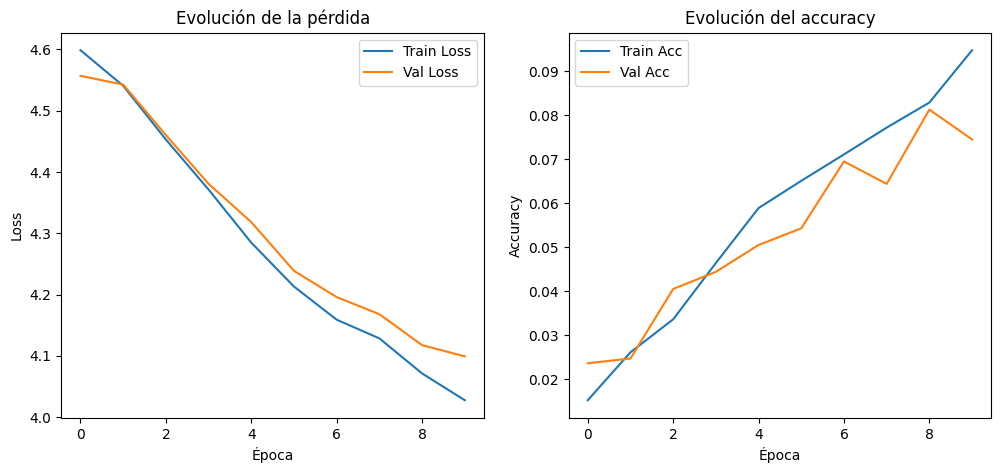

Epoch 1/10 - Loss: 4.6376 - Acc: 0.0107 - Val Loss: 4.6343 - Val Acc: 0.0119
Epoch 2/10 - Loss: 4.6313 - Acc: 0.0113 - Val Loss: 4.6288 - Val Acc: 0.0125
Epoch 3/10 - Loss: 4.6255 - Acc: 0.0119 - Val Loss: 4.6248 - Val Acc: 0.0124
Epoch 4/10 - Loss: 4.6215 - Acc: 0.0114 - Val Loss: 4.6218 - Val Acc: 0.0115
Epoch 5/10 - Loss: 4.6190 - Acc: 0.0113 - Val Loss: 4.6195 - Val Acc: 0.0112
Epoch 6/10 - Loss: 4.6162 - Acc: 0.0115 - Val Loss: 4.6176 - Val Acc: 0.0103
Epoch 7/10 - Loss: 4.6144 - Acc: 0.0107 - Val Loss: 4.6160 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6124 - Acc: 0.0109 - Val Loss: 4.6147 - Val Acc: 0.0099
Epoch 9/10 - Loss: 4.6108 - Acc: 0.0113 - Val Loss: 4.6135 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6097 - Acc: 0.0110 - Val Loss: 4.6124 - Val Acc: 0.0103


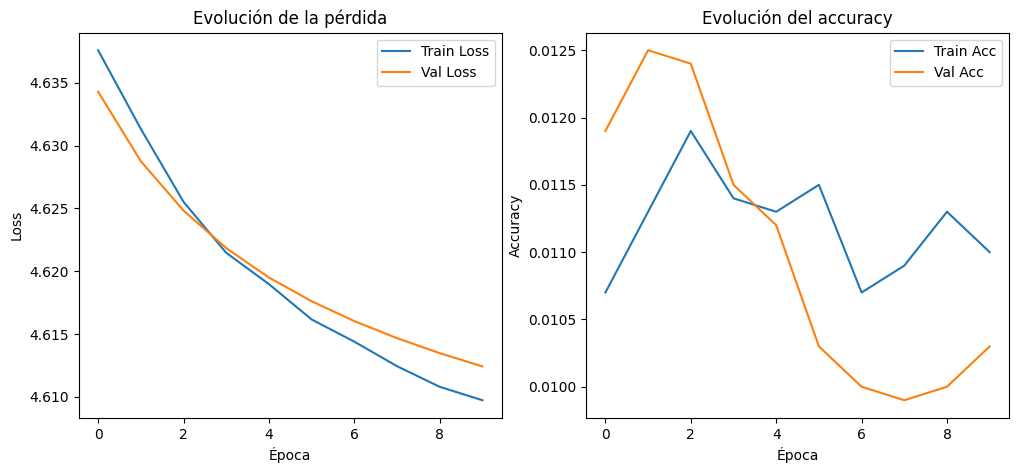

Epoch 1/10 - Loss: 4.6116 - Acc: 0.0120 - Val Loss: 4.6038 - Val Acc: 0.0113
Epoch 2/10 - Loss: 4.5983 - Acc: 0.0139 - Val Loss: 4.5949 - Val Acc: 0.0130
Epoch 3/10 - Loss: 4.5891 - Acc: 0.0177 - Val Loss: 4.5875 - Val Acc: 0.0166
Epoch 4/10 - Loss: 4.5802 - Acc: 0.0236 - Val Loss: 4.5808 - Val Acc: 0.0212
Epoch 5/10 - Loss: 4.5724 - Acc: 0.0243 - Val Loss: 4.5730 - Val Acc: 0.0264
Epoch 6/10 - Loss: 4.5648 - Acc: 0.0305 - Val Loss: 4.5672 - Val Acc: 0.0291
Epoch 7/10 - Loss: 4.5574 - Acc: 0.0303 - Val Loss: 4.5598 - Val Acc: 0.0324
Epoch 8/10 - Loss: 4.5503 - Acc: 0.0371 - Val Loss: 4.5539 - Val Acc: 0.0334
Epoch 9/10 - Loss: 4.5436 - Acc: 0.0373 - Val Loss: 4.5475 - Val Acc: 0.0340
Epoch 10/10 - Loss: 4.5360 - Acc: 0.0385 - Val Loss: 4.5423 - Val Acc: 0.0353


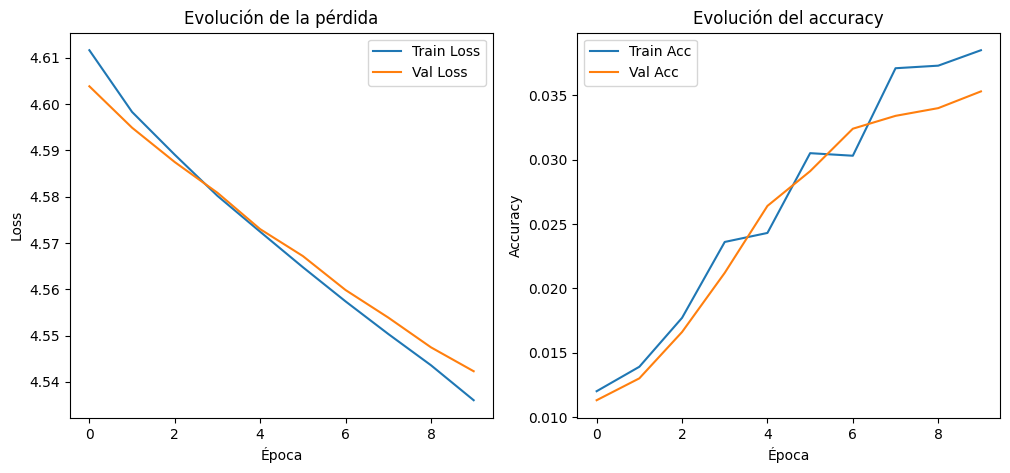

Epoch 1/10 - Loss: 4.6485 - Acc: 0.0109 - Val Loss: 4.6482 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6473 - Acc: 0.0109 - Val Loss: 4.6472 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6462 - Acc: 0.0109 - Val Loss: 4.6463 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6448 - Acc: 0.0109 - Val Loss: 4.6454 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6440 - Acc: 0.0109 - Val Loss: 4.6445 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6440 - Acc: 0.0109 - Val Loss: 4.6436 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6423 - Acc: 0.0109 - Val Loss: 4.6428 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6417 - Acc: 0.0109 - Val Loss: 4.6420 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6408 - Acc: 0.0109 - Val Loss: 4.6412 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6405 - Acc: 0.0109 - Val Loss: 4.6404 - Val Acc: 0.0100


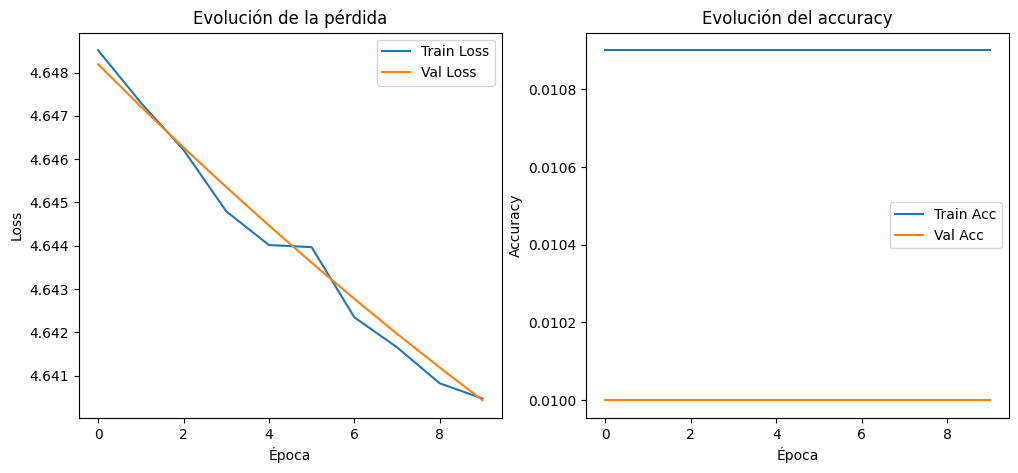

Epoch 1/10 - Loss: 4.6253 - Acc: 0.0108 - Val Loss: 4.6218 - Val Acc: 0.0105
Epoch 2/10 - Loss: 4.6197 - Acc: 0.0117 - Val Loss: 4.6178 - Val Acc: 0.0105
Epoch 3/10 - Loss: 4.6156 - Acc: 0.0125 - Val Loss: 4.6149 - Val Acc: 0.0108
Epoch 4/10 - Loss: 4.6130 - Acc: 0.0122 - Val Loss: 4.6127 - Val Acc: 0.0114
Epoch 5/10 - Loss: 4.6108 - Acc: 0.0118 - Val Loss: 4.6109 - Val Acc: 0.0122
Epoch 6/10 - Loss: 4.6086 - Acc: 0.0121 - Val Loss: 4.6093 - Val Acc: 0.0122
Epoch 7/10 - Loss: 4.6069 - Acc: 0.0126 - Val Loss: 4.6079 - Val Acc: 0.0121
Epoch 8/10 - Loss: 4.6056 - Acc: 0.0127 - Val Loss: 4.6066 - Val Acc: 0.0126
Epoch 9/10 - Loss: 4.6043 - Acc: 0.0140 - Val Loss: 4.6054 - Val Acc: 0.0131
Epoch 10/10 - Loss: 4.6028 - Acc: 0.0151 - Val Loss: 4.6042 - Val Acc: 0.0136


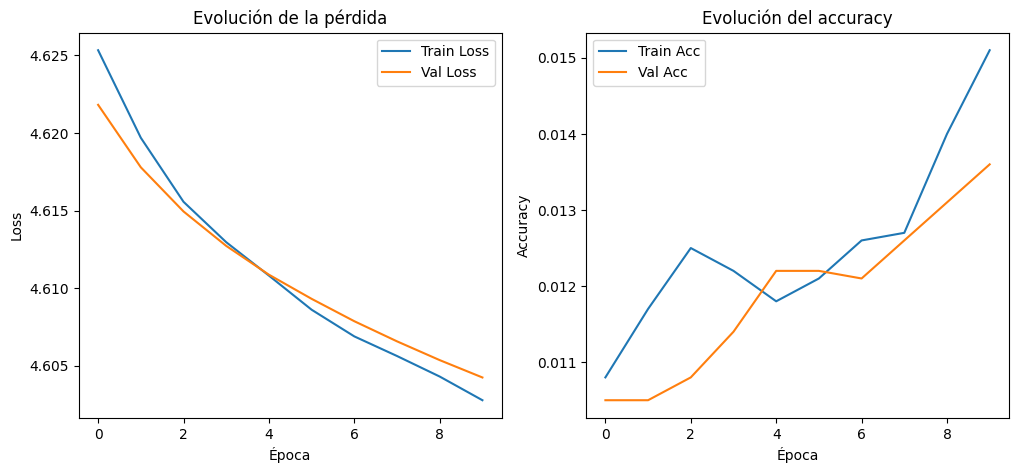

Epoch 1/10 - Loss: 4.6253 - Acc: 0.0096 - Val Loss: 4.6128 - Val Acc: 0.0105
Epoch 2/10 - Loss: 4.6026 - Acc: 0.0136 - Val Loss: 4.6025 - Val Acc: 0.0138
Epoch 3/10 - Loss: 4.5919 - Acc: 0.0201 - Val Loss: 4.5952 - Val Acc: 0.0204
Epoch 4/10 - Loss: 4.5833 - Acc: 0.0239 - Val Loss: 4.5881 - Val Acc: 0.0216
Epoch 5/10 - Loss: 4.5748 - Acc: 0.0275 - Val Loss: 4.5808 - Val Acc: 0.0222
Epoch 6/10 - Loss: 4.5664 - Acc: 0.0315 - Val Loss: 4.5734 - Val Acc: 0.0253
Epoch 7/10 - Loss: 4.5578 - Acc: 0.0318 - Val Loss: 4.5656 - Val Acc: 0.0294
Epoch 8/10 - Loss: 4.5493 - Acc: 0.0366 - Val Loss: 4.5568 - Val Acc: 0.0333
Epoch 9/10 - Loss: 4.5396 - Acc: 0.0434 - Val Loss: 4.5485 - Val Acc: 0.0331
Epoch 10/10 - Loss: 4.5292 - Acc: 0.0456 - Val Loss: 4.5390 - Val Acc: 0.0396


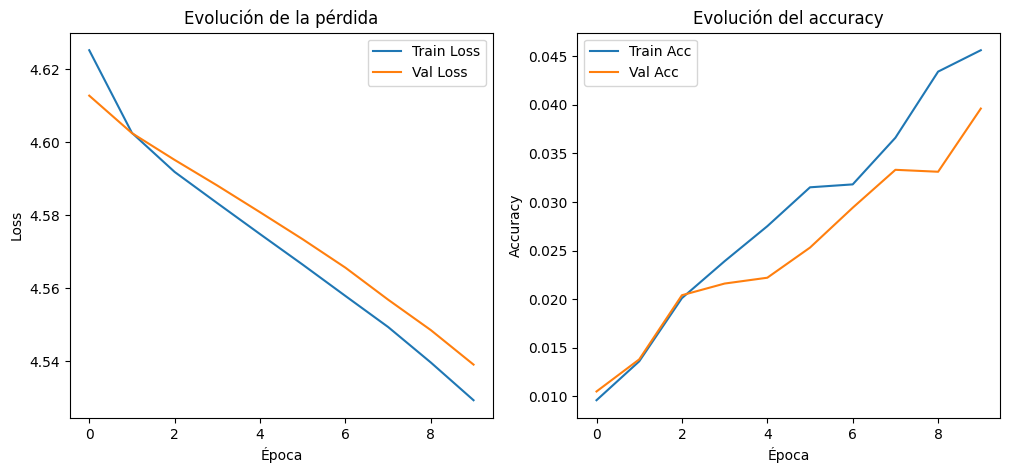

Epoch 1/10 - Loss: 4.5847 - Acc: 0.0167 - Val Loss: 4.5595 - Val Acc: 0.0163
Epoch 2/10 - Loss: 4.4783 - Acc: 0.0344 - Val Loss: 4.4569 - Val Acc: 0.0311
Epoch 3/10 - Loss: 4.3756 - Acc: 0.0463 - Val Loss: 4.3639 - Val Acc: 0.0476
Epoch 4/10 - Loss: 4.2767 - Acc: 0.0588 - Val Loss: 4.2806 - Val Acc: 0.0541
Epoch 5/10 - Loss: 4.1928 - Acc: 0.0732 - Val Loss: 4.2083 - Val Acc: 0.0687
Epoch 6/10 - Loss: 4.1236 - Acc: 0.0854 - Val Loss: 4.1668 - Val Acc: 0.0710
Epoch 7/10 - Loss: 4.0704 - Acc: 0.0894 - Val Loss: 4.1343 - Val Acc: 0.0882
Epoch 8/10 - Loss: 4.0287 - Acc: 0.0971 - Val Loss: 4.0955 - Val Acc: 0.0738
Epoch 9/10 - Loss: 3.9934 - Acc: 0.1015 - Val Loss: 4.0709 - Val Acc: 0.0883
Epoch 10/10 - Loss: 3.9585 - Acc: 0.1100 - Val Loss: 4.0741 - Val Acc: 0.0842


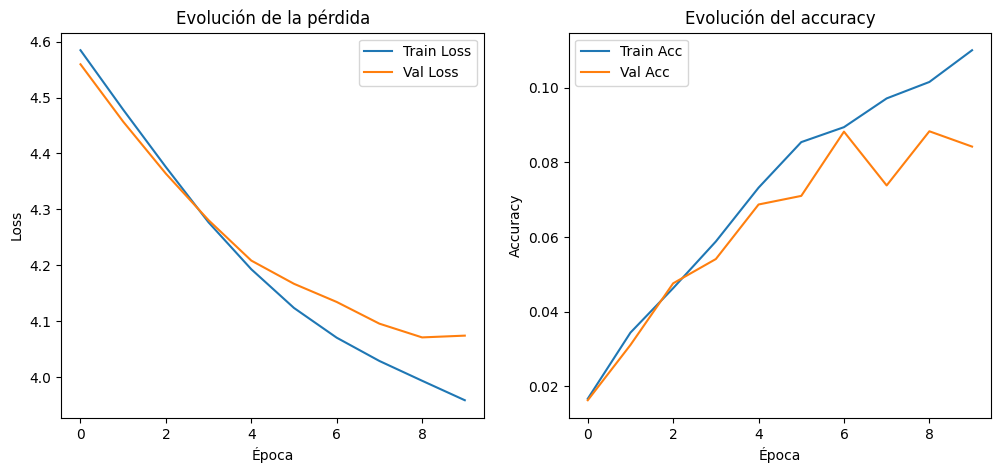

Epoch 1/10 - Loss: 4.6458 - Acc: 0.0095 - Val Loss: 4.6452 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6379 - Acc: 0.0093 - Val Loss: 4.6377 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6306 - Acc: 0.0114 - Val Loss: 4.6319 - Val Acc: 0.0113
Epoch 4/10 - Loss: 4.6255 - Acc: 0.0125 - Val Loss: 4.6274 - Val Acc: 0.0124
Epoch 5/10 - Loss: 4.6209 - Acc: 0.0133 - Val Loss: 4.6238 - Val Acc: 0.0116
Epoch 6/10 - Loss: 4.6177 - Acc: 0.0140 - Val Loss: 4.6209 - Val Acc: 0.0113
Epoch 7/10 - Loss: 4.6152 - Acc: 0.0139 - Val Loss: 4.6183 - Val Acc: 0.0106
Epoch 8/10 - Loss: 4.6123 - Acc: 0.0134 - Val Loss: 4.6161 - Val Acc: 0.0101
Epoch 9/10 - Loss: 4.6098 - Acc: 0.0132 - Val Loss: 4.6143 - Val Acc: 0.0102
Epoch 10/10 - Loss: 4.6076 - Acc: 0.0130 - Val Loss: 4.6126 - Val Acc: 0.0101


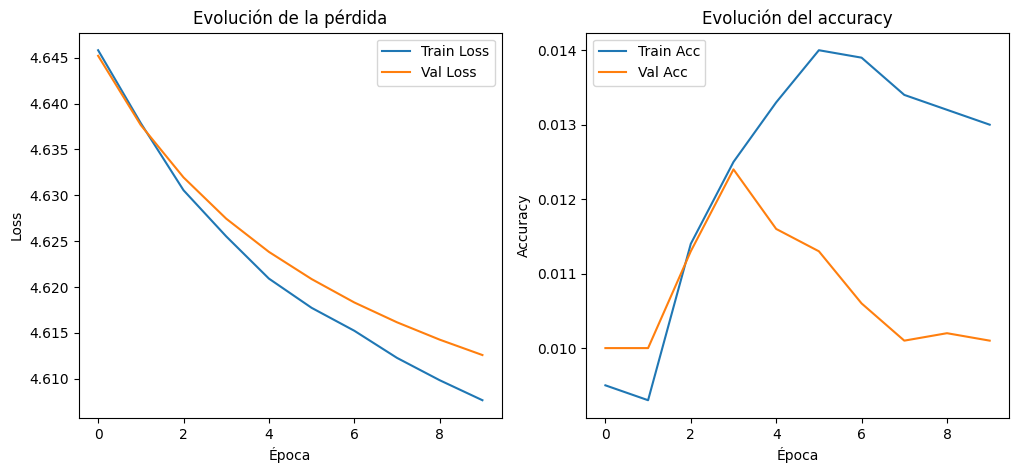

Epoch 1/10 - Loss: 4.6050 - Acc: 0.0127 - Val Loss: 4.5977 - Val Acc: 0.0140
Epoch 2/10 - Loss: 4.5882 - Acc: 0.0168 - Val Loss: 4.5850 - Val Acc: 0.0189
Epoch 3/10 - Loss: 4.5759 - Acc: 0.0208 - Val Loss: 4.5752 - Val Acc: 0.0222
Epoch 4/10 - Loss: 4.5649 - Acc: 0.0246 - Val Loss: 4.5654 - Val Acc: 0.0236
Epoch 5/10 - Loss: 4.5541 - Acc: 0.0288 - Val Loss: 4.5561 - Val Acc: 0.0255
Epoch 6/10 - Loss: 4.5437 - Acc: 0.0308 - Val Loss: 4.5472 - Val Acc: 0.0268
Epoch 7/10 - Loss: 4.5335 - Acc: 0.0339 - Val Loss: 4.5382 - Val Acc: 0.0314
Epoch 8/10 - Loss: 4.5240 - Acc: 0.0385 - Val Loss: 4.5293 - Val Acc: 0.0322
Epoch 9/10 - Loss: 4.5131 - Acc: 0.0384 - Val Loss: 4.5196 - Val Acc: 0.0348
Epoch 10/10 - Loss: 4.5032 - Acc: 0.0430 - Val Loss: 4.5111 - Val Acc: 0.0328


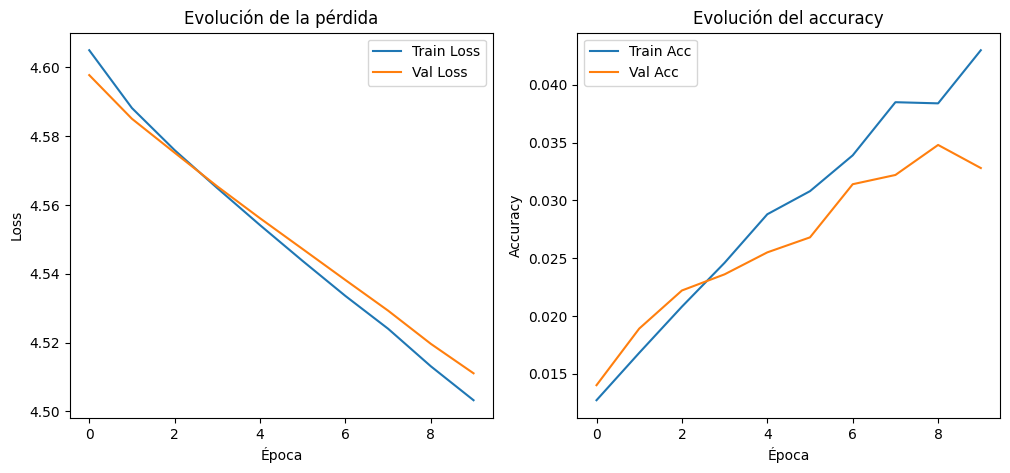

Epoch 1/10 - Loss: 4.6575 - Acc: 0.0093 - Val Loss: 4.6556 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6557 - Acc: 0.0093 - Val Loss: 4.6543 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6540 - Acc: 0.0093 - Val Loss: 4.6531 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6529 - Acc: 0.0093 - Val Loss: 4.6519 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6520 - Acc: 0.0093 - Val Loss: 4.6508 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6517 - Acc: 0.0093 - Val Loss: 4.6497 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6494 - Acc: 0.0093 - Val Loss: 4.6486 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6489 - Acc: 0.0093 - Val Loss: 4.6476 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6480 - Acc: 0.0093 - Val Loss: 4.6466 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6467 - Acc: 0.0093 - Val Loss: 4.6456 - Val Acc: 0.0100


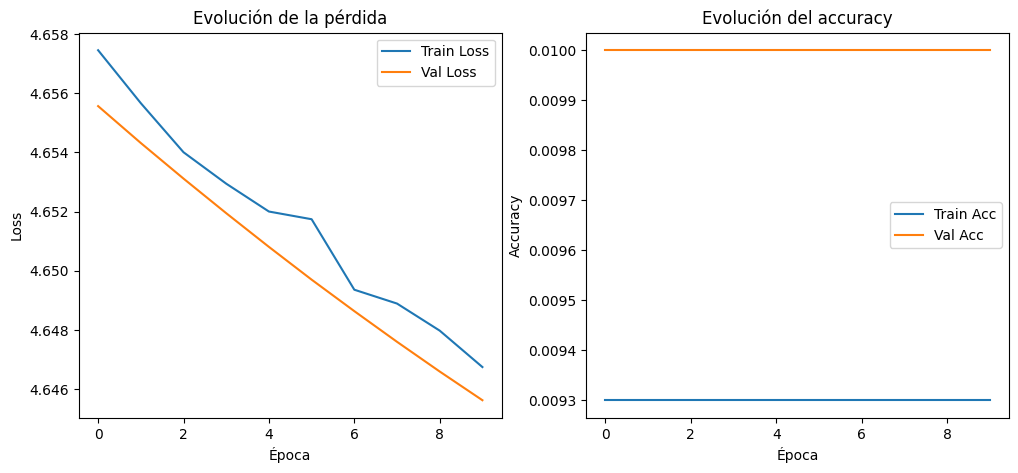

Epoch 1/10 - Loss: 4.6139 - Acc: 0.0127 - Val Loss: 4.6161 - Val Acc: 0.0114
Epoch 2/10 - Loss: 4.6106 - Acc: 0.0125 - Val Loss: 4.6130 - Val Acc: 0.0109
Epoch 3/10 - Loss: 4.6073 - Acc: 0.0118 - Val Loss: 4.6104 - Val Acc: 0.0101
Epoch 4/10 - Loss: 4.6045 - Acc: 0.0105 - Val Loss: 4.6082 - Val Acc: 0.0101
Epoch 5/10 - Loss: 4.6021 - Acc: 0.0102 - Val Loss: 4.6062 - Val Acc: 0.0098
Epoch 6/10 - Loss: 4.5998 - Acc: 0.0097 - Val Loss: 4.6045 - Val Acc: 0.0101
Epoch 7/10 - Loss: 4.5982 - Acc: 0.0105 - Val Loss: 4.6028 - Val Acc: 0.0099
Epoch 8/10 - Loss: 4.5959 - Acc: 0.0112 - Val Loss: 4.6013 - Val Acc: 0.0097
Epoch 9/10 - Loss: 4.5944 - Acc: 0.0104 - Val Loss: 4.5999 - Val Acc: 0.0097
Epoch 10/10 - Loss: 4.5928 - Acc: 0.0111 - Val Loss: 4.5985 - Val Acc: 0.0100


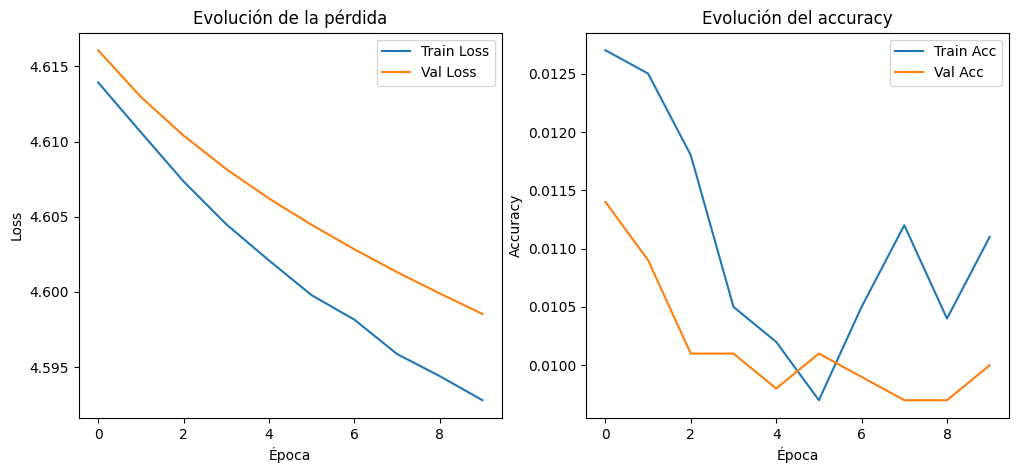

Epoch 1/10 - Loss: 4.6195 - Acc: 0.0098 - Val Loss: 4.6037 - Val Acc: 0.0200
Epoch 2/10 - Loss: 4.5952 - Acc: 0.0184 - Val Loss: 4.5933 - Val Acc: 0.0190
Epoch 3/10 - Loss: 4.5837 - Acc: 0.0217 - Val Loss: 4.5856 - Val Acc: 0.0193
Epoch 4/10 - Loss: 4.5744 - Acc: 0.0223 - Val Loss: 4.5782 - Val Acc: 0.0303
Epoch 5/10 - Loss: 4.5662 - Acc: 0.0284 - Val Loss: 4.5704 - Val Acc: 0.0255
Epoch 6/10 - Loss: 4.5568 - Acc: 0.0320 - Val Loss: 4.5622 - Val Acc: 0.0362
Epoch 7/10 - Loss: 4.5472 - Acc: 0.0419 - Val Loss: 4.5532 - Val Acc: 0.0319
Epoch 8/10 - Loss: 4.5373 - Acc: 0.0401 - Val Loss: 4.5431 - Val Acc: 0.0435
Epoch 9/10 - Loss: 4.5257 - Acc: 0.0489 - Val Loss: 4.5327 - Val Acc: 0.0452
Epoch 10/10 - Loss: 4.5138 - Acc: 0.0504 - Val Loss: 4.5212 - Val Acc: 0.0442


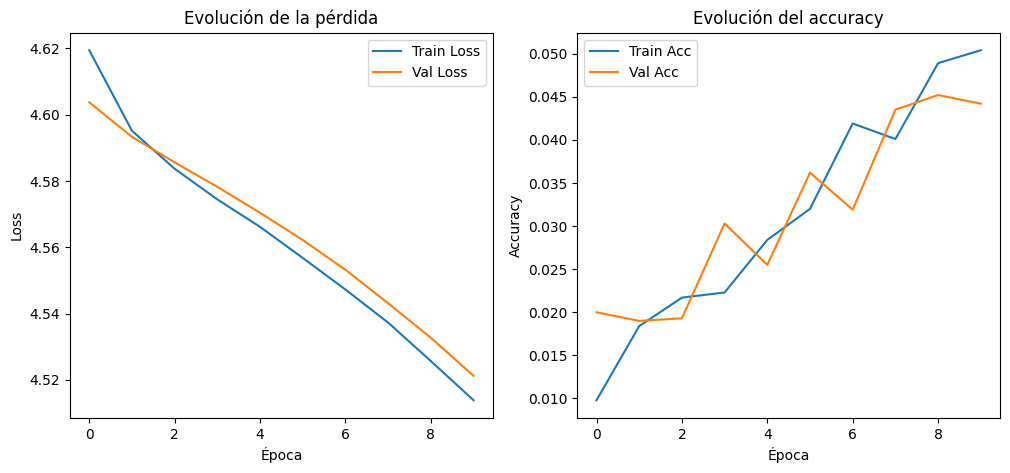

Epoch 1/10 - Loss: 4.5787 - Acc: 0.0190 - Val Loss: 4.5306 - Val Acc: 0.0335
Epoch 2/10 - Loss: 4.4742 - Acc: 0.0385 - Val Loss: 4.4381 - Val Acc: 0.0358
Epoch 3/10 - Loss: 4.3592 - Acc: 0.0561 - Val Loss: 4.3366 - Val Acc: 0.0461
Epoch 4/10 - Loss: 4.2473 - Acc: 0.0667 - Val Loss: 4.2417 - Val Acc: 0.0564
Epoch 5/10 - Loss: 4.1632 - Acc: 0.0785 - Val Loss: 4.1749 - Val Acc: 0.0690
Epoch 6/10 - Loss: 4.0989 - Acc: 0.0853 - Val Loss: 4.1276 - Val Acc: 0.0762
Epoch 7/10 - Loss: 4.0525 - Acc: 0.0929 - Val Loss: 4.0940 - Val Acc: 0.0903
Epoch 8/10 - Loss: 4.0155 - Acc: 0.0989 - Val Loss: 4.0727 - Val Acc: 0.0892
Epoch 9/10 - Loss: 3.9735 - Acc: 0.1048 - Val Loss: 4.0393 - Val Acc: 0.0912
Epoch 10/10 - Loss: 3.9478 - Acc: 0.1182 - Val Loss: 4.0282 - Val Acc: 0.0951


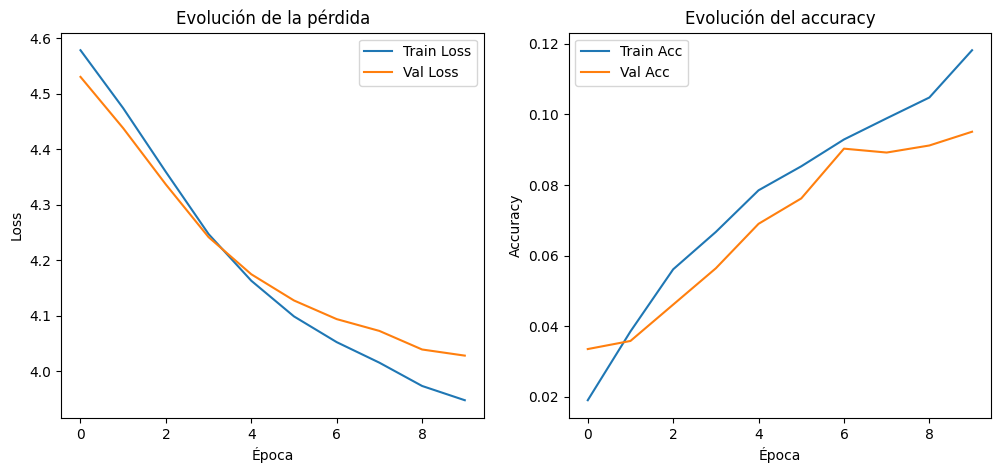

Epoch 1/10 - Loss: 4.6489 - Acc: 0.0092 - Val Loss: 4.6435 - Val Acc: 0.0101
Epoch 2/10 - Loss: 4.6380 - Acc: 0.0093 - Val Loss: 4.6356 - Val Acc: 0.0101
Epoch 3/10 - Loss: 4.6307 - Acc: 0.0094 - Val Loss: 4.6295 - Val Acc: 0.0102
Epoch 4/10 - Loss: 4.6244 - Acc: 0.0095 - Val Loss: 4.6246 - Val Acc: 0.0101
Epoch 5/10 - Loss: 4.6192 - Acc: 0.0096 - Val Loss: 4.6205 - Val Acc: 0.0103
Epoch 6/10 - Loss: 4.6154 - Acc: 0.0096 - Val Loss: 4.6172 - Val Acc: 0.0103
Epoch 7/10 - Loss: 4.6109 - Acc: 0.0116 - Val Loss: 4.6143 - Val Acc: 0.0120
Epoch 8/10 - Loss: 4.6079 - Acc: 0.0126 - Val Loss: 4.6119 - Val Acc: 0.0132
Epoch 9/10 - Loss: 4.6053 - Acc: 0.0171 - Val Loss: 4.6097 - Val Acc: 0.0137
Epoch 10/10 - Loss: 4.6026 - Acc: 0.0187 - Val Loss: 4.6078 - Val Acc: 0.0153


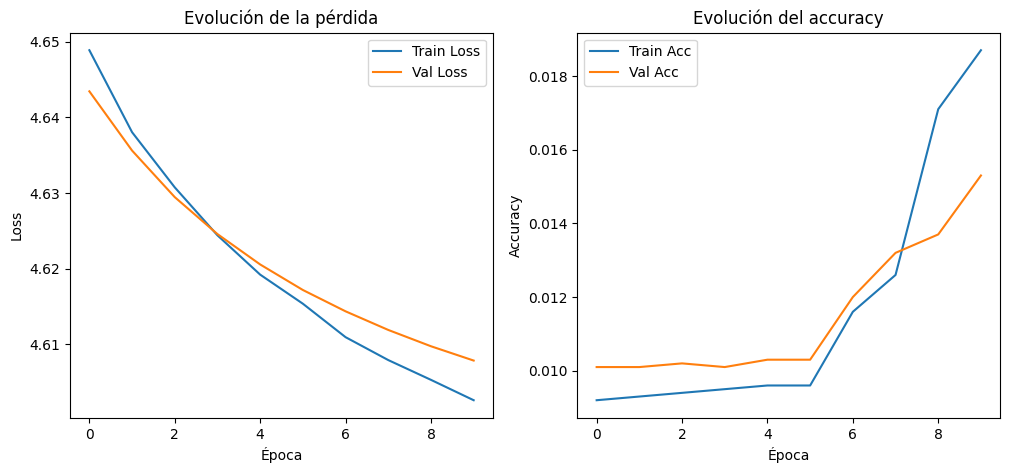

Epoch 1/10 - Loss: 4.6060 - Acc: 0.0131 - Val Loss: 4.5974 - Val Acc: 0.0155
Epoch 2/10 - Loss: 4.5878 - Acc: 0.0226 - Val Loss: 4.5852 - Val Acc: 0.0225
Epoch 3/10 - Loss: 4.5750 - Acc: 0.0243 - Val Loss: 4.5745 - Val Acc: 0.0266
Epoch 4/10 - Loss: 4.5625 - Acc: 0.0276 - Val Loss: 4.5646 - Val Acc: 0.0302
Epoch 5/10 - Loss: 4.5510 - Acc: 0.0343 - Val Loss: 4.5545 - Val Acc: 0.0327
Epoch 6/10 - Loss: 4.5397 - Acc: 0.0360 - Val Loss: 4.5447 - Val Acc: 0.0380
Epoch 7/10 - Loss: 4.5290 - Acc: 0.0417 - Val Loss: 4.5346 - Val Acc: 0.0434
Epoch 8/10 - Loss: 4.5179 - Acc: 0.0455 - Val Loss: 4.5249 - Val Acc: 0.0454
Epoch 9/10 - Loss: 4.5070 - Acc: 0.0506 - Val Loss: 4.5154 - Val Acc: 0.0433
Epoch 10/10 - Loss: 4.4958 - Acc: 0.0497 - Val Loss: 4.5053 - Val Acc: 0.0488


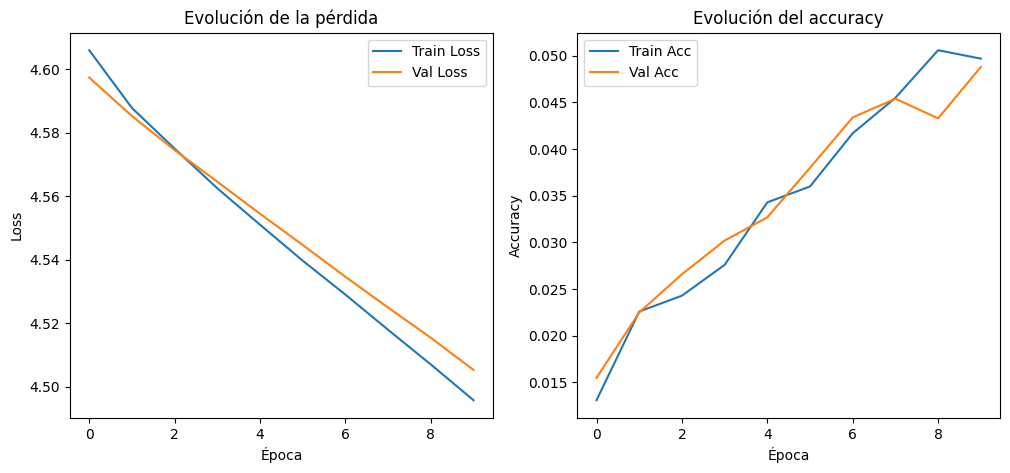

Epoch 1/10 - Loss: 4.6608 - Acc: 0.0112 - Val Loss: 4.6592 - Val Acc: 0.0099
Epoch 2/10 - Loss: 4.6591 - Acc: 0.0112 - Val Loss: 4.6579 - Val Acc: 0.0099
Epoch 3/10 - Loss: 4.6586 - Acc: 0.0112 - Val Loss: 4.6566 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6571 - Acc: 0.0112 - Val Loss: 4.6554 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6560 - Acc: 0.0112 - Val Loss: 4.6542 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6542 - Acc: 0.0112 - Val Loss: 4.6530 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6535 - Acc: 0.0112 - Val Loss: 4.6519 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6526 - Acc: 0.0112 - Val Loss: 4.6508 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6506 - Acc: 0.0112 - Val Loss: 4.6498 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6489 - Acc: 0.0112 - Val Loss: 4.6487 - Val Acc: 0.0100


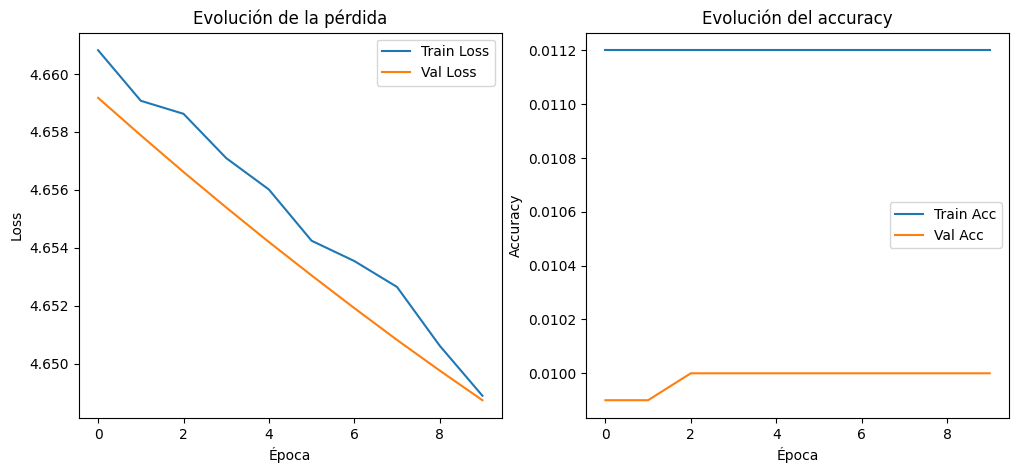

Epoch 1/10 - Loss: 4.6223 - Acc: 0.0155 - Val Loss: 4.6207 - Val Acc: 0.0145
Epoch 2/10 - Loss: 4.6180 - Acc: 0.0156 - Val Loss: 4.6171 - Val Acc: 0.0154
Epoch 3/10 - Loss: 4.6142 - Acc: 0.0158 - Val Loss: 4.6141 - Val Acc: 0.0152
Epoch 4/10 - Loss: 4.6112 - Acc: 0.0158 - Val Loss: 4.6115 - Val Acc: 0.0151
Epoch 5/10 - Loss: 4.6084 - Acc: 0.0159 - Val Loss: 4.6091 - Val Acc: 0.0154
Epoch 6/10 - Loss: 4.6058 - Acc: 0.0164 - Val Loss: 4.6070 - Val Acc: 0.0147
Epoch 7/10 - Loss: 4.6031 - Acc: 0.0158 - Val Loss: 4.6050 - Val Acc: 0.0149
Epoch 8/10 - Loss: 4.6008 - Acc: 0.0160 - Val Loss: 4.6033 - Val Acc: 0.0148
Epoch 9/10 - Loss: 4.5990 - Acc: 0.0166 - Val Loss: 4.6016 - Val Acc: 0.0148
Epoch 10/10 - Loss: 4.5969 - Acc: 0.0168 - Val Loss: 4.6001 - Val Acc: 0.0144


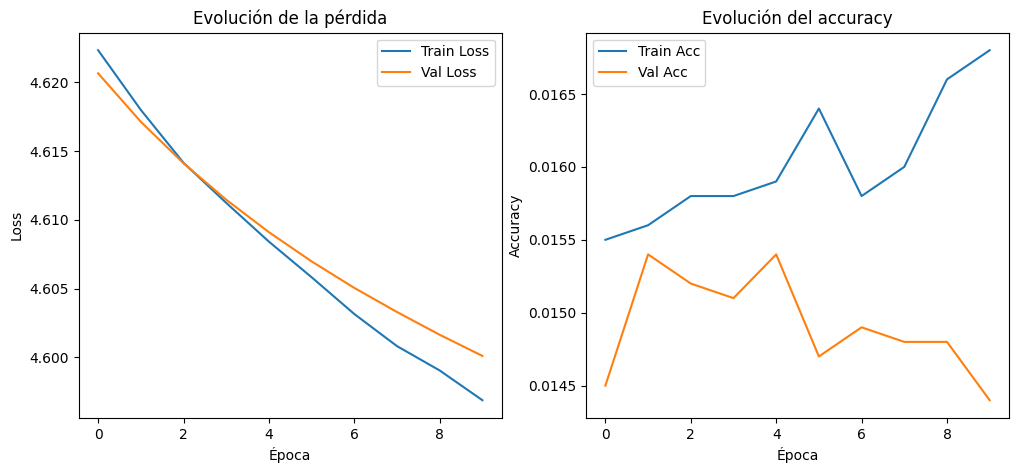

Epoch 1/10 - Loss: 4.6398 - Acc: 0.0115 - Val Loss: 4.6315 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6267 - Acc: 0.0115 - Val Loss: 4.6230 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6182 - Acc: 0.0115 - Val Loss: 4.6177 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6125 - Acc: 0.0115 - Val Loss: 4.6143 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6085 - Acc: 0.0115 - Val Loss: 4.6121 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6059 - Acc: 0.0115 - Val Loss: 4.6106 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6038 - Acc: 0.0115 - Val Loss: 4.6096 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6023 - Acc: 0.0115 - Val Loss: 4.6089 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6012 - Acc: 0.0115 - Val Loss: 4.6085 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6003 - Acc: 0.0115 - Val Loss: 4.6082 - Val Acc: 0.0087


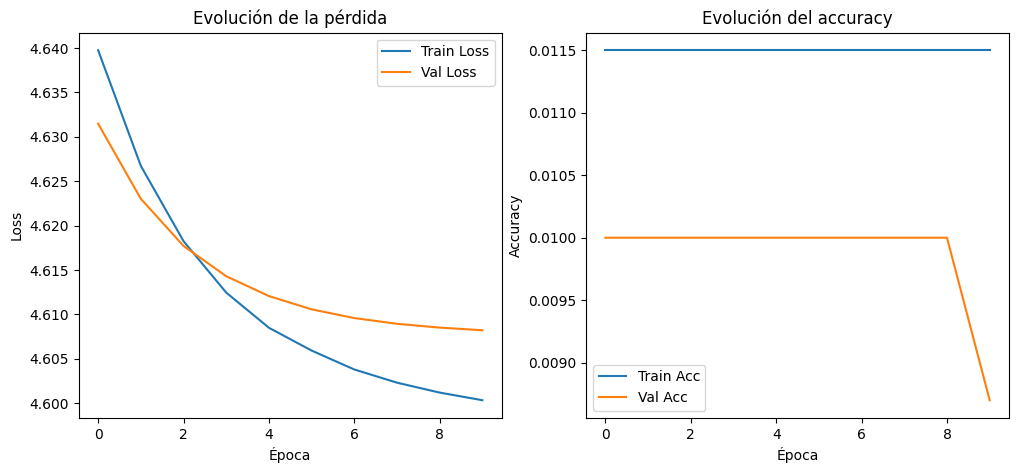

Epoch 1/10 - Loss: 4.5955 - Acc: 0.0119 - Val Loss: 4.5874 - Val Acc: 0.0214
Epoch 2/10 - Loss: 4.5533 - Acc: 0.0224 - Val Loss: 4.5383 - Val Acc: 0.0243
Epoch 3/10 - Loss: 4.5068 - Acc: 0.0298 - Val Loss: 4.4962 - Val Acc: 0.0208
Epoch 4/10 - Loss: 4.4514 - Acc: 0.0366 - Val Loss: 4.4347 - Val Acc: 0.0368
Epoch 5/10 - Loss: 4.3743 - Acc: 0.0471 - Val Loss: 4.3576 - Val Acc: 0.0459
Epoch 6/10 - Loss: 4.2947 - Acc: 0.0566 - Val Loss: 4.2820 - Val Acc: 0.0601
Epoch 7/10 - Loss: 4.2252 - Acc: 0.0636 - Val Loss: 4.2935 - Val Acc: 0.0467
Epoch 8/10 - Loss: 4.1808 - Acc: 0.0688 - Val Loss: 4.1810 - Val Acc: 0.0638
Epoch 9/10 - Loss: 4.1287 - Acc: 0.0722 - Val Loss: 4.1807 - Val Acc: 0.0582
Epoch 10/10 - Loss: 4.1225 - Acc: 0.0757 - Val Loss: 4.1286 - Val Acc: 0.0744


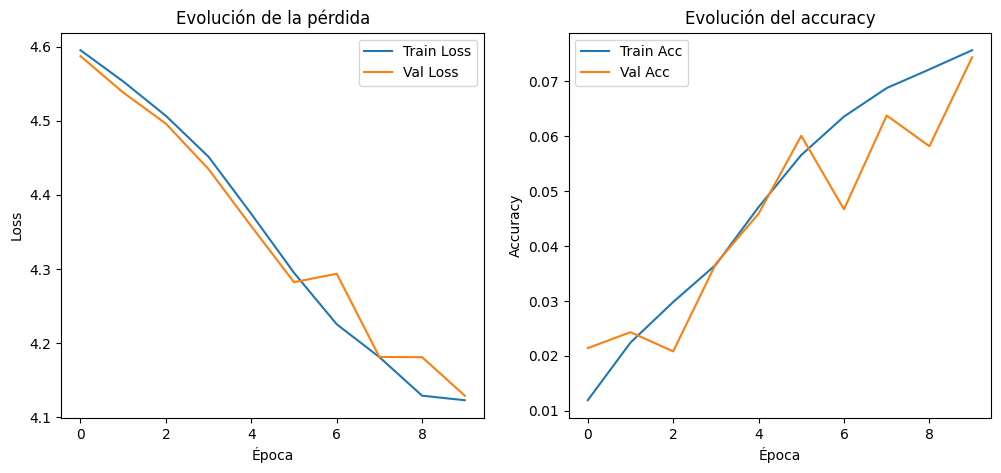

Epoch 1/10 - Loss: 4.6406 - Acc: 0.0101 - Val Loss: 4.6454 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6394 - Acc: 0.0101 - Val Loss: 4.6436 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6370 - Acc: 0.0101 - Val Loss: 4.6419 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6359 - Acc: 0.0103 - Val Loss: 4.6404 - Val Acc: 0.0102
Epoch 5/10 - Loss: 4.6328 - Acc: 0.0111 - Val Loss: 4.6389 - Val Acc: 0.0117
Epoch 6/10 - Loss: 4.6322 - Acc: 0.0116 - Val Loss: 4.6375 - Val Acc: 0.0099
Epoch 7/10 - Loss: 4.6307 - Acc: 0.0119 - Val Loss: 4.6362 - Val Acc: 0.0099
Epoch 8/10 - Loss: 4.6289 - Acc: 0.0123 - Val Loss: 4.6349 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6284 - Acc: 0.0124 - Val Loss: 4.6338 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6268 - Acc: 0.0124 - Val Loss: 4.6326 - Val Acc: 0.0100


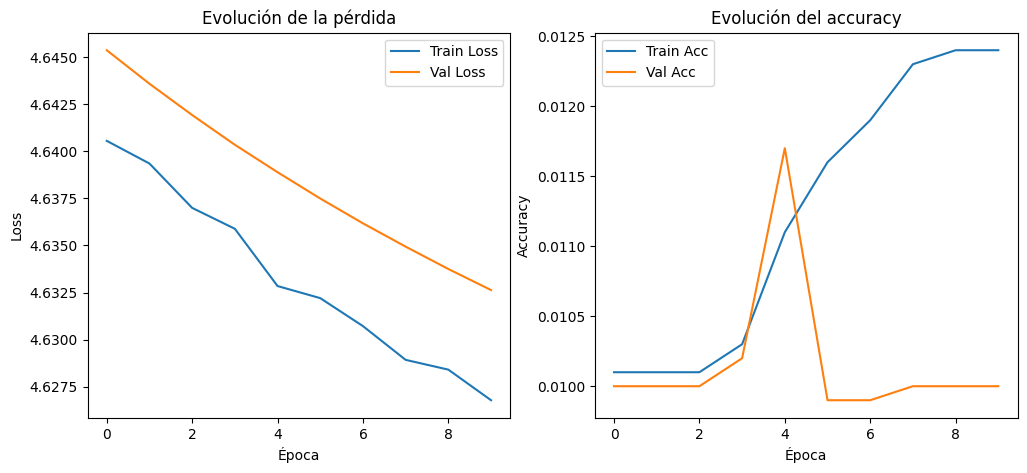

Epoch 1/10 - Loss: 4.6072 - Acc: 0.0138 - Val Loss: 4.6037 - Val Acc: 0.0155
Epoch 2/10 - Loss: 4.6005 - Acc: 0.0162 - Val Loss: 4.5992 - Val Acc: 0.0156
Epoch 3/10 - Loss: 4.5951 - Acc: 0.0170 - Val Loss: 4.5955 - Val Acc: 0.0157
Epoch 4/10 - Loss: 4.5908 - Acc: 0.0157 - Val Loss: 4.5916 - Val Acc: 0.0160
Epoch 5/10 - Loss: 4.5863 - Acc: 0.0160 - Val Loss: 4.5877 - Val Acc: 0.0167
Epoch 6/10 - Loss: 4.5820 - Acc: 0.0182 - Val Loss: 4.5840 - Val Acc: 0.0172
Epoch 7/10 - Loss: 4.5779 - Acc: 0.0181 - Val Loss: 4.5803 - Val Acc: 0.0197
Epoch 8/10 - Loss: 4.5742 - Acc: 0.0211 - Val Loss: 4.5767 - Val Acc: 0.0196
Epoch 9/10 - Loss: 4.5698 - Acc: 0.0217 - Val Loss: 4.5729 - Val Acc: 0.0191
Epoch 10/10 - Loss: 4.5655 - Acc: 0.0215 - Val Loss: 4.5690 - Val Acc: 0.0240


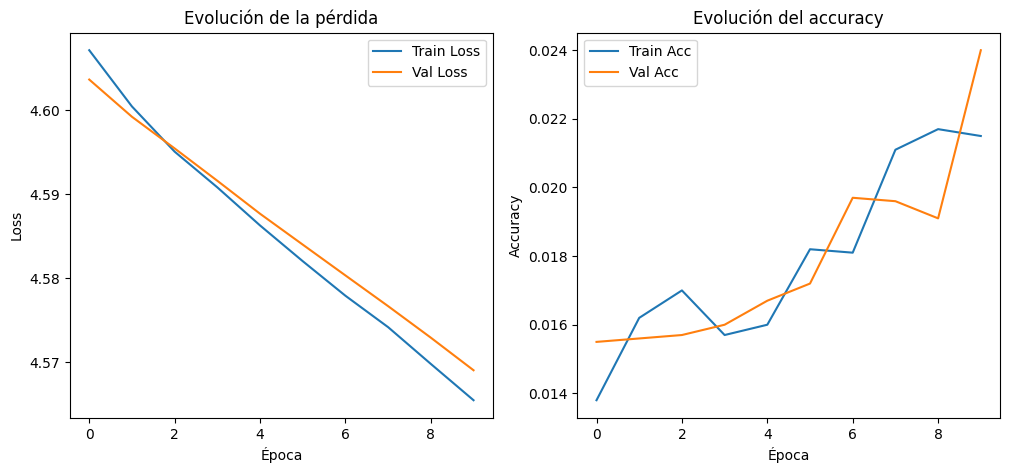

Epoch 1/10 - Loss: 4.6560 - Acc: 0.0090 - Val Loss: 4.6529 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6557 - Acc: 0.0090 - Val Loss: 4.6527 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6550 - Acc: 0.0090 - Val Loss: 4.6525 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6543 - Acc: 0.0090 - Val Loss: 4.6522 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6548 - Acc: 0.0090 - Val Loss: 4.6520 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6541 - Acc: 0.0090 - Val Loss: 4.6517 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6544 - Acc: 0.0090 - Val Loss: 4.6515 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6543 - Acc: 0.0090 - Val Loss: 4.6513 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6538 - Acc: 0.0090 - Val Loss: 4.6510 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6537 - Acc: 0.0089 - Val Loss: 4.6508 - Val Acc: 0.0100


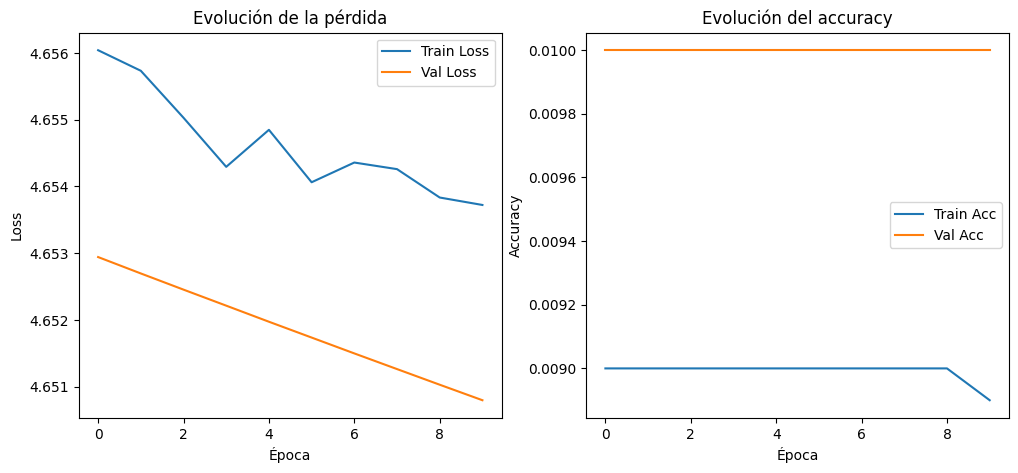

Epoch 1/10 - Loss: 4.6185 - Acc: 0.0130 - Val Loss: 4.6161 - Val Acc: 0.0120
Epoch 2/10 - Loss: 4.6172 - Acc: 0.0127 - Val Loss: 4.6148 - Val Acc: 0.0122
Epoch 3/10 - Loss: 4.6160 - Acc: 0.0122 - Val Loss: 4.6138 - Val Acc: 0.0124
Epoch 4/10 - Loss: 4.6147 - Acc: 0.0121 - Val Loss: 4.6129 - Val Acc: 0.0119
Epoch 5/10 - Loss: 4.6137 - Acc: 0.0123 - Val Loss: 4.6121 - Val Acc: 0.0113
Epoch 6/10 - Loss: 4.6129 - Acc: 0.0120 - Val Loss: 4.6114 - Val Acc: 0.0103
Epoch 7/10 - Loss: 4.6121 - Acc: 0.0122 - Val Loss: 4.6107 - Val Acc: 0.0102
Epoch 8/10 - Loss: 4.6115 - Acc: 0.0114 - Val Loss: 4.6101 - Val Acc: 0.0107
Epoch 9/10 - Loss: 4.6107 - Acc: 0.0109 - Val Loss: 4.6096 - Val Acc: 0.0106
Epoch 10/10 - Loss: 4.6103 - Acc: 0.0100 - Val Loss: 4.6090 - Val Acc: 0.0105


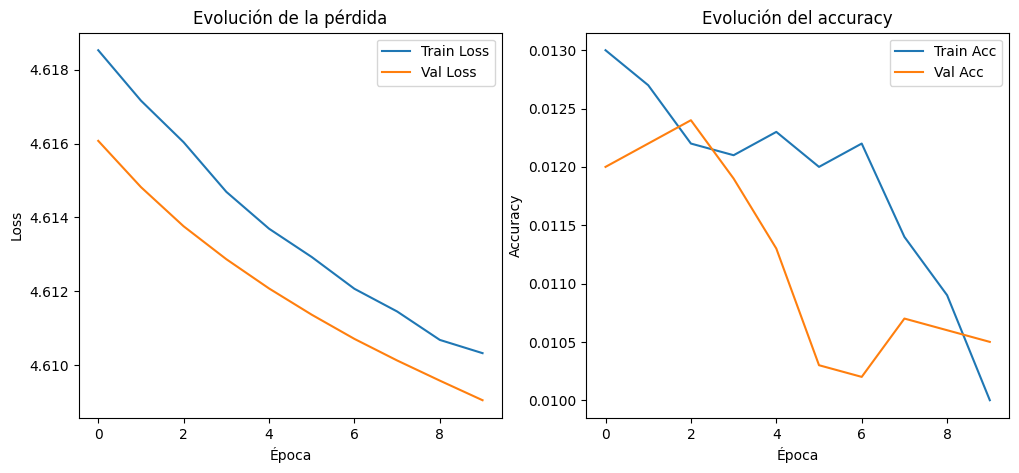

Epoch 1/10 - Loss: 4.6401 - Acc: 0.0088 - Val Loss: 4.6342 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6273 - Acc: 0.0110 - Val Loss: 4.6255 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6186 - Acc: 0.0110 - Val Loss: 4.6200 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6136 - Acc: 0.0110 - Val Loss: 4.6163 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6095 - Acc: 0.0110 - Val Loss: 4.6139 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6065 - Acc: 0.0110 - Val Loss: 4.6124 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6049 - Acc: 0.0110 - Val Loss: 4.6114 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6036 - Acc: 0.0110 - Val Loss: 4.6108 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6028 - Acc: 0.0109 - Val Loss: 4.6104 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6019 - Acc: 0.0125 - Val Loss: 4.6102 - Val Acc: 0.0100


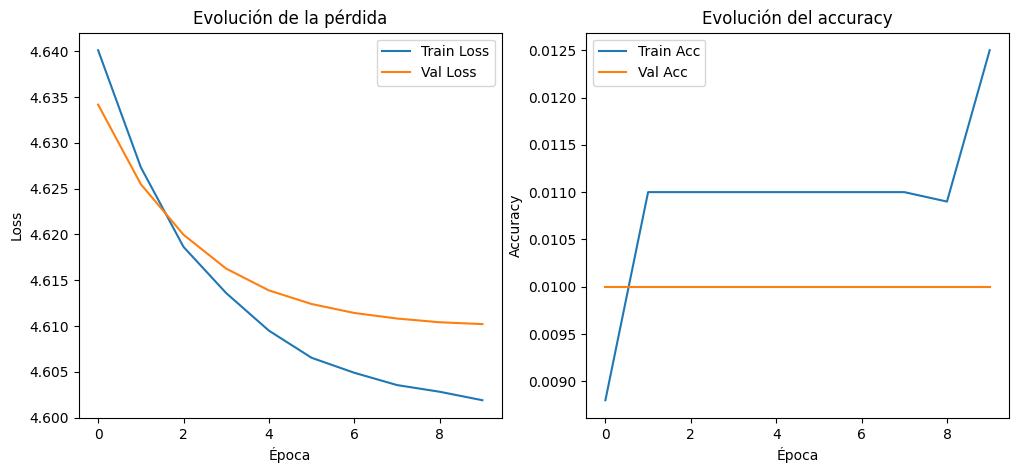

Epoch 1/10 - Loss: 4.6076 - Acc: 0.0083 - Val Loss: 4.6009 - Val Acc: 0.0127
Epoch 2/10 - Loss: 4.5936 - Acc: 0.0189 - Val Loss: 4.5897 - Val Acc: 0.0207
Epoch 3/10 - Loss: 4.5741 - Acc: 0.0271 - Val Loss: 4.5672 - Val Acc: 0.0286
Epoch 4/10 - Loss: 4.5410 - Acc: 0.0361 - Val Loss: 4.5259 - Val Acc: 0.0308
Epoch 5/10 - Loss: 4.4829 - Acc: 0.0403 - Val Loss: 4.4610 - Val Acc: 0.0366
Epoch 6/10 - Loss: 4.4031 - Acc: 0.0446 - Val Loss: 4.3808 - Val Acc: 0.0442
Epoch 7/10 - Loss: 4.3518 - Acc: 0.0477 - Val Loss: 4.3396 - Val Acc: 0.0461
Epoch 8/10 - Loss: 4.3148 - Acc: 0.0501 - Val Loss: 4.2979 - Val Acc: 0.0502
Epoch 9/10 - Loss: 4.2650 - Acc: 0.0532 - Val Loss: 4.2719 - Val Acc: 0.0493
Epoch 10/10 - Loss: 4.2231 - Acc: 0.0563 - Val Loss: 4.2152 - Val Acc: 0.0640


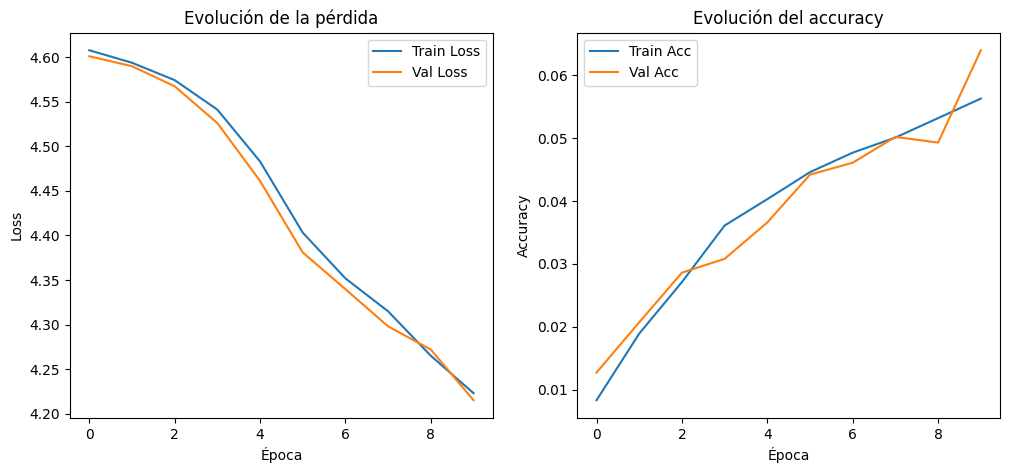

Epoch 1/10 - Loss: 4.6487 - Acc: 0.0103 - Val Loss: 4.6474 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6474 - Acc: 0.0103 - Val Loss: 4.6458 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6456 - Acc: 0.0103 - Val Loss: 4.6443 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6433 - Acc: 0.0103 - Val Loss: 4.6429 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6421 - Acc: 0.0103 - Val Loss: 4.6415 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6409 - Acc: 0.0103 - Val Loss: 4.6402 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6394 - Acc: 0.0103 - Val Loss: 4.6389 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6379 - Acc: 0.0103 - Val Loss: 4.6377 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6367 - Acc: 0.0103 - Val Loss: 4.6366 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6351 - Acc: 0.0103 - Val Loss: 4.6354 - Val Acc: 0.0100


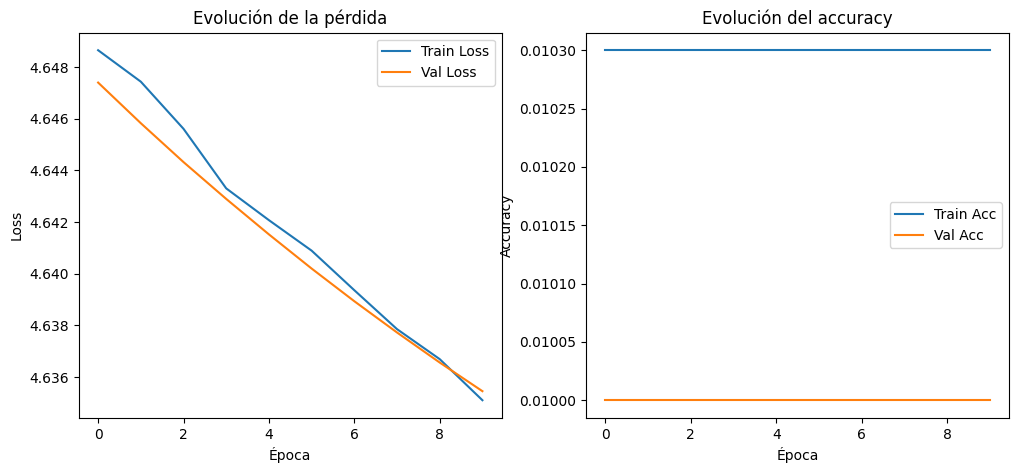

Epoch 1/10 - Loss: 4.6087 - Acc: 0.0088 - Val Loss: 4.6091 - Val Acc: 0.0094
Epoch 2/10 - Loss: 4.6070 - Acc: 0.0089 - Val Loss: 4.6077 - Val Acc: 0.0096
Epoch 3/10 - Loss: 4.6055 - Acc: 0.0089 - Val Loss: 4.6065 - Val Acc: 0.0098
Epoch 4/10 - Loss: 4.6040 - Acc: 0.0093 - Val Loss: 4.6054 - Val Acc: 0.0098
Epoch 5/10 - Loss: 4.6026 - Acc: 0.0096 - Val Loss: 4.6044 - Val Acc: 0.0102
Epoch 6/10 - Loss: 4.6017 - Acc: 0.0102 - Val Loss: 4.6033 - Val Acc: 0.0107
Epoch 7/10 - Loss: 4.6005 - Acc: 0.0106 - Val Loss: 4.6024 - Val Acc: 0.0099
Epoch 8/10 - Loss: 4.5991 - Acc: 0.0082 - Val Loss: 4.6012 - Val Acc: 0.0108
Epoch 9/10 - Loss: 4.5980 - Acc: 0.0104 - Val Loss: 4.6002 - Val Acc: 0.0116
Epoch 10/10 - Loss: 4.5967 - Acc: 0.0114 - Val Loss: 4.5992 - Val Acc: 0.0108


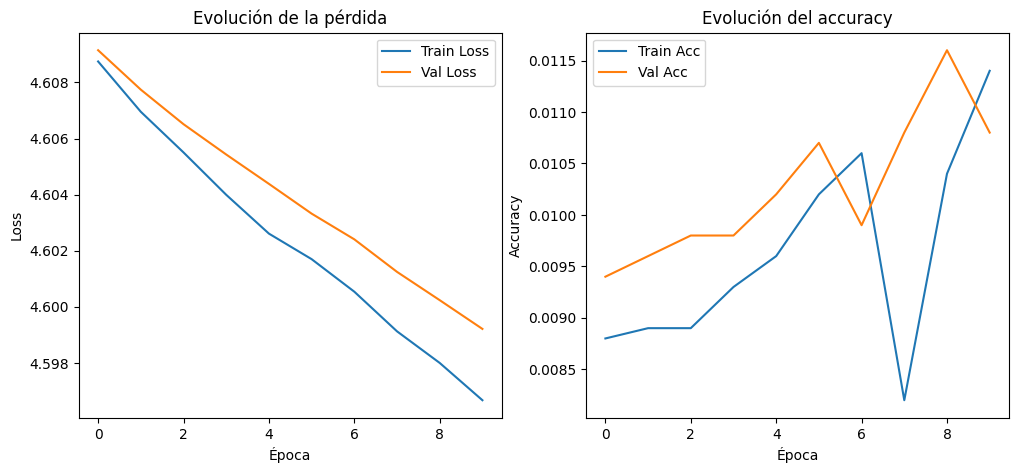

Epoch 1/10 - Loss: 4.6552 - Acc: 0.0094 - Val Loss: 4.6634 - Val Acc: 0.0100
Epoch 2/10 - Loss: 4.6542 - Acc: 0.0094 - Val Loss: 4.6632 - Val Acc: 0.0100
Epoch 3/10 - Loss: 4.6545 - Acc: 0.0094 - Val Loss: 4.6629 - Val Acc: 0.0100
Epoch 4/10 - Loss: 4.6545 - Acc: 0.0094 - Val Loss: 4.6627 - Val Acc: 0.0100
Epoch 5/10 - Loss: 4.6533 - Acc: 0.0094 - Val Loss: 4.6624 - Val Acc: 0.0100
Epoch 6/10 - Loss: 4.6529 - Acc: 0.0094 - Val Loss: 4.6622 - Val Acc: 0.0100
Epoch 7/10 - Loss: 4.6539 - Acc: 0.0094 - Val Loss: 4.6620 - Val Acc: 0.0100
Epoch 8/10 - Loss: 4.6524 - Acc: 0.0094 - Val Loss: 4.6617 - Val Acc: 0.0100
Epoch 9/10 - Loss: 4.6532 - Acc: 0.0094 - Val Loss: 4.6615 - Val Acc: 0.0100
Epoch 10/10 - Loss: 4.6536 - Acc: 0.0094 - Val Loss: 4.6612 - Val Acc: 0.0100


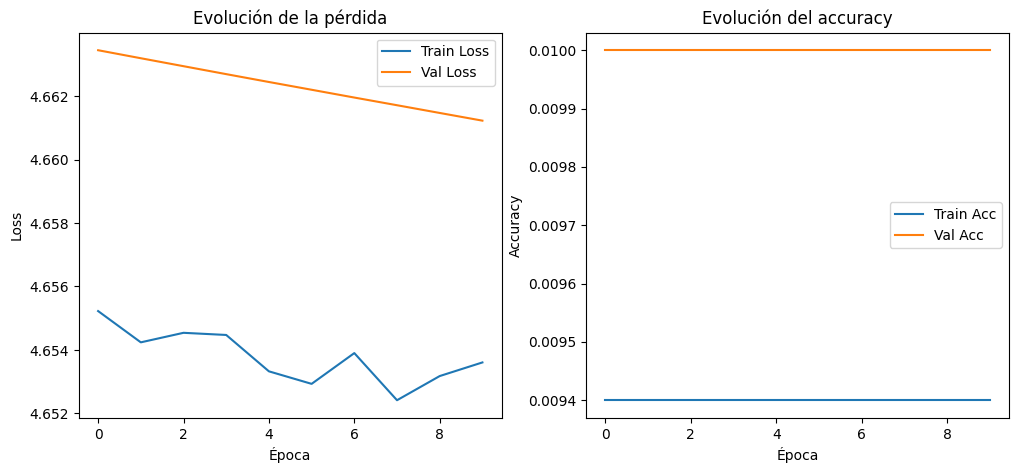

Epoch 1/10 - Loss: 4.6137 - Acc: 0.0089 - Val Loss: 4.6129 - Val Acc: 0.0112
Epoch 2/10 - Loss: 4.6132 - Acc: 0.0093 - Val Loss: 4.6127 - Val Acc: 0.0113
Epoch 3/10 - Loss: 4.6127 - Acc: 0.0101 - Val Loss: 4.6124 - Val Acc: 0.0110
Epoch 4/10 - Loss: 4.6124 - Acc: 0.0103 - Val Loss: 4.6121 - Val Acc: 0.0108
Epoch 5/10 - Loss: 4.6123 - Acc: 0.0103 - Val Loss: 4.6119 - Val Acc: 0.0111
Epoch 6/10 - Loss: 4.6119 - Acc: 0.0102 - Val Loss: 4.6117 - Val Acc: 0.0109
Epoch 7/10 - Loss: 4.6113 - Acc: 0.0102 - Val Loss: 4.6114 - Val Acc: 0.0106
Epoch 8/10 - Loss: 4.6114 - Acc: 0.0100 - Val Loss: 4.6112 - Val Acc: 0.0114
Epoch 9/10 - Loss: 4.6114 - Acc: 0.0097 - Val Loss: 4.6110 - Val Acc: 0.0110
Epoch 10/10 - Loss: 4.6107 - Acc: 0.0099 - Val Loss: 4.6108 - Val Acc: 0.0112


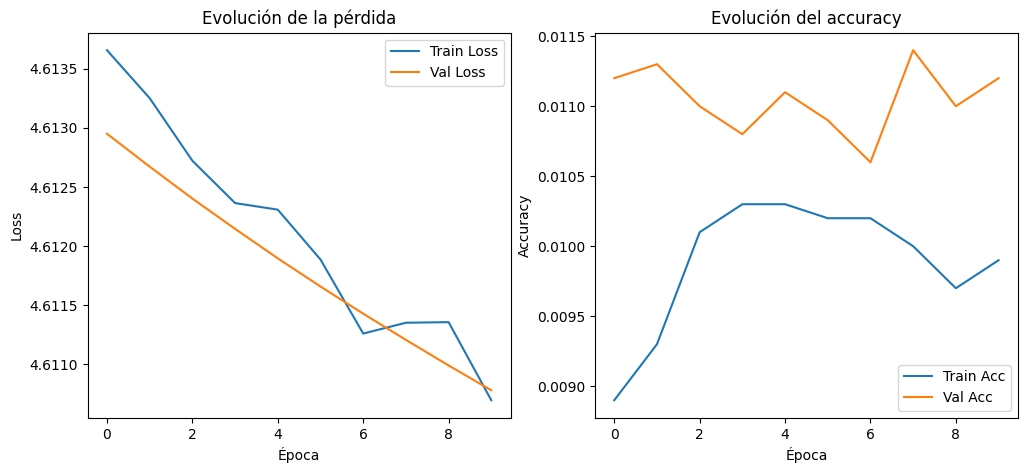

hidden  learning_rate      act  val_acc  val_loss
13         [128]          0.100   linear   0.0951  4.028214
7           [64]          0.100   linear   0.0883  4.070895
1           [32]          0.100   linear   0.0813  4.099146
19      [64, 32]          0.100   linear   0.0744  4.128631
25  [32, 32, 32]          0.100   linear   0.0640  4.215168
15         [128]          0.010   linear   0.0488  4.505311
12         [128]          0.100  sigmoid   0.0452  4.521195
6           [64]          0.100  sigmoid   0.0396  4.539020
3           [32]          0.010   linear   0.0353  4.542287
9           [64]          0.010   linear   0.0348  4.511072
21      [64, 32]          0.010   linear   0.0240  4.569035
0           [32]          0.100  sigmoid   0.0162  4.574492
17         [128]          0.001   linear   0.0154  4.600094
14         [128]          0.010  sigmoid   0.0153  4.607829
5           [32]          0.001   linear   0.0136  4.604247
2           [32]          0.010  sigmoid   0.0125  4.612425
23      [64, 32]          0.001   linear   0.0124  4.609046
8           [64]          0.010  sigmoid   0.0124  4.612573
20      [64, 32]          0.010  sigmoid   0.0117  4.632632
27  [32, 32, 32]          0.010   linear   0.0116  4.599212
11          [64]          0.001   linear   0.0114  4.598531
29  [32, 32, 32]          0.001   linear   0.0114  4.610782
10          [64]          0.001  sigmoid   0.0100  4.645623
4           [32]          0.001  sigmoid   0.0100  4.640432
18      [64, 32]          0.100  sigmoid   0.0100  4.608206
16         [128]          0.001  sigmoid   0.0100  4.648735
24  [32, 32, 32]          0.100  sigmoid   0.0100  4.610208
22      [64, 32]          0.001  sigmoid   0.0100  4.650799
26  [32, 32, 32]          0.010  sigmoid   0.0100  4.635448
28  [32, 32, 32]          0.001  sigmoid   0.0100  4.661227

In [ ]:
output_layer_size = 100
pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size], learning_rate=lr, activation=act, num_workers=num_workers
    )
    print(f"Entrenando con f(x) activación={act}, capas={hs}, lr={lr}")
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        batch_size=batch_size,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)